<a href="https://colab.research.google.com/github/NeedlerOP/BinanceData/blob/main/Notebooks/ETH_USD_Price_Forcasting_EDIT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MoMkhani/ETH-USD-PriceForecasting/blob/main/Notebooks/ETH_USD_Price_Forcasting.ipynb)

# **Ethereum Price Forecasting**

# **PROBLEM DESCRIPTION**

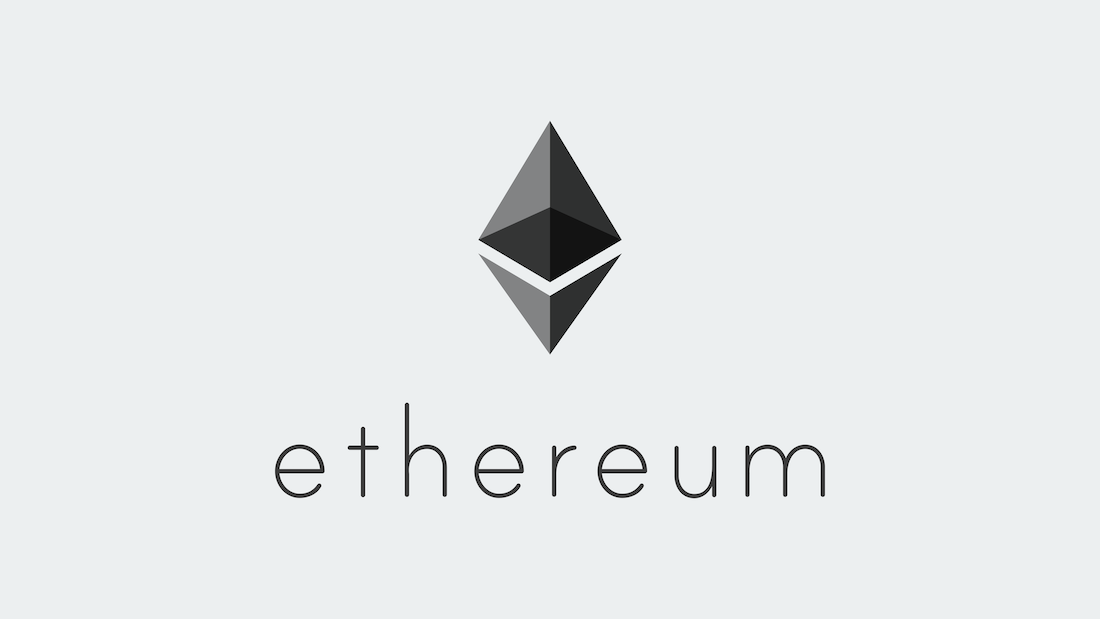

Cryptocurrencies have become one of the most discussed internet talking points in recent years. Twitter's CEO Jack Dorsey calls them "Internet money" and believes it will be with us forever. Elon Musk of Tesla tweets about Cryptocurrencies (especially "Dogecoin") almost every week. As of January 2022, there are more than 6000 cryptocurrencies in the market - an extreme growth from just a handful of digital coins in 2013.
It is believed that the top 20 cryptocurrencies make up nearly 90 percent of the total market. Ethereum or ETH is one of them. While ETH price increased exponentially since its creation, daily or even hourly fluctuation is part of the game. Some people get rich, and some people get broke. While various factors can influence the ETH price on the market, Ethereum price forecasting can be seen as a time-series problem. In this project, I will try to deploy different machine learning models to predict ETH price and validate it on recent data.

#**1 Data Loading**

##**Retrieving the Data**


You can download the original dataset from [here](https://raw.githubusercontent.com/MoMkhani/ETH-USD-PriceForecasting/main/Data/Binance_ETHUSDT_1h.csv). The data is obtained from the historical part of [cryptodatadownload.com](https://www.cryptodatadownload.com/data/apac/) which, provides crypto prices on different exchanges. I decided to retrieve eth price from the "ASIA & PACIFIC RIM EXCHANGES" section which, offers binance data.

The original dataset suffers from different problems which, I address in the next chapter. Finally, the cleaned version of our dataset is available on my [Github](https://raw.githubusercontent.com/MoMkhani/ETH-USD-PriceForecasting/main/Data/Cleaned-ETH%20dataset.csv).

##**1.1 Loading Libraries**

In [142]:
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.metrics import  mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

# Models
import xgboost
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu

plt.style.use('classic')

##**1.2 Loading Dataset**

In [143]:
# Load dataset from github
url = 'https://raw.githubusercontent.com/NeedlerOP/Binance-Hrly/refs/heads/main/Binance_ETHUSDT_1h.csv'
df = pd.read_csv(url)
# Last five rows



# Method 1: Using pd.Series directly
#data = [1771200000000, 2695.2, 2697.94, 2690.0, 2693.04,4286.4822,11549670.347251,41200 ]  # Your desired values
#index = ['Unix', 'Open', 'High', 'Low', 'Close', 'Volume ETH','Volume USDT','trade count']  # Optional index labels
#new_row_data = pd.Series(data, index=index, name='MyArray')  # Create the Series


#new_row_data_transpose = new_row_data.transpose()

#new_row_data_transpose

#new_index = df.index[-1]

#new_row = pd.DataFrame([new_row_data], new_index)

#print(new_row)

#df = eth = pd.concat([df, new_row])

df.head()

<ipython-input-143-ff38e3e94172>:3: DtypeWarning: Columns (0,3,4,5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


https://www.CryptoDataDownload.com
Unix          Date                Symbol  Open    High    Low     Close   Volume ETH Volume USDT                             tradecount
1739660400000 2025-02-15 23:00:00 ETHUSDT 2695.2  2697.94 2690.0  2693.04 4286.4822  11549670.347251                              41200
1739656800000 2025-02-15 22:00:00 ETHUSDT 2701.09 2704.0  2687.61 2695.19 5686.3776  15334450.105088                              39427
1739653200000 2025-02-15 21:00:00 ETHUSDT 2686.1  2702.52 2685.8  2701.08 6190.2146  16680534.871184                              53153
1739649600000 2025-02-15 20:00:00 ETHUSDT 2691.6  2697.0  2679.16 2686.11 7481.7791  20102924.165606                              57721

In [56]:
df.tail()

https://www.CryptoDataDownload.com
1502956800000 2017-08-17 08:00:00 ETHUSDT 307.95 309.97 307.0 308.62 150.75029 46559.462371                                 182
1502953200000 2017-08-17 07:00:00 ETHUSDT 302.68 307.96 302.6 307.96 754.7451  229725.136967                                198
1502949600000 2017-08-17 06:00:00 ETHUSDT 302.4  304.44 301.9 302.68 303.86672 92034.441294                                 182
1502946000000 2017-08-17 05:00:00 ETHUSDT 301.61 303.28 300.0 303.1  377.67246 114043.282676                                202
1502942400000 2017-08-17 04:00:00 ETHUSDT 301.13 302.57 298.0 301.61 125.66877 37684.804181                                 129

In [57]:
# Check the columns
df.columns

Index(['https://www.CryptoDataDownload.com'], dtype='object')

In [58]:
# Check the shape
df.shape

(65643, 1)

As we saw above, the original dataset is not comprehensively tidy. The header contains the website address that we should avoid. Also, unix and date columns have different formats which, prevents us from converting them as a DateTime object.

#**2 Analysis Plan**

This project is about generating different machine learning models to predict ethereum prices in the future. Considering one feature price to predict over time makes our issue a **univariate time series problem**. This is basically a **supervised machine learning problem**, assuming the dataset whereas a window of the last records as a feature to predict the next one as the target variable.

Because of its execution speed and model performance, **XGBoost** appears to be one of the most reasonable choices of the model. Since I don't have any feedback from the domain experts, maybe we can consider this model as our baseline.
Employing **LSTM**, time series forecasting models can predict future values based on previous, sequential data. This normally provides better accuracy for predictors which, results in better decision-making for the business.  Convolutional Neural Networks (**CNN**) are cheaper than LSTM since they learn by batch. Historically, CNNs are highly noise-resistant models that can catch very informative and non-time dependent features which lead to good performance. That's why I decided to deploy the CNN model on our data.

Here's the plan of analysis to implement this approach:


*   **Cleaning and preparing** to get the most out of our data.
*   **Exploratory Data Analysis (EDA)** to visualize observations through time, trends, and seasonality.
*   Conducting **statistical tests** to inspect stationarity.
*   **Creating a suitable dataset** that can be used for time series forecasting as a supervised machined learning problem.
*   **Defining an evaluation function** with different metrics.
*   Deploying **XGBoost, LSTM, and, CNN** models and monitoring the performance.
*   **Testing our best-trained model** on unseen and recent data.
*   **Ranking our models** based on performance metrics.



#**3 Data Preprocessing**

##**3.1 Data Formatting**

The date column clearly has diverse formats that prevent us to convert it to a data-time object. I extract rows with this characteristic based on string length. I would also make another segment for rows that follow the standard date format in our case. Using the strptime() method, I make a uniform format out of non-standard dates and concatenate two dataframes into one definitive dataframe.
Finally, before getting into our analysis, I drop unix, symbol, and tradecount columns that are unnecessary.

In [144]:
# Load again ignoring the first row (website domain)
df = pd.read_csv(url, header=1)
df.tail()

Unix                 Date   Symbol    Open    High    Low  \
65637  1502956800000  2017-08-17 08:00:00  ETHUSDT  307.95  309.97  307.0   
65638  1502953200000  2017-08-17 07:00:00  ETHUSDT  302.68  307.96  302.6   
65639  1502949600000  2017-08-17 06:00:00  ETHUSDT  302.40  304.44  301.9   
65640  1502946000000  2017-08-17 05:00:00  ETHUSDT  301.61  303.28  300.0   
65641  1502942400000  2017-08-17 04:00:00  ETHUSDT  301.13  302.57  298.0   

        Close  Volume ETH    Volume USDT  tradecount  
65637  308.62   150.75029   46559.462371         182  
65638  307.96   754.74510  229725.136967         198  
65639  302.68   303.86672   92034.441294         182  
65640  303.10   377.67246  114043.282676         202  
65641  301.61   125.66877   37684.804181         129

In [145]:
# Check columns
df.columns

Index(['Unix', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume ETH',
       'Volume USDT', 'tradecount'],
      dtype='object')

In [146]:
# Check shape
df.shape

(65642, 10)

In [147]:
# Extract rows that don't have standtad format
df = df.rename(columns={'Date': 'date'})
df = df.rename(columns={'Unix': 'unix'})
df = df.rename(columns={'Symbol': 'symbol'})
df = df.rename(columns={'Open': 'open'})
df = df.rename(columns={'High': 'high'})
df = df.rename(columns={'Low': 'low'})
df = df.rename(columns={'Close': 'close'})
df = df.rename(columns={'Volume ETH': 'volume ETH'})
df = df.rename(columns={'Volume USDT': 'volume USDT'})
df = df.rename(columns={'Tradecount': 'tradecount'})
nan_data = df[df['date'].str.len() !=19]
nan_data.shape

nan_data



unix                     date   symbol     open     high  \
60982  1519858800000  2018-02-28 23:00:00.000  ETHUSDT   858.80   861.36   
60983  1519855200000  2018-02-28 22:00:00.000  ETHUSDT   863.54   865.50   
60984  1519851600000  2018-02-28 21:00:00.000  ETHUSDT   872.02   875.00   
60985  1519848000000  2018-02-28 20:00:00.000  ETHUSDT   869.60   874.99   
60986  1519844400000  2018-02-28 19:00:00.000  ETHUSDT   866.00   870.00   
...              ...                      ...      ...      ...      ...   
61617  1517457600000  2018-02-01 04:00:00.000  ETHUSDT  1140.00  1154.72   
61618  1517454000000  2018-02-01 03:00:00.000  ETHUSDT  1150.51  1164.99   
61619  1517450400000  2018-02-01 02:00:00.000  ETHUSDT  1134.07  1154.99   
61620  1517446800000  2018-02-01 01:00:00.000  ETHUSDT  1132.00  1140.89   
61621  1517443200000  2018-02-01 00:00:00.000  ETHUSDT  1125.96  1137.99   

           low    close  volume ETH   volume USDT  tradecount  
60982   850.30   853.50  2688.93918  2.298593e+06        5220  
60983   858.34   858.35  1521.66768  1.311030e+06        3149  
60984   862.50   864.39  1410.23891  1.226549e+06        3617  
60985   868.70   872.51  1599.48261  1.395808e+06        3899  
60986   865.31   869.60   835.92342  7.254132e+05        2519  
...        ...      ...         ...           ...         ...  
61617  1130.18  1152.51  3899.48396  4.461803e+06        8404  
61618  1125.01  1140.00  7622.31840  8.731269e+06       12304  
61619  1134.07  1150.50  4828.74525  5.531565e+06        7307  
61620  1125.01  1135.00  4149.14991  4.703857e+06        7163  
61621  1120.56  1132.00  3465.84651  3.915912e+06        7057  

[640 rows x 10 columns]

In [62]:
nan_data_save = nan_data

In [63]:
nan_data = nan_data_save

In [64]:

nan_data

nan_data.tail()

unix                     date   symbol     open     high  \
61617  1517457600000  2018-02-01 04:00:00.000  ETHUSDT  1140.00  1154.72   
61618  1517454000000  2018-02-01 03:00:00.000  ETHUSDT  1150.51  1164.99   
61619  1517450400000  2018-02-01 02:00:00.000  ETHUSDT  1134.07  1154.99   
61620  1517446800000  2018-02-01 01:00:00.000  ETHUSDT  1132.00  1140.89   
61621  1517443200000  2018-02-01 00:00:00.000  ETHUSDT  1125.96  1137.99   

           low    close  volume ETH   volume USDT  tradecount  
61617  1130.18  1152.51  3899.48396  4.461803e+06        8404  
61618  1125.01  1140.00  7622.31840  8.731269e+06       12304  
61619  1134.07  1150.50  4828.74525  5.531565e+06        7307  
61620  1125.01  1135.00  4149.14991  4.703857e+06        7163  
61621  1120.56  1132.00  3465.84651  3.915912e+06        7057

In [148]:
# Check if we catch them right!


import pandas as pd

nan_data['date'] = nan_data['date'].astype(str)  # Convert to string type
nan_data['date'] = nan_data['date'].str.replace(r'\.000$', '', regex=True)  # Remove trailing ".000"
nan_data['date'] = nan_data['date'].str.replace(r'\.800$', '', regex=True)  # Remove trailing ".000"
nan_data['date'] = pd.to_datetime(nan_data['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce') # Explicitly specify the format and handle errors

nan_data




<ipython-input-148-fc87f65849fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_data['date'] = nan_data['date'].astype(str)  # Convert to string type
<ipython-input-148-fc87f65849fd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_data['date'] = nan_data['date'].str.replace(r'\.000$', '', regex=True)  # Remove trailing ".000"
<ipython-input-148-fc87f65849fd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

unix                date   symbol     open     high      low  \
60982  1519858800000 2018-02-28 23:00:00  ETHUSDT   858.80   861.36   850.30   
60983  1519855200000 2018-02-28 22:00:00  ETHUSDT   863.54   865.50   858.34   
60984  1519851600000 2018-02-28 21:00:00  ETHUSDT   872.02   875.00   862.50   
60985  1519848000000 2018-02-28 20:00:00  ETHUSDT   869.60   874.99   868.70   
60986  1519844400000 2018-02-28 19:00:00  ETHUSDT   866.00   870.00   865.31   
...              ...                 ...      ...      ...      ...      ...   
61617  1517457600000 2018-02-01 04:00:00  ETHUSDT  1140.00  1154.72  1130.18   
61618  1517454000000 2018-02-01 03:00:00  ETHUSDT  1150.51  1164.99  1125.01   
61619  1517450400000 2018-02-01 02:00:00  ETHUSDT  1134.07  1154.99  1134.07   
61620  1517446800000 2018-02-01 01:00:00  ETHUSDT  1132.00  1140.89  1125.01   
61621  1517443200000 2018-02-01 00:00:00  ETHUSDT  1125.96  1137.99  1120.56   

         close  volume ETH   volume USDT  tradecount  
60982   853.50  2688.93918  2.298593e+06        5220  
60983   858.35  1521.66768  1.311030e+06        3149  
60984   864.39  1410.23891  1.226549e+06        3617  
60985   872.51  1599.48261  1.395808e+06        3899  
60986   869.60   835.92342  7.254132e+05        2519  
...        ...         ...           ...         ...  
61617  1152.51  3899.48396  4.461803e+06        8404  
61618  1140.00  7622.31840  8.731269e+06       12304  
61619  1150.50  4828.74525  5.531565e+06        7307  
61620  1135.00  4149.14991  4.703857e+06        7163  
61621  1132.00  3465.84651  3.915912e+06        7057  

[640 rows x 10 columns]

In [149]:
nan_data_save2 = nan_data

In [150]:
nan_data = nan_data_save2

In [151]:
dfsave = df

In [46]:
df = dfsave


In [152]:
# Extract rows from ETH were wrong

#dfcopy = df

df = df[df.date.str.len()== 19]
df['date'] = pd.to_datetime(df['date'])
df.shape



<ipython-input-152-203b13da479a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


(65002, 10)

In [69]:
df

unix                date   symbol     open     high      low  \
0      1739660400000 2025-02-15 23:00:00  ETHUSDT  2695.20  2697.94  2690.00   
1      1739656800000 2025-02-15 22:00:00  ETHUSDT  2701.09  2704.00  2687.61   
2      1739653200000 2025-02-15 21:00:00  ETHUSDT  2686.10  2702.52  2685.80   
3      1739649600000 2025-02-15 20:00:00  ETHUSDT  2691.60  2697.00  2679.16   
4      1739646000000 2025-02-15 19:00:00  ETHUSDT  2702.84  2705.53  2690.49   
...              ...                 ...      ...      ...      ...      ...   
65637  1502956800000 2017-08-17 08:00:00  ETHUSDT   307.95   309.97   307.00   
65638  1502953200000 2017-08-17 07:00:00  ETHUSDT   302.68   307.96   302.60   
65639  1502949600000 2017-08-17 06:00:00  ETHUSDT   302.40   304.44   301.90   
65640  1502946000000 2017-08-17 05:00:00  ETHUSDT   301.61   303.28   300.00   
65641  1502942400000 2017-08-17 04:00:00  ETHUSDT   301.13   302.57   298.00   

         close  volume ETH   volume USDT  tradecount  
0      2693.04  4286.48220  1.154967e+07       41200  
1      2695.19  5686.37760  1.533445e+07       39427  
2      2701.08  6190.21460  1.668053e+07       53153  
3      2686.11  7481.77910  2.010292e+07       57721  
4      2691.59  4673.73530  1.261433e+07       51216  
...        ...         ...           ...         ...  
65637   308.62   150.75029  4.655946e+04         182  
65638   307.96   754.74510  2.297251e+05         198  
65639   302.68   303.86672  9.203444e+04         182  
65640   303.10   377.67246  1.140433e+05         202  
65641   301.61   125.66877  3.768480e+04         129  

[65002 rows x 10 columns]

In [153]:
dfsave2 = df
nan_datasave2 = nan_data

In [215]:


nan_data


unix                date   symbol     open     high      low  \
60982  1519858800000 2018-02-28 23:00:00  ETHUSDT   858.80   861.36   850.30   
60983  1519855200000 2018-02-28 22:00:00  ETHUSDT   863.54   865.50   858.34   
60984  1519851600000 2018-02-28 21:00:00  ETHUSDT   872.02   875.00   862.50   
60985  1519848000000 2018-02-28 20:00:00  ETHUSDT   869.60   874.99   868.70   
60986  1519844400000 2018-02-28 19:00:00  ETHUSDT   866.00   870.00   865.31   
...              ...                 ...      ...      ...      ...      ...   
61617  1517457600000 2018-02-01 04:00:00  ETHUSDT  1140.00  1154.72  1130.18   
61618  1517454000000 2018-02-01 03:00:00  ETHUSDT  1150.51  1164.99  1125.01   
61619  1517450400000 2018-02-01 02:00:00  ETHUSDT  1134.07  1154.99  1134.07   
61620  1517446800000 2018-02-01 01:00:00  ETHUSDT  1132.00  1140.89  1125.01   
61621  1517443200000 2018-02-01 00:00:00  ETHUSDT  1125.96  1137.99  1120.56   

         close  volume ETH   volume USDT  tradecount  
60982   853.50  2688.93918  2.298593e+06        5220  
60983   858.35  1521.66768  1.311030e+06        3149  
60984   864.39  1410.23891  1.226549e+06        3617  
60985   872.51  1599.48261  1.395808e+06        3899  
60986   869.60   835.92342  7.254132e+05        2519  
...        ...         ...           ...         ...  
61617  1152.51  3899.48396  4.461803e+06        8404  
61618  1140.00  7622.31840  8.731269e+06       12304  
61619  1150.50  4828.74525  5.531565e+06        7307  
61620  1135.00  4149.14991  4.703857e+06        7163  
61621  1132.00  3465.84651  3.915912e+06        7057  

[640 rows x 10 columns]

In [154]:


# Concatenate two dfs to make a new one
df = pd.concat([nan_data,df], axis=0)
# Check if shape is right
df.shape

(65642, 10)

In [155]:
dfsave3 = df
nan_datasave3 = nan_data

In [115]:
df.head()

unix                date   symbol    open    high     low  \
60982  1519858800000 2018-02-28 23:00:00  ETHUSDT  858.80  861.36  850.30   
60983  1519855200000 2018-02-28 22:00:00  ETHUSDT  863.54  865.50  858.34   
60984  1519851600000 2018-02-28 21:00:00  ETHUSDT  872.02  875.00  862.50   
60985  1519848000000 2018-02-28 20:00:00  ETHUSDT  869.60  874.99  868.70   
60986  1519844400000 2018-02-28 19:00:00  ETHUSDT  866.00  870.00  865.31   

        close  volume ETH   volume USDT  tradecount  
60982  853.50  2688.93918  2.298593e+06        5220  
60983  858.35  1521.66768  1.311030e+06        3149  
60984  864.39  1410.23891  1.226549e+06        3617  
60985  872.51  1599.48261  1.395808e+06        3899  
60986  869.60   835.92342  7.254132e+05        2519

In [156]:
ordered_df = df.sort_values(by=['date'], ascending=True)  # Ascending order (oldest to newest)

ordered_df

unix                date   symbol     open     high      low  \
65641  1502942400000 2017-08-17 04:00:00  ETHUSDT   301.13   302.57   298.00   
65640  1502946000000 2017-08-17 05:00:00  ETHUSDT   301.61   303.28   300.00   
65639  1502949600000 2017-08-17 06:00:00  ETHUSDT   302.40   304.44   301.90   
65638  1502953200000 2017-08-17 07:00:00  ETHUSDT   302.68   307.96   302.60   
65637  1502956800000 2017-08-17 08:00:00  ETHUSDT   307.95   309.97   307.00   
...              ...                 ...      ...      ...      ...      ...   
4      1739646000000 2025-02-15 19:00:00  ETHUSDT  2702.84  2705.53  2690.49   
3      1739649600000 2025-02-15 20:00:00  ETHUSDT  2691.60  2697.00  2679.16   
2      1739653200000 2025-02-15 21:00:00  ETHUSDT  2686.10  2702.52  2685.80   
1      1739656800000 2025-02-15 22:00:00  ETHUSDT  2701.09  2704.00  2687.61   
0      1739660400000 2025-02-15 23:00:00  ETHUSDT  2695.20  2697.94  2690.00   

         close  volume ETH   volume USDT  tradecount  
65641   301.61   125.66877  3.768480e+04         129  
65640   303.10   377.67246  1.140433e+05         202  
65639   302.68   303.86672  9.203444e+04         182  
65638   307.96   754.74510  2.297251e+05         198  
65637   308.62   150.75029  4.655946e+04         182  
...        ...         ...           ...         ...  
4      2691.59  4673.73530  1.261433e+07       51216  
3      2686.11  7481.77910  2.010292e+07       57721  
2      2701.08  6190.21460  1.668053e+07       53153  
1      2695.19  5686.37760  1.533445e+07       39427  
0      2693.04  4286.48220  1.154967e+07       41200  

[65642 rows x 10 columns]

In [157]:
ordered_dfsave = ordered_df

In [116]:
ordered_df = ordered_dfsave

In [79]:


#data = [1771200000000, 2695.2, 2697.94, 2690.0, 2693.04,4286.4822,11549670.347251,41200 ]  # Your desired values


# df.loc['-1'] = [1771200000000,'2026-02-15 00:00:00',0,0,0,0,0,0,0,0]

nan_data = nan_data.drop(index=nan_data.index, inplace=False)

#datenew= {'date':pd.to_datetime(['2026-02-15 00:00:00'])}
#nan_data.loc['1'] = [1771200000000, datenew,0,0,0,0,0,0,0,0]
#nan_data = pd.DataFrame(nan_data)

#nan_data['date'] = nan_data['date'].dt.strftime('%Y-%m-%d %I-%p')


#data = [1771200000000, 2695.2, 2697.94, 2690.0, 2693.04,4286.4822,11549670.347251,41200 ]  # Your desired values

# Convert 'date' column to datetime objects if it's not already
nan_data['date'] = pd.to_datetime(nan_data['date'])

# Now apply strftime
nan_data.loc['1'] = [1771200000000, '2026-02-15 00:00:00',0,0,0,0,0,0,0,0] # Assign a string representation of the date
nan_data['date'] = pd.to_datetime(nan_data['date']) # Convert the 'date' column to datetime
nan_data['date'] = nan_data['date'].dt.strftime('%Y-%m-%d %I-%p') # Apply strftime


nan_data.head()

unix              date  symbol  open  high  low  close  \
1  1771200000000  2026-02-15 12-AM       0     0     0    0      0   

   volume ETH  volume USDT  tradecount  
1           0            0           0

In [159]:
df.set_index('date', inplace=True) # Set 'date' as index after converting to datetime

df



unix   symbol    open    high     low   close  \
date                                                                          
2018-02-28 23:00:00  1519858800000  ETHUSDT  858.80  861.36  850.30  853.50   
2018-02-28 22:00:00  1519855200000  ETHUSDT  863.54  865.50  858.34  858.35   
2018-02-28 21:00:00  1519851600000  ETHUSDT  872.02  875.00  862.50  864.39   
2018-02-28 20:00:00  1519848000000  ETHUSDT  869.60  874.99  868.70  872.51   
2018-02-28 19:00:00  1519844400000  ETHUSDT  866.00  870.00  865.31  869.60   
...                            ...      ...     ...     ...     ...     ...   
2017-08-17 08:00:00  1502956800000  ETHUSDT  307.95  309.97  307.00  308.62   
2017-08-17 07:00:00  1502953200000  ETHUSDT  302.68  307.96  302.60  307.96   
2017-08-17 06:00:00  1502949600000  ETHUSDT  302.40  304.44  301.90  302.68   
2017-08-17 05:00:00  1502946000000  ETHUSDT  301.61  303.28  300.00  303.10   
2017-08-17 04:00:00  1502942400000  ETHUSDT  301.13  302.57  298.00  301.61   

                     volume ETH   volume USDT  tradecount  
date                                                       
2018-02-28 23:00:00  2688.93918  2.298593e+06        5220  
2018-02-28 22:00:00  1521.66768  1.311030e+06        3149  
2018-02-28 21:00:00  1410.23891  1.226549e+06        3617  
2018-02-28 20:00:00  1599.48261  1.395808e+06        3899  
2018-02-28 19:00:00   835.92342  7.254132e+05        2519  
...                         ...           ...         ...  
2017-08-17 08:00:00   150.75029  4.655946e+04         182  
2017-08-17 07:00:00   754.74510  2.297251e+05         198  
2017-08-17 06:00:00   303.86672  9.203444e+04         182  
2017-08-17 05:00:00   377.67246  1.140433e+05         202  
2017-08-17 04:00:00   125.66877  3.768480e+04         129  

[65642 rows x 9 columns]

In [80]:
nan_datasave4 = nan_data

In [82]:
# Format with standard practice
# Convert 'date' column back to datetime objects before applying strftime
nan_data['date'] = pd.to_datetime(nan_data['date'], format='%Y-%m-%d %I-%p')  # Explicitly specify the format including seconds and space before AM/PM
nan_data['date'] = nan_data['date'].dt.strftime('%Y-%m-%d %I:%M:%S') # Apply strftime for output
nan_data.head(10)

unix                 date  symbol  open  high  low  close  \
1  1771200000000  2026-02-15 12:00:00       0     0     0    0      0   

   volume ETH  volume USDT  tradecount  
1           0            0           0

In [83]:
nan_datasave5 = nan_data

In [162]:
# Concatenate two dfs to make a new one
#ordered_df = pd.concat([ordered_df,nan_data], axis=0)
# Check if shape is right
ordered_df = df
ordered_df.shape

df

unix   symbol    open    high     low   close  \
date                                                                          
2018-02-28 23:00:00  1519858800000  ETHUSDT  858.80  861.36  850.30  853.50   
2018-02-28 22:00:00  1519855200000  ETHUSDT  863.54  865.50  858.34  858.35   
2018-02-28 21:00:00  1519851600000  ETHUSDT  872.02  875.00  862.50  864.39   
2018-02-28 20:00:00  1519848000000  ETHUSDT  869.60  874.99  868.70  872.51   
2018-02-28 19:00:00  1519844400000  ETHUSDT  866.00  870.00  865.31  869.60   
...                            ...      ...     ...     ...     ...     ...   
2017-08-17 08:00:00  1502956800000  ETHUSDT  307.95  309.97  307.00  308.62   
2017-08-17 07:00:00  1502953200000  ETHUSDT  302.68  307.96  302.60  307.96   
2017-08-17 06:00:00  1502949600000  ETHUSDT  302.40  304.44  301.90  302.68   
2017-08-17 05:00:00  1502946000000  ETHUSDT  301.61  303.28  300.00  303.10   
2017-08-17 04:00:00  1502942400000  ETHUSDT  301.13  302.57  298.00  301.61   

                     volume ETH   volume USDT  tradecount  
date                                                       
2018-02-28 23:00:00  2688.93918  2.298593e+06        5220  
2018-02-28 22:00:00  1521.66768  1.311030e+06        3149  
2018-02-28 21:00:00  1410.23891  1.226549e+06        3617  
2018-02-28 20:00:00  1599.48261  1.395808e+06        3899  
2018-02-28 19:00:00   835.92342  7.254132e+05        2519  
...                         ...           ...         ...  
2017-08-17 08:00:00   150.75029  4.655946e+04         182  
2017-08-17 07:00:00   754.74510  2.297251e+05         198  
2017-08-17 06:00:00   303.86672  9.203444e+04         182  
2017-08-17 05:00:00   377.67246  1.140433e+05         202  
2017-08-17 04:00:00   125.66877  3.768480e+04         129  

[65642 rows x 9 columns]

In [164]:
# Check if df is fine
ordered_df.head(3)

unix   symbol    open    high     low   close  \
date                                                                          
2018-02-28 23:00:00  1519858800000  ETHUSDT  858.80  861.36  850.30  853.50   
2018-02-28 22:00:00  1519855200000  ETHUSDT  863.54  865.50  858.34  858.35   
2018-02-28 21:00:00  1519851600000  ETHUSDT  872.02  875.00  862.50  864.39   

                     volume ETH   volume USDT  tradecount  
date                                                       
2018-02-28 23:00:00  2688.93918  2.298593e+06        5220  
2018-02-28 22:00:00  1521.66768  1.311030e+06        3149  
2018-02-28 21:00:00  1410.23891  1.226549e+06        3617

In [165]:
ordered_df.to_csv('eth.csv')

ordered_dfsave2 = ordered_df

In [166]:

# Retrieve eth from eth.csv without setting index
eth = pd.read_csv('eth.csv')

# Convert 'date' column to datetime
eth['date'] = pd.to_datetime(eth['date'])

# Display the DataFrame
eth.head()
# Display the DataFrame
eth.head()

date           unix   symbol    open    high     low   close  \
0 2018-02-28 23:00:00  1519858800000  ETHUSDT  858.80  861.36  850.30  853.50   
1 2018-02-28 22:00:00  1519855200000  ETHUSDT  863.54  865.50  858.34  858.35   
2 2018-02-28 21:00:00  1519851600000  ETHUSDT  872.02  875.00  862.50  864.39   
3 2018-02-28 20:00:00  1519848000000  ETHUSDT  869.60  874.99  868.70  872.51   
4 2018-02-28 19:00:00  1519844400000  ETHUSDT  866.00  870.00  865.31  869.60   

   volume ETH   volume USDT  tradecount  
0  2688.93918  2.298593e+06        5220  
1  1521.66768  1.311030e+06        3149  
2  1410.23891  1.226549e+06        3617  
3  1599.48261  1.395808e+06        3899  
4   835.92342  7.254132e+05        2519

In [210]:

#Convert date column to datatime object
eth.set_index('date', inplace=True)


#TAKEN TRAILINGS .000 earlier

#eth['date'] = eth['date'].astype(str)  # Convert to string type
#eth['date'] = eth['date'].str.replace(r'\.000$', '', regex=True)  # Remove trailing ".000"
#eth['date'] = pd.to_datetime(eth['date'], format='%Y-%m-%d %I:%M:%S %p', errors='coerce') # Explicitly specify the format and handle errors
#eth.set_index('date', inplace=True) # Set 'date' as index after converting to datetime

# Drop unix column
eth.drop(columns=['unix','symbol', 'tradecount','symbol'], inplace=True) # 'Unnamed: 0'
eth.sort_index(ascending=True, inplace=True)
eth.tail()

open     high      low    close  volume ETH  \
date                                                                  
2025-02-15 19:00:00  2702.84  2705.53  2690.49  2691.59   4673.7353   
2025-02-15 20:00:00  2691.60  2697.00  2679.16  2686.11   7481.7791   
2025-02-15 21:00:00  2686.10  2702.52  2685.80  2701.08   6190.2146   
2025-02-15 22:00:00  2701.09  2704.00  2687.61  2695.19   5686.3776   
2025-02-15 23:00:00  2695.20  2697.94  2690.00  2693.04   4286.4822   

                      volume USDT  close_log  
date                                          
2025-02-15 19:00:00  1.261433e+07   7.898259  
2025-02-15 20:00:00  2.010292e+07   7.896222  
2025-02-15 21:00:00  1.668053e+07   7.901777  
2025-02-15 22:00:00  1.533445e+07   7.899595  
2025-02-15 23:00:00  1.154967e+07   7.898797

unix   symbol    open    high    low   close  \
date                                                                         
2017-08-17 08:00:00  1502956800000  ETHUSDT  307.95  309.97  307.0  308.62   
2017-08-17 07:00:00  1502953200000  ETHUSDT  302.68  307.96  302.6  307.96   
2017-08-17 06:00:00  1502949600000  ETHUSDT  302.40  304.44  301.9  302.68   
2017-08-17 05:00:00  1502946000000  ETHUSDT  301.61  303.28  300.0  303.10   
2017-08-17 04:00:00  1502942400000  ETHUSDT  301.13  302.57  298.0  301.61   

                     volume ETH    volume USDT  tradecount  
date                                                        
2017-08-17 08:00:00   150.75029   46559.462371         182  
2017-08-17 07:00:00   754.74510  229725.136967         198  
2017-08-17 06:00:00   303.86672   92034.441294         182  
2017-08-17 05:00:00   377.67246  114043.282676         202  
2017-08-17 04:00:00   125.66877   37684.804181         129

##**3.2 Handling Missing Values**

Scanning for any missing values, I found out there is still one row without a value in the "Volume USDT" column. I decided to take an average of two records before and after our missing one to fill in the data.

In [211]:
# Check if there is any nan
eth.isnull().sum()

open           0
high           0
low            0
close          0
volume ETH     0
volume USDT    0
close_log      0
dtype: int64

In [95]:
# Find rows that are missing
nan = eth[eth.isnull().any(axis=1)]
nan

Empty DataFrame
Columns: [open, high, low, close, volume ETH, volume USDT]
Index: []

In [96]:
# Select rows before and after our target row
#rows_toavg = eth.loc[['2019-11-07 02:00:00','2019-11-07 04:00:00'], 'volume USDT']
#rows_toavg

#rows_toavg = eth.loc[['2025-02-15 23:00:00','2026-02-15 00:00:00'], 'date']
#rows_toavg



KeyError: 'date'

In [ ]:
# Take average of two rows to fill in our missing record
eth.fillna(rows_toavg.mean(), inplace=True)

In [127]:
# Check if there is still any nan
eth.isnull().sum()

unix           0
symbol         0
open           0
high           0
low            0
close          0
volume ETH     0
volume USDT    0
tradecount     0
dtype: int64

In [212]:
# How it looks now
eth.loc['2019-11-07 02:00:00':'2019-11-07 05:00:00']

open    high     low   close   volume ETH  \
date                                                               
2019-11-07 02:00:00  189.70  189.82  188.39  189.41  19920.40770   
2019-11-07 03:00:00  189.41  189.82  188.81  189.43   8398.71214   
2019-11-07 04:00:00  189.44  189.76  189.00  189.05   9414.96569   
2019-11-07 05:00:00  189.08  189.78  187.19  189.68  26232.51838   

                      volume USDT  close_log  
date                                          
2019-11-07 02:00:00  3.766850e+06   5.249180  
2019-11-07 03:00:00  1.590046e+06   5.249285  
2019-11-07 04:00:00  1.782677e+06   5.247287  
2019-11-07 05:00:00  4.943418e+06   5.250597

#**4 Data Description and Exploration**

##**4.1 Data Information**

In [176]:
# Basic info
eth.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 65642 entries, 2017-08-17 04:00:00 to 2025-02-15 23:00:00
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         65642 non-null  int64  
 1   symbol       65642 non-null  object 
 2   open         65642 non-null  float64
 3   high         65642 non-null  float64
 4   low          65642 non-null  float64
 5   close        65642 non-null  float64
 6   volume ETH   65642 non-null  float64
 7   volume USDT  65642 non-null  float64
 8   tradecount   65642 non-null  int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 7.0+ MB


##**4.2 Summary Statistics**

In [177]:
# Summary stats
eth.describe()

unix          open          high           low         close  \
count  6.564200e+04  65642.000000  65642.000000  65642.000000  65642.000000   
mean   2.230054e+12   1482.616453   1491.061771   1473.548456   1482.648629   
std    3.250972e+13   1234.645136   1241.120338   1227.639519   1234.645692   
min    1.502942e+12     82.160000     82.950000     81.790000     82.170000   
25%    1.562322e+12    281.667500    284.145000    279.430000    281.540000   
50%    1.621528e+12   1324.860000   1331.625000   1316.430000   1324.795000   
75%    1.680630e+12   2439.387500   2455.000000   2422.802500   2439.380000   
max    1.738710e+15   4846.940000   4868.000000   4833.190000   4846.710000   

          volume ETH   volume USDT    tradecount  
count   65642.000000  6.564200e+04  6.564200e+04  
mean    21935.808494  3.323100e+07  3.295736e+04  
std     26519.270788  5.152924e+07  5.339392e+04  
min         0.000000  0.000000e+00  0.000000e+00  
25%      7126.352325  3.247996e+06  6.120000e+03  
50%     13981.118405  1.524430e+07  1.716800e+04  
75%     26985.789108  4.373309e+07  3.804375e+04  
max    508838.404900  1.245779e+09  1.590587e+06

##**4.3 Data Visualization**

In [183]:
# Resample data based on time periods to have clear view
eth_month = eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']].resample('ME').median() # Select only numeric columns
eth_week = eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']].resample('W').median()  # Select only numeric columns
eth_daily = eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']].resample('D').median() # Select only numeric columns

###**4.3.1 ETH Price through Time**

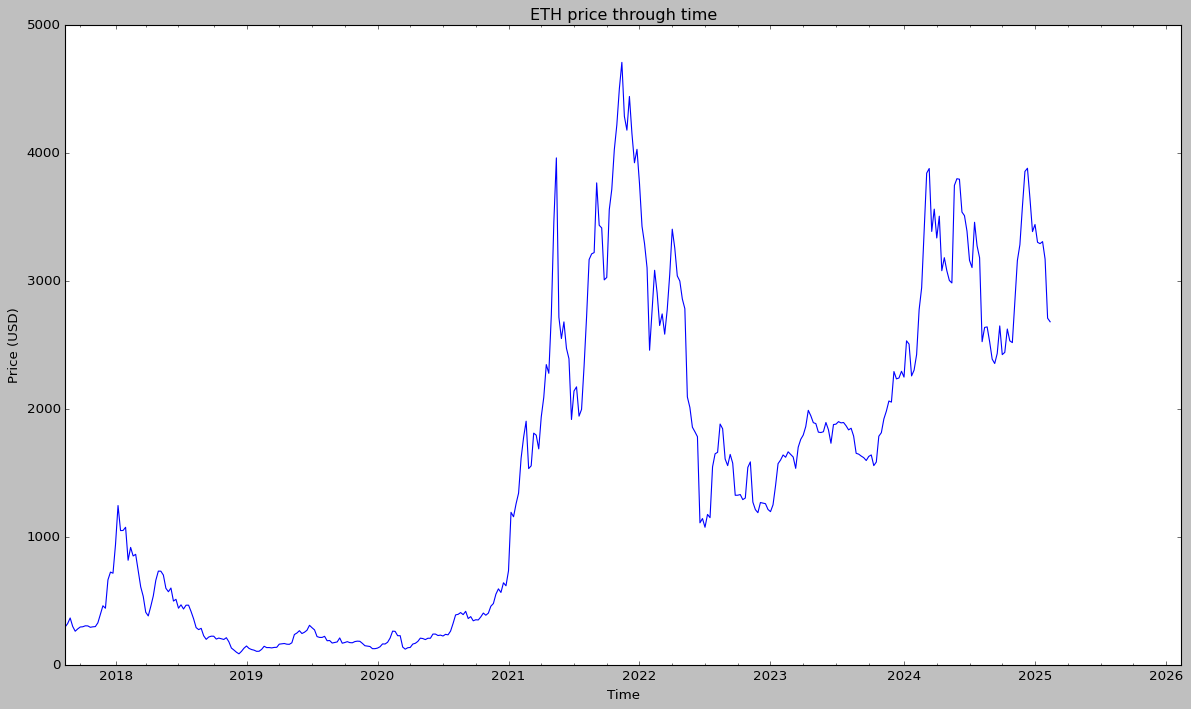

In [132]:
# Plot closing price through time
eth_week.close.plot(title='ETH price through time',
                                      xlabel='Time', ylabel='Price (USD)', figsize=[18,10])
plt.show()

ETH price has increased exponentially since 2017, first got peaked in the first weeks of 2018. Since then the price fluctuated between 100 and 500 usd until the last months of 2020. ETh started 2021 above 1000 usd and soon passed 2000 and 3000 usd values.

###**4.3.2 ETH Volume through Time**

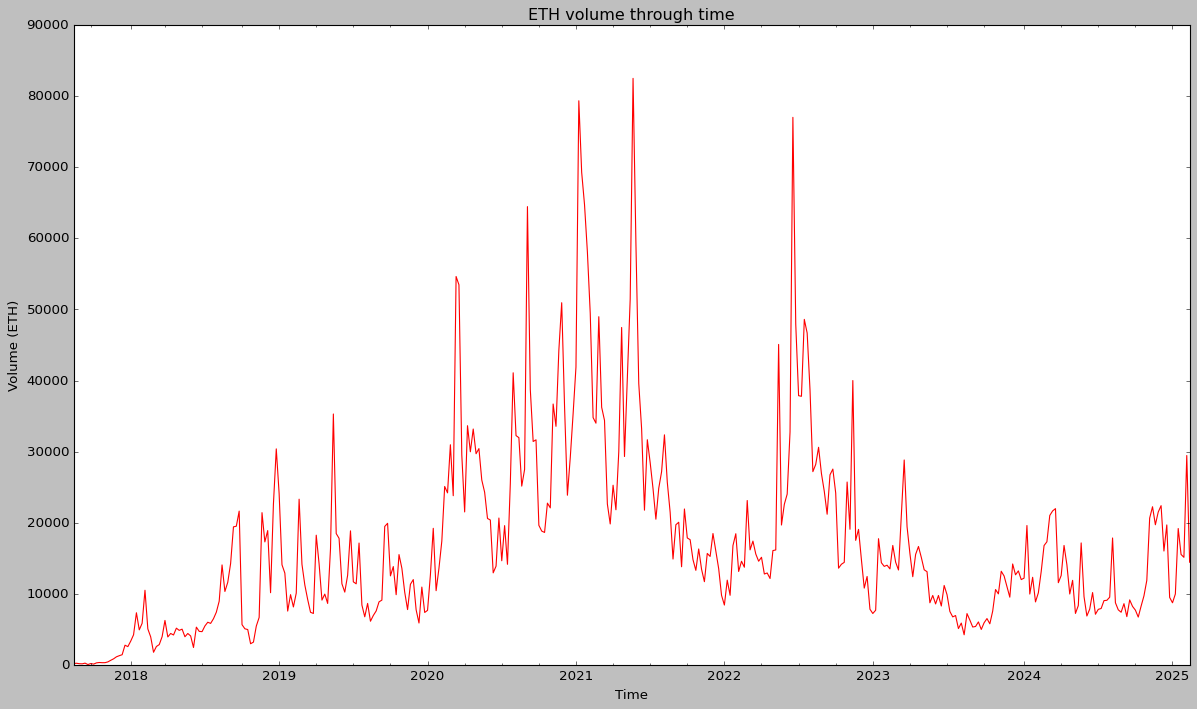

In [186]:
# Plot volume through time
eth_week['volume ETH'].plot(title='ETH volume through time',
                                      xlabel='Time', ylabel='Volume (ETH)', color='red', figsize=[18,10])
plt.show()

###**4.3.3 Closing ETH Price in 2021 by Day, Month and Year**

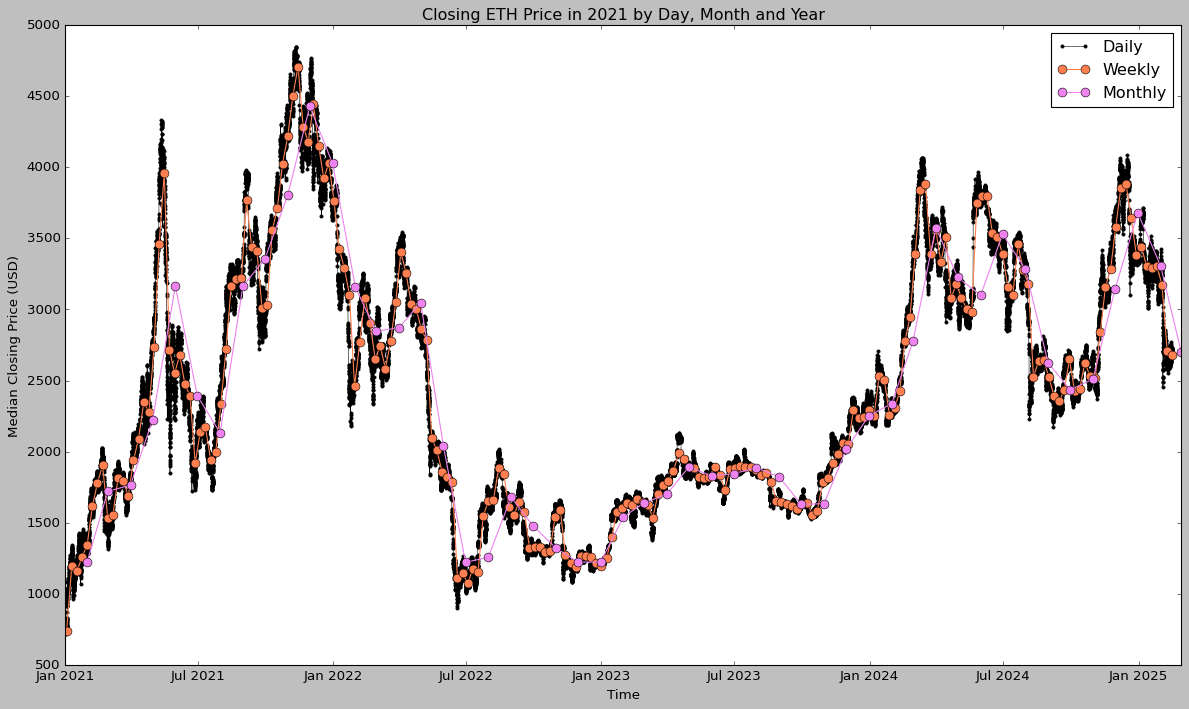

In [187]:
# Set dates as 2021
start, end = '2021-01', '2025-02'
# Plot three frequencies (daily, weekly, and monthly basis)
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(eth.loc[start:end, 'close'], marker='.', linestyle='-', linewidth = 0.5, label='Daily', color='black')
ax.plot(eth_week.loc[start:end, 'close'], marker='o', markersize=8, linestyle='-', label='Weekly', color='coral')
ax.plot(eth_month.loc[start:end, 'close'], marker='o', markersize=8, linestyle='-', label='Monthly', color='violet')
ax.set_title('Closing ETH Price in 2021 by Day, Month and Year')
ax.set_xlabel('Time')
ax.set_ylabel('Median Closing Price (USD)')
ax.legend()

###**4.3.4 ETH Opening Price Heatmap**

In [189]:
import calendar
# Create pivot table of eth opening price
all_month_year_df = pd.pivot_table(eth, values="open",
                                   index=eth.index.month,
                                   columns=eth.index.year
)
named_index = [[calendar.month_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]] # name months
all_month_year_df = all_month_year_df.set_index(named_index)
all_month_year_df

date        2017         2018        2019        2020         2021  \
Jan          NaN  1083.501763  126.477634  155.238616  1187.572097   
Feb          NaN   876.836234  125.860461  237.573275  1693.455097   
Mar          NaN   630.080161  136.005650  161.898748  1722.294253   
Apr          NaN   515.853083  164.736833  170.136908  2272.364601   
May          NaN   677.712944  217.741199  206.978306  3145.557097   
Jun          NaN   521.087616  273.942056  235.707950  2334.940778   
Jul          NaN   462.208304  248.387312  256.679220  2121.645323   
Aug   327.681938   323.042218  200.068315  399.326680  3077.480216   
Sep   294.285947   227.114958  184.922528  369.084944  3347.006379   
Oct   305.518669   211.984453  177.971680  375.485968  3796.526505   
Nov   352.535778   171.369004  173.171257  480.875104  4424.547778   
Dec   610.325108   107.427581  137.430390  619.607189  4056.864019   

date         2022         2023         2024         2025  
Jan   3062.769368  1459.284220  2373.225121  3331.760242  
Feb   2860.431384  1624.886205  2724.742572  2753.005172  
Mar   2873.046371  1669.859367  3624.828172          NaN  
Apr   3108.776319  1916.953069  3256.258625          NaN  
May   2205.307124  1841.911075  3291.880833          NaN  
Jun   1389.725403  1817.868556  3572.151889          NaN  
Jul   1342.992970  1895.406734  3274.228199          NaN  
Aug   1705.830497  1760.764852  2655.615739          NaN  
Sep   1488.143417  1621.783056  2463.237056          NaN  
Oct   1364.313683  1656.529368  2526.806841          NaN  
Nov   1307.455722  1982.716972  3095.994608          NaN  
Dec   1237.736142  2255.321425  3656.975215          NaN

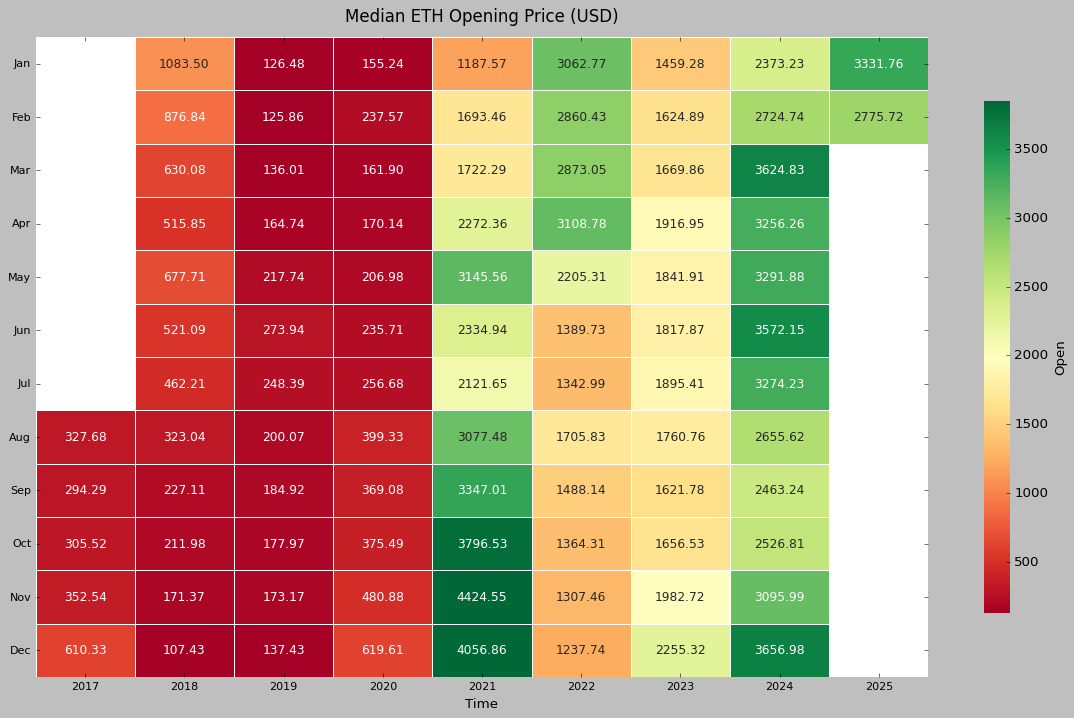

In [ ]:
plt.figure(figsize=[18,10])
# Plot the heatmap
ax = sns.heatmap(all_month_year_df, cmap='RdYlGn', robust=True, fmt='.2f',
                 annot=True, linewidths=.5, annot_kws={'size':11},
                 cbar_kws={'shrink':.8, 'label':'Open'})

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
plt.title('Median ETH Opening Price (USD)', fontdict={'fontsize':15},    pad=14)
plt.xlabel('Time')
plt.show()

###**4.3.5 Plotting the Change**

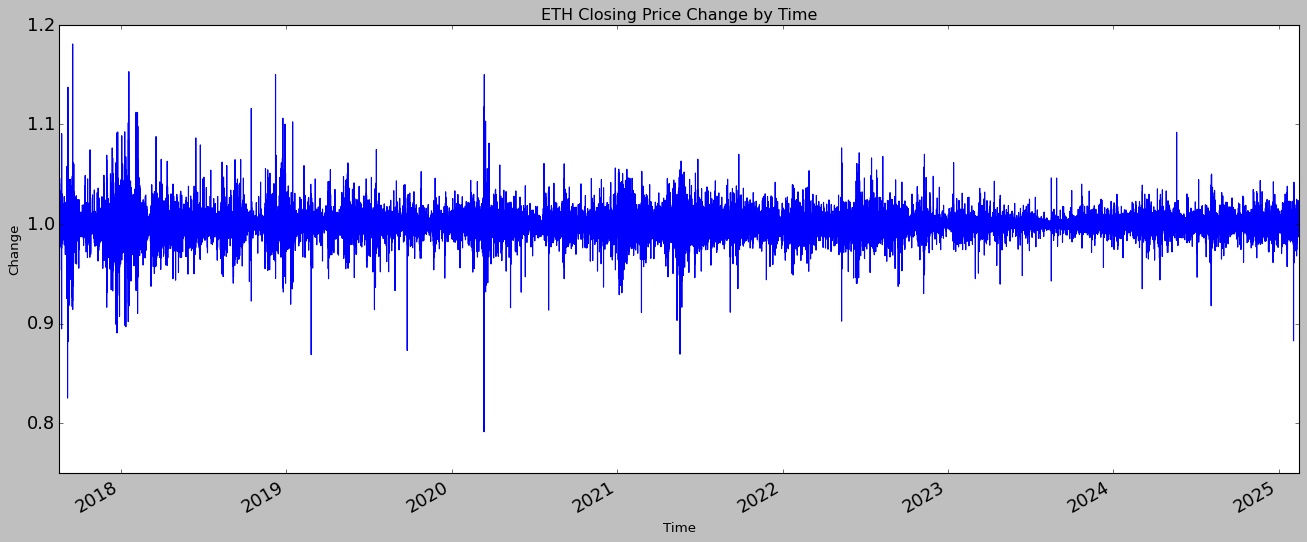

In [213]:
# Make copy of original eth dataset
vis_df = eth.copy()
# Adding change column in new dateset using shift
vis_df['change'] = vis_df.close.div(vis_df.close.shift())
# Plotting the change
vis_df['change'].plot(figsize=(20, 8), fontsize = 16)
plt.xlabel('Time')
plt.ylabel('Change')
plt.title('ETH Closing Price Change by Time')
plt.show()

###**4.3.6 Plotting the Percentage Change**

In [293]:
# Resample new viz dataset by month
vis_month = vis_df[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']].resample('M').median()
# Calculate percentage change in new column
vis_month['pct_change'] = vis_month.close.pct_change()*100

<ipython-input-293-0d567c29ec39>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vis_month = vis_df[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']].resample('M').median()


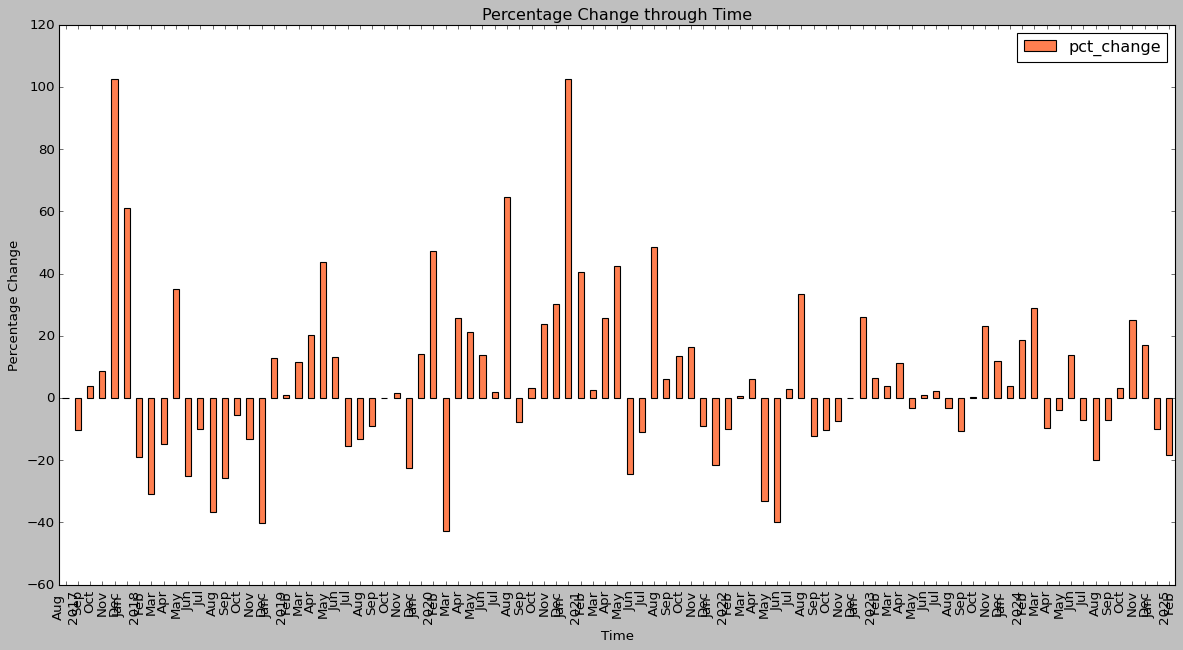

In [294]:
fig, ax = plt.subplots(figsize=(18, 10))
# Plot percentage change
vis_month['pct_change'].plot(kind='bar', color='coral', ax=ax)
# Set major ticks and tick labels
ax.set_xticks(range(vis_month.index.size))
ax.set_xticklabels([ts.strftime('%b\n%Y') if ts.year != vis_month.index[idx-1].year
                    else ts.strftime('%b') for idx, ts in enumerate(vis_month.index)])
ax.figure.autofmt_xdate(rotation=0, ha='center');
ax.set(xlabel='Time',
       ylabel='Percentage Change',
       title='Percentage Change through Time')
plt.xticks(rotation=90)
ax.legend()

###**4.3.7 Plotting the Decomposition**

<Figure size 1440x800 with 0 Axes>

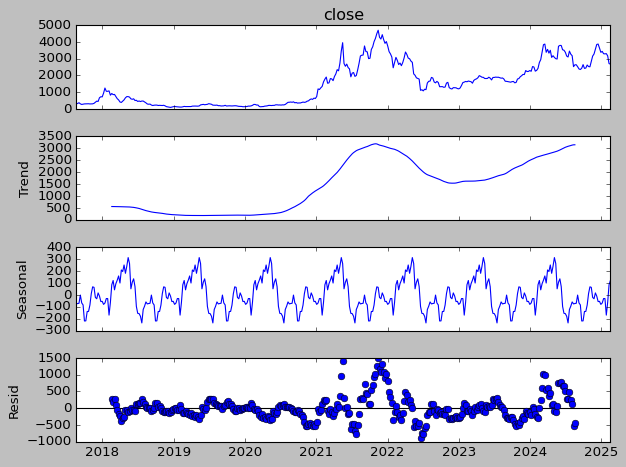

In [195]:
# Plot decomposition using statsmodel api
plt.figure(figsize=[18,10])
sm.tsa.seasonal_decompose(eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']].resample("W").median().close).plot()
plt.show()

In [196]:
# Add log to closing price
eth["close_log"] = np.log1p(eth.close)
eth.head()

unix   symbol    open    high    low   close  \
date                                                                         
2017-08-17 04:00:00  1502942400000  ETHUSDT  301.13  302.57  298.0  301.61   
2017-08-17 05:00:00  1502946000000  ETHUSDT  301.61  303.28  300.0  303.10   
2017-08-17 06:00:00  1502949600000  ETHUSDT  302.40  304.44  301.9  302.68   
2017-08-17 07:00:00  1502953200000  ETHUSDT  302.68  307.96  302.6  307.96   
2017-08-17 08:00:00  1502956800000  ETHUSDT  307.95  309.97  307.0  308.62   

                     volume ETH    volume USDT  tradecount  close_log  
date                                                                   
2017-08-17 04:00:00   125.66877   37684.804181         129   5.712445  
2017-08-17 05:00:00   377.67246  114043.282676         202   5.717357  
2017-08-17 06:00:00   303.86672   92034.441294         182   5.715975  
2017-08-17 07:00:00   754.74510  229725.136967         198   5.733212  
2017-08-17 08:00:00   150.75029   46559.462371         182   5.735346

<Figure size 1440x800 with 0 Axes>

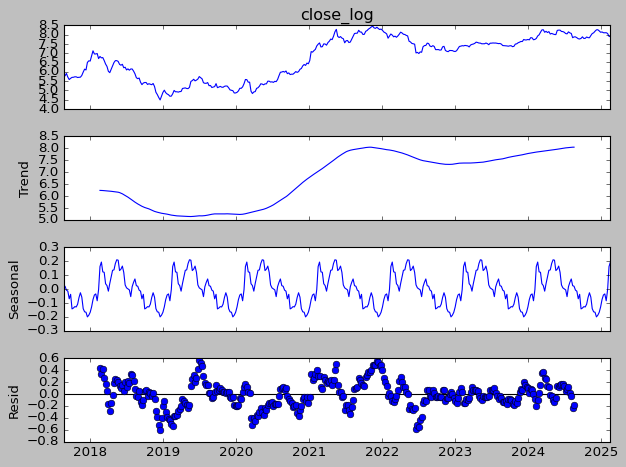

In [198]:
plt.figure(figsize=[18,10])
sm.tsa.seasonal_decompose(eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT','close_log']].resample("W").median().close_log).plot()
plt.show()

#**5 Statistical Tests**

## **5.1 Dickey-Fuller-Test**

In [199]:
dickey = sm.tsa.stattools.adfuller(eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT','close_log']].resample("W").mean().close)

print(f'ADF Statistic: {dickey[0]:.2f}')
print(f'p-value: {dickey[1]:.2f}')
print('Critical Values:')
for key, value in dickey[4].items():
        print(f'\t {key}: {value:.3f}')

ADF Statistic: -1.45
p-value: 0.56
Critical Values:
	 1%: -3.448
	 5%: -2.869
	 10%: -2.571


In [200]:
dickey = sm.tsa.stattools.adfuller(eth[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT','close_log']].resample("W").mean().close_log)

print(f'ADF Statistic: {dickey[0]:.2f}')
print(f'p-value: {dickey[1]:.2f}')
print('Critical Values:')
for key, value in dickey[4].items():
        print(f'\t {key}: {value:.3f}')

ADF Statistic: -1.16
p-value: 0.69
Critical Values:
	 1%: -3.447
	 5%: -2.869
	 10%: -2.571


# **6. Feature Engineering**

In [238]:
# Create main set to train and validate
# eth_main = eth.loc['2017-08-17':]
eth_main = eth.loc['2017-08-17':'2025-02-16']
eth_main.shape

(65642, 7)

In [295]:
eth_main.tail(50)

open     high      low    close  volume ETH  \
date                                                                  
2025-02-13 20:00:00  2640.94  2659.29  2640.50  2653.61   9408.9137   
2025-02-13 21:00:00  2653.60  2675.72  2651.49  2666.99  14287.2916   
2025-02-13 22:00:00  2667.00  2676.92  2662.94  2668.78   9206.9970   
2025-02-13 23:00:00  2668.79  2679.99  2664.10  2675.87   6430.7714   
2025-02-14 01:00:00  2675.27  2687.55  2669.00  2683.25   8900.0241   
2025-02-14 02:00:00  2683.25  2706.58  2680.00  2690.50  18126.1020   
2025-02-14 03:00:00  2690.51  2721.40  2689.11  2715.39  11401.1762   
2025-02-14 04:00:00  2715.39  2716.20  2696.58  2699.50   9725.4462   
2025-02-14 05:00:00  2699.50  2704.00  2689.43  2698.64   8365.6764   
2025-02-14 06:00:00  2698.64  2704.00  2692.00  2700.79  10209.2370   
2025-02-14 07:00:00  2700.80  2705.00  2698.84  2699.42  17465.9394   
2025-02-14 08:00:00  2699.41  2716.21  2695.68  2705.75  21331.9984   
2025-02-14 09:00:00  2705.74  2714.00  2703.97  2713.61  23956.9007   
2025-02-14 10:00:00  2713.61  2716.48  2702.28  2703.29   9761.1636   
2025-02-14 11:00:00  2703.29  2705.40  2682.42  2684.81  15440.9701   
2025-02-14 12:00:00  2684.80  2691.16  2677.43  2686.43  11457.3645   
2025-02-14 13:00:00  2686.43  2705.53  2684.61  2701.21  14263.7275   
2025-02-14 14:00:00  2701.21  2736.76  2693.81  2720.75  27134.7321   
2025-02-14 15:00:00  2720.75  2747.39  2688.79  2734.33  35876.0899   
2025-02-14 16:00:00  2734.33  2743.46  2709.61  2742.80  21900.8476   
2025-02-14 17:00:00  2742.80  2791.00  2731.61  2773.97  44612.7472   
2025-02-14 18:00:00  2773.96  2791.78  2754.78  2755.98  35065.9944   
2025-02-14 19:00:00  2755.97  2763.53  2728.37  2738.00  14862.4968   
2025-02-14 20:00:00  2738.00  2751.00  2721.16  2728.20  11674.7524   
2025-02-14 21:00:00  2728.20  2751.10  2706.00  2744.31  18485.3578   
2025-02-14 22:00:00  2744.31  2748.80  2707.40  2718.00  13454.8213   
2025-02-14 23:00:00  2718.00  2730.90  2714.90  2725.95   8334.0052   
2025-02-15 01:00:00  2716.59  2731.00  2714.60  2728.49   7807.4496   
2025-02-15 02:00:00  2728.49  2734.76  2720.96  2731.40   7973.7894   
2025-02-15 03:00:00  2731.40  2739.00  2723.14  2724.40   6949.3310   
2025-02-15 04:00:00  2724.41  2733.60  2717.60  2720.47   7007.3587   
2025-02-15 05:00:00  2720.47  2724.96  2715.69  2722.46   3679.4871   
2025-02-15 06:00:00  2722.47  2722.62  2705.00  2709.38   5109.6279   
2025-02-15 07:00:00  2709.38  2710.89  2694.00  2697.66  12568.9235   
2025-02-15 08:00:00  2697.65  2711.90  2697.13  2704.79   7411.2833   
2025-02-15 09:00:00  2704.80  2712.40  2696.04  2702.91   5566.4387   
2025-02-15 10:00:00  2702.91  2712.40  2695.70  2710.49   6323.4451   
2025-02-15 11:00:00  2710.49  2715.10  2700.00  2708.37  11928.5389   
2025-02-15 12:00:00  2708.37  2713.53  2703.60  2710.23   7049.2416   
2025-02-15 13:00:00  2710.23  2713.99  2705.90  2707.02   6207.2119   
2025-02-15 14:00:00  2707.02  2707.03  2662.28  2688.68  29405.7209   
2025-02-15 15:00:00  2688.69  2698.83  2683.99  2691.05   8821.6130   
2025-02-15 16:00:00  2691.05  2696.49  2682.48  2689.06   8315.2686   
2025-02-15 17:00:00  2689.06  2693.99  2679.00  2686.12   7856.8165   
2025-02-15 18:00:00  2686.12  2707.93  2685.01  2702.83   8995.2146   
2025-02-15 19:00:00  2702.84  2705.53  2690.49  2691.59   4673.7353   
2025-02-15 20:00:00  2691.60  2697.00  2679.16  2686.11   7481.7791   
2025-02-15 21:00:00  2686.10  2702.52  2685.80  2701.08   6190.2146   
2025-02-15 22:00:00  2701.09  2704.00  2687.61  2695.19   5686.3776   
2025-02-15 23:00:00  2695.20  2697.94  2690.00  2693.04   4286.4822   

                      volume USDT  close_log  
date                                          
2025-02-13 20:00:00  2.495453e+07   7.884053  
2025-02-13 21:00:00  3.807460e+07   7.889081  
2025-02-13 22:00:00  2.457193e+07   7.889751  
2025-02-13 23:00:00  1.717987e+07   7.892403  
2025-02-14 01:00:00  2.382292e+07   7.895157  
20

In [289]:
holdout = eth[0:0]

hours_in_year = 365 * 24

columns = ['date','open', 'high', 'low', 'close', 'volume ETH', 'volume USDT','close_log']

# Create a DataFrame with zeros
holdout = pd.DataFrame(0, index=range(hours_in_year), columns=columns)

holdout['date'] = pd.date_range(start='2025-02-16 00:00:00', periods=hours_in_year, freq='H')

holdout

<ipython-input-289-63f8a52ecfe9>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  holdout['date'] = pd.date_range(start='2025-02-16 00:00:00', periods=hours_in_year, freq='H')


date  open  high  low  close  volume ETH  volume USDT  \
0    2025-02-16 00:00:00     0     0    0      0           0            0   
1    2025-02-16 01:00:00     0     0    0      0           0            0   
2    2025-02-16 02:00:00     0     0    0      0           0            0   
3    2025-02-16 03:00:00     0     0    0      0           0            0   
4    2025-02-16 04:00:00     0     0    0      0           0            0   
...                  ...   ...   ...  ...    ...         ...          ...   
8755 2026-02-15 19:00:00     0     0    0      0           0            0   
8756 2026-02-15 20:00:00     0     0    0      0           0            0   
8757 2026-02-15 21:00:00     0     0    0      0           0            0   
8758 2026-02-15 22:00:00     0     0    0      0           0            0   
8759 2026-02-15 23:00:00     0     0    0      0           0            0   

      close_log  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
8755          0  
8756          0  
8757          0  
8758          0  
8759          0  

[8760 rows x 8 columns]

In [243]:
# Create my future holdout set


# Starting date and time
#start_datetime = pd.to_datetime('2025-02-16 00:00:00')

# Calculate the total number of hours in a year
#hours_in_year = 365 * 24

# Create the array
#holdout= np.zeros((hours_in_year, 8), dtype=object)

#for i in range(hours_in_year):
    #holdout[i, 0] = i + 1  # Hourly increment
    # Create a datetime object for the current hour
   # current_datetime = start_datetime + pd.DateOffset(hours=i)
   # holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
    # You can store the datetime object in another column if needed
    # For example, to store it in the second column:
    # hourly_data[i, 1] = current_datetime
    # Or, print it for demonstration:
    #print(current_datetime)

# Print the shape of the array to verify
# print(holdout.shape)

# Print a few rows to inspect the data
print(holdout[:10])





2025-02-16 00:00:00
2025-02-16 01:00:00
2025-02-16 02:00:00
2025-02-16 03:00:00
2025-02-16 04:00:00
2025-02-16 05:00:00
2025-02-16 06:00:00
2025-02-16 07:00:00
2025-02-16 08:00:00
2025-02-16 09:00:00
2025-02-16 10:00:00
2025-02-16 11:00:00
2025-02-16 12:00:00
2025-02-16 13:00:00
2025-02-16 14:00:00
2025-02-16 15:00:00
2025-02-16 16:00:00
2025-02-16 17:00:00
2025-02-16 18:00:00
2025-02-16 19:00:00
2025-02-16 20:00:00
2025-02-16 21:00:00
2025-02-16 22:00:00
2025-02-16 23:00:00
2025-02-17 00:00:00
2025-02-17 01:00:00
2025-02-17 02:00:00
2025-02-17 03:00:00
2025-02-17 04:00:00
2025-02-17 05:00:00
2025-02-17 06:00:00
2025-02-17 07:00:00
2025-02-17 08:00:00
2025-02-17 09:00:00
2025-02-17 10:00:00
2025-02-17 11:00:00
2025-02-17 12:00:00
2025-02-17 13:00:00
2025-02-17 14:00:00
2025-02-17 15:00:00
2025-02-17 16:00:00
2025-02-17 17:00:00
2025-02-17 18:00:00
2025-02-17 19:00:00
2025-02-17 20:00:00
2025-02-17 21:00:00
2025-02-17 22:00:00
2025-02-17 23:00:00
2025-02-18 00:00:00
2025-02-18 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-02-20 20:00:00
2025-02-20 21:00:00
2025-02-20 22:00:00
2025-02-20 23:00:00
2025-02-21 00:00:00
2025-02-21 01:00:00
2025-02-21 02:00:00
2025-02-21 03:00:00
2025-02-21 04:00:00
2025-02-21 05:00:00
2025-02-21 06:00:00
2025-02-21 07:00:00
2025-02-21 08:00:00
2025-02-21 09:00:00
2025-02-21 10:00:00
2025-02-21 11:00:00
2025-02-21 12:00:00
2025-02-21 13:00:00
2025-02-21 14:00:00
2025-02-21 15:00:00
2025-02-21 16:00:00
2025-02-21 17:00:00
2025-02-21 18:00:00
2025-02-21 19:00:00
2025-02-21 20:00:00
2025-02-21 21:00:00
2025-02-21 22:00:00
2025-02-21 23:00:00
2025-02-22 00:00:00
2025-02-22 01:00:00
2025-02-22 02:00:00
2025-02-22 03:00:00
2025-02-22 04:00:00
2025-02-22 05:00:00
2025-02-22 06:00:00
2025-02-22 07:00:00
2025-02-22 08:00:00
2025-02-22 09:00:00
2025-02-22 10:00:00
2025-02-22 11:00:00
2025-02-22 12:00:00
2025-02-22 13:00:00
2025-02-22 14:00:00
2025-02-22 15:00:00
2025-02-22 16:00:00
2025-02-22 17:00:00
2025-02-22 18:00:00
2025-02-22 19:00:00
2025-02-22 20:00:00
2025-02-22 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-02-23 17:00:00
2025-02-23 18:00:00
2025-02-23 19:00:00
2025-02-23 20:00:00
2025-02-23 21:00:00
2025-02-23 22:00:00
2025-02-23 23:00:00
2025-02-24 00:00:00
2025-02-24 01:00:00
2025-02-24 02:00:00
2025-02-24 03:00:00
2025-02-24 04:00:00
2025-02-24 05:00:00
2025-02-24 06:00:00
2025-02-24 07:00:00
2025-02-24 08:00:00
2025-02-24 09:00:00
2025-02-24 10:00:00
2025-02-24 11:00:00
2025-02-24 12:00:00
2025-02-24 13:00:00
2025-02-24 14:00:00
2025-02-24 15:00:00
2025-02-24 16:00:00
2025-02-24 17:00:00
2025-02-24 18:00:00
2025-02-24 19:00:00
2025-02-24 20:00:00
2025-02-24 21:00:00
2025-02-24 22:00:00
2025-02-24 23:00:00
2025-02-25 00:00:00
2025-02-25 01:00:00
2025-02-25 02:00:00
2025-02-25 03:00:00
2025-02-25 04:00:00
2025-02-25 05:00:00
2025-02-25 06:00:00
2025-02-25 07:00:00
2025-02-25 08:00:00
2025-02-25 09:00:00
2025-02-25 10:00:00
2025-02-25 11:00:00
2025-02-25 12:00:00
2025-02-25 13:00:00
2025-02-25 14:00:00
2025-02-25 15:00:00
2025-02-25 16:00:00
2025-02-25 17:00:00
2025-02-25 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-02-26 20:00:00
2025-02-26 21:00:00
2025-02-26 22:00:00
2025-02-26 23:00:00
2025-02-27 00:00:00
2025-02-27 01:00:00
2025-02-27 02:00:00
2025-02-27 03:00:00
2025-02-27 04:00:00
2025-02-27 05:00:00
2025-02-27 06:00:00
2025-02-27 07:00:00
2025-02-27 08:00:00
2025-02-27 09:00:00
2025-02-27 10:00:00
2025-02-27 11:00:00
2025-02-27 12:00:00
2025-02-27 13:00:00
2025-02-27 14:00:00
2025-02-27 15:00:00
2025-02-27 16:00:00
2025-02-27 17:00:00
2025-02-27 18:00:00
2025-02-27 19:00:00
2025-02-27 20:00:00
2025-02-27 21:00:00
2025-02-27 22:00:00
2025-02-27 23:00:00
2025-02-28 00:00:00
2025-02-28 01:00:00
2025-02-28 02:00:00
2025-02-28 03:00:00
2025-02-28 04:00:00
2025-02-28 05:00:00
2025-02-28 06:00:00
2025-02-28 07:00:00
2025-02-28 08:00:00
2025-02-28 09:00:00
2025-02-28 10:00:00
2025-02-28 11:00:00
2025-02-28 12:00:00
2025-02-28 13:00:00
2025-02-28 14:00:00
2025-02-28 15:00:00
2025-02-28 16:00:00
2025-02-28 17:00:00
2025-02-28 18:00:00
2025-02-28 19:00:00
2025-02-28 20:00:00
2025-02-28 21:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-01 04:00:00
2025-03-01 05:00:00
2025-03-01 06:00:00
2025-03-01 07:00:00
2025-03-01 08:00:00
2025-03-01 09:00:00
2025-03-01 10:00:00
2025-03-01 11:00:00
2025-03-01 12:00:00
2025-03-01 13:00:00
2025-03-01 14:00:00
2025-03-01 15:00:00
2025-03-01 16:00:00
2025-03-01 17:00:00
2025-03-01 18:00:00
2025-03-01 19:00:00
2025-03-01 20:00:00
2025-03-01 21:00:00
2025-03-01 22:00:00
2025-03-01 23:00:00
2025-03-02 00:00:00
2025-03-02 01:00:00
2025-03-02 02:00:00
2025-03-02 03:00:00
2025-03-02 04:00:00
2025-03-02 05:00:00
2025-03-02 06:00:00
2025-03-02 07:00:00
2025-03-02 08:00:00
2025-03-02 09:00:00
2025-03-02 10:00:00
2025-03-02 11:00:00
2025-03-02 12:00:00
2025-03-02 13:00:00
2025-03-02 14:00:00
2025-03-02 15:00:00
2025-03-02 16:00:00
2025-03-02 17:00:00
2025-03-02 18:00:00
2025-03-02 19:00:00
2025-03-02 20:00:00
2025-03-02 21:00:00
2025-03-02 22:00:00
2025-03-02 23:00:00
2025-03-03 00:00:00
2025-03-03 01:00:00
2025-03-03 02:00:00
2025-03-03 03:00:00
2025-03-03 04:00:00
2025-03-03 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-03 15:00:00
2025-03-03 16:00:00
2025-03-03 17:00:00
2025-03-03 18:00:00
2025-03-03 19:00:00
2025-03-03 20:00:00
2025-03-03 21:00:00
2025-03-03 22:00:00
2025-03-03 23:00:00
2025-03-04 00:00:00
2025-03-04 01:00:00
2025-03-04 02:00:00
2025-03-04 03:00:00
2025-03-04 04:00:00
2025-03-04 05:00:00
2025-03-04 06:00:00
2025-03-04 07:00:00
2025-03-04 08:00:00
2025-03-04 09:00:00
2025-03-04 10:00:00
2025-03-04 11:00:00
2025-03-04 12:00:00
2025-03-04 13:00:00
2025-03-04 14:00:00
2025-03-04 15:00:00
2025-03-04 16:00:00
2025-03-04 17:00:00
2025-03-04 18:00:00
2025-03-04 19:00:00
2025-03-04 20:00:00
2025-03-04 21:00:00
2025-03-04 22:00:00
2025-03-04 23:00:00
2025-03-05 00:00:00
2025-03-05 01:00:00
2025-03-05 02:00:00
2025-03-05 03:00:00
2025-03-05 04:00:00
2025-03-05 05:00:00
2025-03-05 06:00:00
2025-03-05 07:00:00
2025-03-05 08:00:00
2025-03-05 09:00:00
2025-03-05 10:00:00
2025-03-05 11:00:00
2025-03-05 12:00:00
2025-03-05 13:00:00
2025-03-05 14:00:00
2025-03-05 15:00:00
2025-03-05 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-06 02:00:00
2025-03-06 03:00:00
2025-03-06 04:00:00
2025-03-06 05:00:00
2025-03-06 06:00:00
2025-03-06 07:00:00
2025-03-06 08:00:00
2025-03-06 09:00:00
2025-03-06 10:00:00
2025-03-06 11:00:00
2025-03-06 12:00:00
2025-03-06 13:00:00
2025-03-06 14:00:00
2025-03-06 15:00:00
2025-03-06 16:00:00
2025-03-06 17:00:00
2025-03-06 18:00:00
2025-03-06 19:00:00
2025-03-06 20:00:00
2025-03-06 21:00:00
2025-03-06 22:00:00
2025-03-06 23:00:00
2025-03-07 00:00:00
2025-03-07 01:00:00
2025-03-07 02:00:00
2025-03-07 03:00:00
2025-03-07 04:00:00
2025-03-07 05:00:00
2025-03-07 06:00:00
2025-03-07 07:00:00
2025-03-07 08:00:00
2025-03-07 09:00:00
2025-03-07 10:00:00
2025-03-07 11:00:00
2025-03-07 12:00:00
2025-03-07 13:00:00
2025-03-07 14:00:00
2025-03-07 15:00:00
2025-03-07 16:00:00
2025-03-07 17:00:00
2025-03-07 18:00:00
2025-03-07 19:00:00
2025-03-07 20:00:00
2025-03-07 21:00:00
2025-03-07 22:00:00
2025-03-07 23:00:00
2025-03-08 00:00:00
2025-03-08 01:00:00
2025-03-08 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-08 03:00:00
2025-03-08 04:00:00
2025-03-08 05:00:00
2025-03-08 06:00:00
2025-03-08 07:00:00
2025-03-08 08:00:00
2025-03-08 09:00:00
2025-03-08 10:00:00
2025-03-08 11:00:00
2025-03-08 12:00:00
2025-03-08 13:00:00
2025-03-08 14:00:00
2025-03-08 15:00:00
2025-03-08 16:00:00
2025-03-08 17:00:00
2025-03-08 18:00:00
2025-03-08 19:00:00
2025-03-08 20:00:00
2025-03-08 21:00:00
2025-03-08 22:00:00
2025-03-08 23:00:00
2025-03-09 00:00:00
2025-03-09 01:00:00
2025-03-09 02:00:00
2025-03-09 03:00:00
2025-03-09 04:00:00
2025-03-09 05:00:00
2025-03-09 06:00:00
2025-03-09 07:00:00
2025-03-09 08:00:00
2025-03-09 09:00:00
2025-03-09 10:00:00
2025-03-09 11:00:00
2025-03-09 12:00:00
2025-03-09 13:00:00
2025-03-09 14:00:00
2025-03-09 15:00:00
2025-03-09 16:00:00
2025-03-09 17:00:00
2025-03-09 18:00:00
2025-03-09 19:00:00
2025-03-09 20:00:00
2025-03-09 21:00:00
2025-03-09 22:00:00
2025-03-09 23:00:00
2025-03-10 00:00:00
2025-03-10 01:00:00
2025-03-10 02:00:00
2025-03-10 03:00:00
2025-03-10 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-10 07:00:00
2025-03-10 08:00:00
2025-03-10 09:00:00
2025-03-10 10:00:00
2025-03-10 11:00:00
2025-03-10 12:00:00
2025-03-10 13:00:00
2025-03-10 14:00:00
2025-03-10 15:00:00
2025-03-10 16:00:00
2025-03-10 17:00:00
2025-03-10 18:00:00
2025-03-10 19:00:00
2025-03-10 20:00:00
2025-03-10 21:00:00
2025-03-10 22:00:00
2025-03-10 23:00:00
2025-03-11 00:00:00
2025-03-11 01:00:00
2025-03-11 02:00:00
2025-03-11 03:00:00
2025-03-11 04:00:00
2025-03-11 05:00:00
2025-03-11 06:00:00
2025-03-11 07:00:00
2025-03-11 08:00:00
2025-03-11 09:00:00
2025-03-11 10:00:00
2025-03-11 11:00:00
2025-03-11 12:00:00
2025-03-11 13:00:00
2025-03-11 14:00:00
2025-03-11 15:00:00
2025-03-11 16:00:00
2025-03-11 17:00:00
2025-03-11 18:00:00
2025-03-11 19:00:00
2025-03-11 20:00:00
2025-03-11 21:00:00
2025-03-11 22:00:00
2025-03-11 23:00:00
2025-03-12 00:00:00
2025-03-12 01:00:00
2025-03-12 02:00:00
2025-03-12 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-12 04:00:00
2025-03-12 05:00:00
2025-03-12 06:00:00
2025-03-12 07:00:00
2025-03-12 08:00:00
2025-03-12 09:00:00
2025-03-12 10:00:00
2025-03-12 11:00:00
2025-03-12 12:00:00
2025-03-12 13:00:00
2025-03-12 14:00:00
2025-03-12 15:00:00
2025-03-12 16:00:00
2025-03-12 17:00:00
2025-03-12 18:00:00
2025-03-12 19:00:00
2025-03-12 20:00:00
2025-03-12 21:00:00
2025-03-12 22:00:00
2025-03-12 23:00:00
2025-03-13 00:00:00
2025-03-13 01:00:00
2025-03-13 02:00:00
2025-03-13 03:00:00
2025-03-13 04:00:00
2025-03-13 05:00:00
2025-03-13 06:00:00
2025-03-13 07:00:00
2025-03-13 08:00:00
2025-03-13 09:00:00
2025-03-13 10:00:00
2025-03-13 11:00:00
2025-03-13 12:00:00
2025-03-13 13:00:00
2025-03-13 14:00:00
2025-03-13 15:00:00
2025-03-13 16:00:00
2025-03-13 17:00:00
2025-03-13 18:00:00
2025-03-13 19:00:00
2025-03-13 20:00:00
2025-03-13 21:00:00
2025-03-13 22:00:00
2025-03-13 23:00:00
2025-03-14 00:00:00
2025-03-14 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-14 02:00:00
2025-03-14 03:00:00
2025-03-14 04:00:00
2025-03-14 05:00:00
2025-03-14 06:00:00
2025-03-14 07:00:00
2025-03-14 08:00:00
2025-03-14 09:00:00
2025-03-14 10:00:00
2025-03-14 11:00:00
2025-03-14 12:00:00
2025-03-14 13:00:00
2025-03-14 14:00:00
2025-03-14 15:00:00
2025-03-14 16:00:00
2025-03-14 17:00:00
2025-03-14 18:00:00
2025-03-14 19:00:00
2025-03-14 20:00:00
2025-03-14 21:00:00
2025-03-14 22:00:00
2025-03-14 23:00:00
2025-03-15 00:00:00
2025-03-15 01:00:00
2025-03-15 02:00:00
2025-03-15 03:00:00
2025-03-15 04:00:00
2025-03-15 05:00:00
2025-03-15 06:00:00
2025-03-15 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-15 08:00:00
2025-03-15 09:00:00
2025-03-15 10:00:00
2025-03-15 11:00:00
2025-03-15 12:00:00
2025-03-15 13:00:00
2025-03-15 14:00:00
2025-03-15 15:00:00
2025-03-15 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-15 17:00:00
2025-03-15 18:00:00
2025-03-15 19:00:00
2025-03-15 20:00:00
2025-03-15 21:00:00
2025-03-15 22:00:00
2025-03-15 23:00:00
2025-03-16 00:00:00
2025-03-16 01:00:00
2025-03-16 02:00:00
2025-03-16 03:00:00
2025-03-16 04:00:00
2025-03-16 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-16 06:00:00
2025-03-16 07:00:00
2025-03-16 08:00:00
2025-03-16 09:00:00
2025-03-16 10:00:00
2025-03-16 11:00:00
2025-03-16 12:00:00
2025-03-16 13:00:00
2025-03-16 14:00:00
2025-03-16 15:00:00
2025-03-16 16:00:00
2025-03-16 17:00:00
2025-03-16 18:00:00
2025-03-16 19:00:00
2025-03-16 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-16 21:00:00
2025-03-16 22:00:00
2025-03-16 23:00:00
2025-03-17 00:00:00
2025-03-17 01:00:00
2025-03-17 02:00:00
2025-03-17 03:00:00
2025-03-17 04:00:00
2025-03-17 05:00:00
2025-03-17 06:00:00
2025-03-17 07:00:00
2025-03-17 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-17 09:00:00
2025-03-17 10:00:00
2025-03-17 11:00:00
2025-03-17 12:00:00
2025-03-17 13:00:00
2025-03-17 14:00:00
2025-03-17 15:00:00
2025-03-17 16:00:00
2025-03-17 17:00:00
2025-03-17 18:00:00
2025-03-17 19:00:00
2025-03-17 20:00:00
2025-03-17 21:00:00
2025-03-17 22:00:00
2025-03-17 23:00:00
2025-03-18 00:00:00
2025-03-18 01:00:00
2025-03-18 02:00:00
2025-03-18 03:00:00
2025-03-18 04:00:00
2025-03-18 05:00:00
2025-03-18 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-18 07:00:00
2025-03-18 08:00:00
2025-03-18 09:00:00
2025-03-18 10:00:00
2025-03-18 11:00:00
2025-03-18 12:00:00
2025-03-18 13:00:00
2025-03-18 14:00:00
2025-03-18 15:00:00
2025-03-18 16:00:00
2025-03-18 17:00:00
2025-03-18 18:00:00
2025-03-18 19:00:00
2025-03-18 20:00:00
2025-03-18 21:00:00
2025-03-18 22:00:00
2025-03-18 23:00:00
2025-03-19 00:00:00
2025-03-19 01:00:00
2025-03-19 02:00:00
2025-03-19 03:00:00
2025-03-19 04:00:00
2025-03-19 05:00:00
2025-03-19 06:00:00
2025-03-19 07:00:00
2025-03-19 08:00:00
2025-03-19 09:00:00
2025-03-19 10:00:00
2025-03-19 11:00:00
2025-03-19 12:00:00
2025-03-19 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-19 14:00:00
2025-03-19 15:00:00
2025-03-19 16:00:00
2025-03-19 17:00:00
2025-03-19 18:00:00
2025-03-19 19:00:00
2025-03-19 20:00:00
2025-03-19 21:00:00
2025-03-19 22:00:00
2025-03-19 23:00:00
2025-03-20 00:00:00
2025-03-20 01:00:00
2025-03-20 02:00:00
2025-03-20 03:00:00
2025-03-20 04:00:00
2025-03-20 05:00:00
2025-03-20 06:00:00
2025-03-20 07:00:00
2025-03-20 08:00:00
2025-03-20 09:00:00
2025-03-20 10:00:00
2025-03-20 11:00:00
2025-03-20 12:00:00
2025-03-20 13:00:00
2025-03-20 14:00:00
2025-03-20 15:00:00
2025-03-20 16:00:00
2025-03-20 17:00:00
2025-03-20 18:00:00
2025-03-20 19:00:00
2025-03-20 20:00:00
2025-03-20 21:00:00
2025-03-20 22:00:00
2025-03-20 23:00:00
2025-03-21 00:00:00
2025-03-21 01:00:00
2025-03-21 02:00:00
2025-03-21 03:00:00
2025-03-21 04:00:00
2025-03-21 05:00:00
2025-03-21 06:00:00
2025-03-21 07:00:00
2025-03-21 08:00:00
2025-03-21 09:00:00
2025-03-21 10:00:00
2025-03-21 11:00:00
2025-03-21 12:00:00
2025-03-21 13:00:00
2025-03-21 14:00:00
2025-03-21 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-22 08:00:00
2025-03-22 09:00:00
2025-03-22 10:00:00
2025-03-22 11:00:00
2025-03-22 12:00:00
2025-03-22 13:00:00
2025-03-22 14:00:00
2025-03-22 15:00:00
2025-03-22 16:00:00
2025-03-22 17:00:00
2025-03-22 18:00:00
2025-03-22 19:00:00
2025-03-22 20:00:00
2025-03-22 21:00:00
2025-03-22 22:00:00
2025-03-22 23:00:00
2025-03-23 00:00:00
2025-03-23 01:00:00
2025-03-23 02:00:00
2025-03-23 03:00:00
2025-03-23 04:00:00
2025-03-23 05:00:00
2025-03-23 06:00:00
2025-03-23 07:00:00
2025-03-23 08:00:00
2025-03-23 09:00:00
2025-03-23 10:00:00
2025-03-23 11:00:00
2025-03-23 12:00:00
2025-03-23 13:00:00
2025-03-23 14:00:00
2025-03-23 15:00:00
2025-03-23 16:00:00
2025-03-23 17:00:00
2025-03-23 18:00:00
2025-03-23 19:00:00
2025-03-23 20:00:00
2025-03-23 21:00:00
2025-03-23 22:00:00
2025-03-23 23:00:00
2025-03-24 00:00:00
2025-03-24 01:00:00
2025-03-24 02:00:00
2025-03-24 03:00:00
2025-03-24 04:00:00
2025-03-24 05:00:00
2025-03-24 06:00:00
2025-03-24 07:00:00
2025-03-24 08:00:00
2025-03-24 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-25 00:00:00
2025-03-25 01:00:00
2025-03-25 02:00:00
2025-03-25 03:00:00
2025-03-25 04:00:00
2025-03-25 05:00:00
2025-03-25 06:00:00
2025-03-25 07:00:00
2025-03-25 08:00:00
2025-03-25 09:00:00
2025-03-25 10:00:00
2025-03-25 11:00:00
2025-03-25 12:00:00
2025-03-25 13:00:00
2025-03-25 14:00:00
2025-03-25 15:00:00
2025-03-25 16:00:00
2025-03-25 17:00:00
2025-03-25 18:00:00
2025-03-25 19:00:00
2025-03-25 20:00:00
2025-03-25 21:00:00
2025-03-25 22:00:00
2025-03-25 23:00:00
2025-03-26 00:00:00
2025-03-26 01:00:00
2025-03-26 02:00:00
2025-03-26 03:00:00
2025-03-26 04:00:00
2025-03-26 05:00:00
2025-03-26 06:00:00
2025-03-26 07:00:00
2025-03-26 08:00:00
2025-03-26 09:00:00
2025-03-26 10:00:00
2025-03-26 11:00:00
2025-03-26 12:00:00
2025-03-26 13:00:00
2025-03-26 14:00:00
2025-03-26 15:00:00
2025-03-26 16:00:00
2025-03-26 17:00:00
2025-03-26 18:00:00
2025-03-26 19:00:00
2025-03-26 20:00:00
2025-03-26 21:00:00
2025-03-26 22:00:00
2025-03-26 23:00:00
2025-03-27 00:00:00
2025-03-27 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-27 11:00:00
2025-03-27 12:00:00
2025-03-27 13:00:00
2025-03-27 14:00:00
2025-03-27 15:00:00
2025-03-27 16:00:00
2025-03-27 17:00:00
2025-03-27 18:00:00
2025-03-27 19:00:00
2025-03-27 20:00:00
2025-03-27 21:00:00
2025-03-27 22:00:00
2025-03-27 23:00:00
2025-03-28 00:00:00
2025-03-28 01:00:00
2025-03-28 02:00:00
2025-03-28 03:00:00
2025-03-28 04:00:00
2025-03-28 05:00:00
2025-03-28 06:00:00
2025-03-28 07:00:00
2025-03-28 08:00:00
2025-03-28 09:00:00
2025-03-28 10:00:00
2025-03-28 11:00:00
2025-03-28 12:00:00
2025-03-28 13:00:00
2025-03-28 14:00:00
2025-03-28 15:00:00
2025-03-28 16:00:00
2025-03-28 17:00:00
2025-03-28 18:00:00
2025-03-28 19:00:00
2025-03-28 20:00:00
2025-03-28 21:00:00
2025-03-28 22:00:00
2025-03-28 23:00:00
2025-03-29 00:00:00
2025-03-29 01:00:00
2025-03-29 02:00:00
2025-03-29 03:00:00
2025-03-29 04:00:00
2025-03-29 05:00:00
2025-03-29 06:00:00
2025-03-29 07:00:00
2025-03-29 08:00:00
2025-03-29 09:00:00
2025-03-29 10:00:00
2025-03-29 11:00:00
2025-03-29 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-03-30 01:00:00
2025-03-30 02:00:00
2025-03-30 03:00:00
2025-03-30 04:00:00
2025-03-30 05:00:00
2025-03-30 06:00:00
2025-03-30 07:00:00
2025-03-30 08:00:00
2025-03-30 09:00:00
2025-03-30 10:00:00
2025-03-30 11:00:00
2025-03-30 12:00:00
2025-03-30 13:00:00
2025-03-30 14:00:00
2025-03-30 15:00:00
2025-03-30 16:00:00
2025-03-30 17:00:00
2025-03-30 18:00:00
2025-03-30 19:00:00
2025-03-30 20:00:00
2025-03-30 21:00:00
2025-03-30 22:00:00
2025-03-30 23:00:00
2025-03-31 00:00:00
2025-03-31 01:00:00
2025-03-31 02:00:00
2025-03-31 03:00:00
2025-03-31 04:00:00
2025-03-31 05:00:00
2025-03-31 06:00:00
2025-03-31 07:00:00
2025-03-31 08:00:00
2025-03-31 09:00:00
2025-03-31 10:00:00
2025-03-31 11:00:00
2025-03-31 12:00:00
2025-03-31 13:00:00
2025-03-31 14:00:00
2025-03-31 15:00:00
2025-03-31 16:00:00
2025-03-31 17:00:00
2025-03-31 18:00:00
2025-03-31 19:00:00
2025-03-31 20:00:00
2025-03-31 21:00:00
2025-03-31 22:00:00
2025-03-31 23:00:00
2025-04-01 00:00:00
2025-04-01 01:00:00
2025-04-01 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-01 09:00:00
2025-04-01 10:00:00
2025-04-01 11:00:00
2025-04-01 12:00:00
2025-04-01 13:00:00
2025-04-01 14:00:00
2025-04-01 15:00:00
2025-04-01 16:00:00
2025-04-01 17:00:00
2025-04-01 18:00:00
2025-04-01 19:00:00
2025-04-01 20:00:00
2025-04-01 21:00:00
2025-04-01 22:00:00
2025-04-01 23:00:00
2025-04-02 00:00:00
2025-04-02 01:00:00
2025-04-02 02:00:00
2025-04-02 03:00:00
2025-04-02 04:00:00
2025-04-02 05:00:00
2025-04-02 06:00:00
2025-04-02 07:00:00
2025-04-02 08:00:00
2025-04-02 09:00:00
2025-04-02 10:00:00
2025-04-02 11:00:00
2025-04-02 12:00:00
2025-04-02 13:00:00
2025-04-02 14:00:00
2025-04-02 15:00:00
2025-04-02 16:00:00
2025-04-02 17:00:00
2025-04-02 18:00:00
2025-04-02 19:00:00
2025-04-02 20:00:00
2025-04-02 21:00:00
2025-04-02 22:00:00
2025-04-02 23:00:00
2025-04-03 00:00:00
2025-04-03 01:00:00
2025-04-03 02:00:00
2025-04-03 03:00:00
2025-04-03 04:00:00
2025-04-03 05:00:00
2025-04-03 06:00:00
2025-04-03 07:00:00
2025-04-03 08:00:00
2025-04-03 09:00:00
2025-04-03 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-03 16:00:00
2025-04-03 17:00:00
2025-04-03 18:00:00
2025-04-03 19:00:00
2025-04-03 20:00:00
2025-04-03 21:00:00
2025-04-03 22:00:00
2025-04-03 23:00:00
2025-04-04 00:00:00
2025-04-04 01:00:00
2025-04-04 02:00:00
2025-04-04 03:00:00
2025-04-04 04:00:00
2025-04-04 05:00:00
2025-04-04 06:00:00
2025-04-04 07:00:00
2025-04-04 08:00:00
2025-04-04 09:00:00
2025-04-04 10:00:00
2025-04-04 11:00:00
2025-04-04 12:00:00
2025-04-04 13:00:00
2025-04-04 14:00:00
2025-04-04 15:00:00
2025-04-04 16:00:00
2025-04-04 17:00:00
2025-04-04 18:00:00
2025-04-04 19:00:00
2025-04-04 20:00:00
2025-04-04 21:00:00
2025-04-04 22:00:00
2025-04-04 23:00:00
2025-04-05 00:00:00
2025-04-05 01:00:00
2025-04-05 02:00:00
2025-04-05 03:00:00
2025-04-05 04:00:00
2025-04-05 05:00:00
2025-04-05 06:00:00
2025-04-05 07:00:00
2025-04-05 08:00:00
2025-04-05 09:00:00
2025-04-05 10:00:00
2025-04-05 11:00:00
2025-04-05 12:00:00
2025-04-05 13:00:00
2025-04-05 14:00:00
2025-04-05 15:00:00
2025-04-05 16:00:00
2025-04-05 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-05 23:00:00
2025-04-06 00:00:00
2025-04-06 01:00:00
2025-04-06 02:00:00
2025-04-06 03:00:00
2025-04-06 04:00:00
2025-04-06 05:00:00
2025-04-06 06:00:00
2025-04-06 07:00:00
2025-04-06 08:00:00
2025-04-06 09:00:00
2025-04-06 10:00:00
2025-04-06 11:00:00
2025-04-06 12:00:00
2025-04-06 13:00:00
2025-04-06 14:00:00
2025-04-06 15:00:00
2025-04-06 16:00:00
2025-04-06 17:00:00
2025-04-06 18:00:00
2025-04-06 19:00:00
2025-04-06 20:00:00
2025-04-06 21:00:00
2025-04-06 22:00:00
2025-04-06 23:00:00
2025-04-07 00:00:00
2025-04-07 01:00:00
2025-04-07 02:00:00
2025-04-07 03:00:00
2025-04-07 04:00:00
2025-04-07 05:00:00
2025-04-07 06:00:00
2025-04-07 07:00:00
2025-04-07 08:00:00
2025-04-07 09:00:00
2025-04-07 10:00:00
2025-04-07 11:00:00
2025-04-07 12:00:00
2025-04-07 13:00:00
2025-04-07 14:00:00
2025-04-07 15:00:00
2025-04-07 16:00:00
2025-04-07 17:00:00
2025-04-07 18:00:00
2025-04-07 19:00:00
2025-04-07 20:00:00
2025-04-07 21:00:00
2025-04-07 22:00:00
2025-04-07 23:00:00
2025-04-08 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-08 04:00:00
2025-04-08 05:00:00
2025-04-08 06:00:00
2025-04-08 07:00:00
2025-04-08 08:00:00
2025-04-08 09:00:00
2025-04-08 10:00:00
2025-04-08 11:00:00
2025-04-08 12:00:00
2025-04-08 13:00:00
2025-04-08 14:00:00
2025-04-08 15:00:00
2025-04-08 16:00:00
2025-04-08 17:00:00
2025-04-08 18:00:00
2025-04-08 19:00:00
2025-04-08 20:00:00
2025-04-08 21:00:00
2025-04-08 22:00:00
2025-04-08 23:00:00
2025-04-09 00:00:00
2025-04-09 01:00:00
2025-04-09 02:00:00
2025-04-09 03:00:00
2025-04-09 04:00:00
2025-04-09 05:00:00
2025-04-09 06:00:00
2025-04-09 07:00:00
2025-04-09 08:00:00
2025-04-09 09:00:00
2025-04-09 10:00:00
2025-04-09 11:00:00
2025-04-09 12:00:00
2025-04-09 13:00:00
2025-04-09 14:00:00
2025-04-09 15:00:00
2025-04-09 16:00:00
2025-04-09 17:00:00
2025-04-09 18:00:00
2025-04-09 19:00:00
2025-04-09 20:00:00
2025-04-09 21:00:00
2025-04-09 22:00:00
2025-04-09 23:00:00
2025-04-10 00:00:00
2025-04-10 01:00:00
2025-04-10 02:00:00
2025-04-10 03:00:00
2025-04-10 04:00:00
2025-04-10 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-10 07:00:00
2025-04-10 08:00:00
2025-04-10 09:00:00
2025-04-10 10:00:00
2025-04-10 11:00:00
2025-04-10 12:00:00
2025-04-10 13:00:00
2025-04-10 14:00:00
2025-04-10 15:00:00
2025-04-10 16:00:00
2025-04-10 17:00:00
2025-04-10 18:00:00
2025-04-10 19:00:00
2025-04-10 20:00:00
2025-04-10 21:00:00
2025-04-10 22:00:00
2025-04-10 23:00:00
2025-04-11 00:00:00
2025-04-11 01:00:00
2025-04-11 02:00:00
2025-04-11 03:00:00
2025-04-11 04:00:00
2025-04-11 05:00:00
2025-04-11 06:00:00
2025-04-11 07:00:00
2025-04-11 08:00:00
2025-04-11 09:00:00
2025-04-11 10:00:00
2025-04-11 11:00:00
2025-04-11 12:00:00
2025-04-11 13:00:00
2025-04-11 14:00:00
2025-04-11 15:00:00
2025-04-11 16:00:00
2025-04-11 17:00:00
2025-04-11 18:00:00
2025-04-11 19:00:00
2025-04-11 20:00:00
2025-04-11 21:00:00
2025-04-11 22:00:00
2025-04-11 23:00:00
2025-04-12 00:00:00
2025-04-12 01:00:00
2025-04-12 02:00:00
2025-04-12 03:00:00
2025-04-12 04:00:00
2025-04-12 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-12 06:00:00
2025-04-12 07:00:00
2025-04-12 08:00:00
2025-04-12 09:00:00
2025-04-12 10:00:00
2025-04-12 11:00:00
2025-04-12 12:00:00
2025-04-12 13:00:00
2025-04-12 14:00:00
2025-04-12 15:00:00
2025-04-12 16:00:00
2025-04-12 17:00:00
2025-04-12 18:00:00
2025-04-12 19:00:00
2025-04-12 20:00:00
2025-04-12 21:00:00
2025-04-12 22:00:00
2025-04-12 23:00:00
2025-04-13 00:00:00
2025-04-13 01:00:00
2025-04-13 02:00:00
2025-04-13 03:00:00
2025-04-13 04:00:00
2025-04-13 05:00:00
2025-04-13 06:00:00
2025-04-13 07:00:00
2025-04-13 08:00:00
2025-04-13 09:00:00
2025-04-13 10:00:00
2025-04-13 11:00:00
2025-04-13 12:00:00
2025-04-13 13:00:00
2025-04-13 14:00:00
2025-04-13 15:00:00
2025-04-13 16:00:00
2025-04-13 17:00:00
2025-04-13 18:00:00
2025-04-13 19:00:00
2025-04-13 20:00:00
2025-04-13 21:00:00
2025-04-13 22:00:00
2025-04-13 23:00:00
2025-04-14 00:00:00
2025-04-14 01:00:00
2025-04-14 02:00:00
2025-04-14 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-14 04:00:00
2025-04-14 05:00:00
2025-04-14 06:00:00
2025-04-14 07:00:00
2025-04-14 08:00:00
2025-04-14 09:00:00
2025-04-14 10:00:00
2025-04-14 11:00:00
2025-04-14 12:00:00
2025-04-14 13:00:00
2025-04-14 14:00:00
2025-04-14 15:00:00
2025-04-14 16:00:00
2025-04-14 17:00:00
2025-04-14 18:00:00
2025-04-14 19:00:00
2025-04-14 20:00:00
2025-04-14 21:00:00
2025-04-14 22:00:00
2025-04-14 23:00:00
2025-04-15 00:00:00
2025-04-15 01:00:00
2025-04-15 02:00:00
2025-04-15 03:00:00
2025-04-15 04:00:00
2025-04-15 05:00:00
2025-04-15 06:00:00
2025-04-15 07:00:00
2025-04-15 08:00:00
2025-04-15 09:00:00
2025-04-15 10:00:00
2025-04-15 11:00:00
2025-04-15 12:00:00
2025-04-15 13:00:00
2025-04-15 14:00:00
2025-04-15 15:00:00
2025-04-15 16:00:00
2025-04-15 17:00:00
2025-04-15 18:00:00
2025-04-15 19:00:00
2025-04-15 20:00:00
2025-04-15 21:00:00
2025-04-15 22:00:00
2025-04-15 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-16 00:00:00
2025-04-16 01:00:00
2025-04-16 02:00:00
2025-04-16 03:00:00
2025-04-16 04:00:00
2025-04-16 05:00:00
2025-04-16 06:00:00
2025-04-16 07:00:00
2025-04-16 08:00:00
2025-04-16 09:00:00
2025-04-16 10:00:00
2025-04-16 11:00:00
2025-04-16 12:00:00
2025-04-16 13:00:00
2025-04-16 14:00:00
2025-04-16 15:00:00
2025-04-16 16:00:00
2025-04-16 17:00:00
2025-04-16 18:00:00
2025-04-16 19:00:00
2025-04-16 20:00:00
2025-04-16 21:00:00
2025-04-16 22:00:00
2025-04-16 23:00:00
2025-04-17 00:00:00
2025-04-17 01:00:00
2025-04-17 02:00:00
2025-04-17 03:00:00
2025-04-17 04:00:00
2025-04-17 05:00:00
2025-04-17 06:00:00
2025-04-17 07:00:00
2025-04-17 08:00:00
2025-04-17 09:00:00
2025-04-17 10:00:00
2025-04-17 11:00:00
2025-04-17 12:00:00
2025-04-17 13:00:00
2025-04-17 14:00:00
2025-04-17 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-17 16:00:00
2025-04-17 17:00:00
2025-04-17 18:00:00
2025-04-17 19:00:00
2025-04-17 20:00:00
2025-04-17 21:00:00
2025-04-17 22:00:00
2025-04-17 23:00:00
2025-04-18 00:00:00
2025-04-18 01:00:00
2025-04-18 02:00:00
2025-04-18 03:00:00
2025-04-18 04:00:00
2025-04-18 05:00:00
2025-04-18 06:00:00
2025-04-18 07:00:00
2025-04-18 08:00:00
2025-04-18 09:00:00
2025-04-18 10:00:00
2025-04-18 11:00:00
2025-04-18 12:00:00
2025-04-18 13:00:00
2025-04-18 14:00:00
2025-04-18 15:00:00
2025-04-18 16:00:00
2025-04-18 17:00:00
2025-04-18 18:00:00
2025-04-18 19:00:00
2025-04-18 20:00:00
2025-04-18 21:00:00
2025-04-18 22:00:00
2025-04-18 23:00:00
2025-04-19 00:00:00
2025-04-19 01:00:00
2025-04-19 02:00:00
2025-04-19 03:00:00
2025-04-19 04:00:00
2025-04-19 05:00:00
2025-04-19 06:00:00
2025-04-19 07:00:00
2025-04-19 08:00:00
2025-04-19 09:00:00
2025-04-19 10:00:00
2025-04-19 11:00:00
2025-04-19 12:00:00
2025-04-19 13:00:00
2025-04-19 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-19 15:00:00
2025-04-19 16:00:00
2025-04-19 17:00:00
2025-04-19 18:00:00
2025-04-19 19:00:00
2025-04-19 20:00:00
2025-04-19 21:00:00
2025-04-19 22:00:00
2025-04-19 23:00:00
2025-04-20 00:00:00
2025-04-20 01:00:00
2025-04-20 02:00:00
2025-04-20 03:00:00
2025-04-20 04:00:00
2025-04-20 05:00:00
2025-04-20 06:00:00
2025-04-20 07:00:00
2025-04-20 08:00:00
2025-04-20 09:00:00
2025-04-20 10:00:00
2025-04-20 11:00:00
2025-04-20 12:00:00
2025-04-20 13:00:00
2025-04-20 14:00:00
2025-04-20 15:00:00
2025-04-20 16:00:00
2025-04-20 17:00:00
2025-04-20 18:00:00
2025-04-20 19:00:00
2025-04-20 20:00:00
2025-04-20 21:00:00
2025-04-20 22:00:00
2025-04-20 23:00:00
2025-04-21 00:00:00
2025-04-21 01:00:00
2025-04-21 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-21 03:00:00
2025-04-21 04:00:00
2025-04-21 05:00:00
2025-04-21 06:00:00
2025-04-21 07:00:00
2025-04-21 08:00:00
2025-04-21 09:00:00
2025-04-21 10:00:00
2025-04-21 11:00:00
2025-04-21 12:00:00
2025-04-21 13:00:00
2025-04-21 14:00:00
2025-04-21 15:00:00
2025-04-21 16:00:00
2025-04-21 17:00:00
2025-04-21 18:00:00
2025-04-21 19:00:00
2025-04-21 20:00:00
2025-04-21 21:00:00
2025-04-21 22:00:00
2025-04-21 23:00:00
2025-04-22 00:00:00
2025-04-22 01:00:00
2025-04-22 02:00:00
2025-04-22 03:00:00
2025-04-22 04:00:00
2025-04-22 05:00:00
2025-04-22 06:00:00
2025-04-22 07:00:00
2025-04-22 08:00:00
2025-04-22 09:00:00
2025-04-22 10:00:00
2025-04-22 11:00:00
2025-04-22 12:00:00
2025-04-22 13:00:00
2025-04-22 14:00:00
2025-04-22 15:00:00
2025-04-22 16:00:00
2025-04-22 17:00:00
2025-04-22 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-22 19:00:00
2025-04-22 20:00:00
2025-04-22 21:00:00
2025-04-22 22:00:00
2025-04-22 23:00:00
2025-04-23 00:00:00
2025-04-23 01:00:00
2025-04-23 02:00:00
2025-04-23 03:00:00
2025-04-23 04:00:00
2025-04-23 05:00:00
2025-04-23 06:00:00
2025-04-23 07:00:00
2025-04-23 08:00:00
2025-04-23 09:00:00
2025-04-23 10:00:00
2025-04-23 11:00:00
2025-04-23 12:00:00
2025-04-23 13:00:00
2025-04-23 14:00:00
2025-04-23 15:00:00
2025-04-23 16:00:00
2025-04-23 17:00:00
2025-04-23 18:00:00
2025-04-23 19:00:00
2025-04-23 20:00:00
2025-04-23 21:00:00
2025-04-23 22:00:00
2025-04-23 23:00:00
2025-04-24 00:00:00
2025-04-24 01:00:00
2025-04-24 02:00:00
2025-04-24 03:00:00
2025-04-24 04:00:00
2025-04-24 05:00:00
2025-04-24 06:00:00
2025-04-24 07:00:00
2025-04-24 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-24 09:00:00
2025-04-24 10:00:00
2025-04-24 11:00:00
2025-04-24 12:00:00
2025-04-24 13:00:00
2025-04-24 14:00:00
2025-04-24 15:00:00
2025-04-24 16:00:00
2025-04-24 17:00:00
2025-04-24 18:00:00
2025-04-24 19:00:00
2025-04-24 20:00:00
2025-04-24 21:00:00
2025-04-24 22:00:00
2025-04-24 23:00:00
2025-04-25 00:00:00
2025-04-25 01:00:00
2025-04-25 02:00:00
2025-04-25 03:00:00
2025-04-25 04:00:00
2025-04-25 05:00:00
2025-04-25 06:00:00
2025-04-25 07:00:00
2025-04-25 08:00:00
2025-04-25 09:00:00
2025-04-25 10:00:00
2025-04-25 11:00:00
2025-04-25 12:00:00
2025-04-25 13:00:00
2025-04-25 14:00:00
2025-04-25 15:00:00
2025-04-25 16:00:00
2025-04-25 17:00:00
2025-04-25 18:00:00
2025-04-25 19:00:00
2025-04-25 20:00:00
2025-04-25 21:00:00
2025-04-25 22:00:00
2025-04-25 23:00:00
2025-04-26 00:00:00
2025-04-26 01:00:00
2025-04-26 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-26 03:00:00
2025-04-26 04:00:00
2025-04-26 05:00:00
2025-04-26 06:00:00
2025-04-26 07:00:00
2025-04-26 08:00:00
2025-04-26 09:00:00
2025-04-26 10:00:00
2025-04-26 11:00:00
2025-04-26 12:00:00
2025-04-26 13:00:00
2025-04-26 14:00:00
2025-04-26 15:00:00
2025-04-26 16:00:00
2025-04-26 17:00:00
2025-04-26 18:00:00
2025-04-26 19:00:00
2025-04-26 20:00:00
2025-04-26 21:00:00
2025-04-26 22:00:00
2025-04-26 23:00:00
2025-04-27 00:00:00
2025-04-27 01:00:00
2025-04-27 02:00:00
2025-04-27 03:00:00
2025-04-27 04:00:00
2025-04-27 05:00:00
2025-04-27 06:00:00
2025-04-27 07:00:00
2025-04-27 08:00:00
2025-04-27 09:00:00
2025-04-27 10:00:00
2025-04-27 11:00:00
2025-04-27 12:00:00
2025-04-27 13:00:00
2025-04-27 14:00:00
2025-04-27 15:00:00
2025-04-27 16:00:00
2025-04-27 17:00:00
2025-04-27 18:00:00
2025-04-27 19:00:00
2025-04-27 20:00:00
2025-04-27 21:00:00
2025-04-27 22:00:00
2025-04-27 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-28 00:00:00
2025-04-28 01:00:00
2025-04-28 02:00:00
2025-04-28 03:00:00
2025-04-28 04:00:00
2025-04-28 05:00:00
2025-04-28 06:00:00
2025-04-28 07:00:00
2025-04-28 08:00:00
2025-04-28 09:00:00
2025-04-28 10:00:00
2025-04-28 11:00:00
2025-04-28 12:00:00
2025-04-28 13:00:00
2025-04-28 14:00:00
2025-04-28 15:00:00
2025-04-28 16:00:00
2025-04-28 17:00:00
2025-04-28 18:00:00
2025-04-28 19:00:00
2025-04-28 20:00:00
2025-04-28 21:00:00
2025-04-28 22:00:00
2025-04-28 23:00:00
2025-04-29 00:00:00
2025-04-29 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-29 02:00:00
2025-04-29 03:00:00
2025-04-29 04:00:00
2025-04-29 05:00:00
2025-04-29 06:00:00
2025-04-29 07:00:00
2025-04-29 08:00:00
2025-04-29 09:00:00
2025-04-29 10:00:00
2025-04-29 11:00:00
2025-04-29 12:00:00
2025-04-29 13:00:00
2025-04-29 14:00:00
2025-04-29 15:00:00
2025-04-29 16:00:00
2025-04-29 17:00:00
2025-04-29 18:00:00
2025-04-29 19:00:00
2025-04-29 20:00:00
2025-04-29 21:00:00
2025-04-29 22:00:00
2025-04-29 23:00:00
2025-04-30 00:00:00
2025-04-30 01:00:00
2025-04-30 02:00:00
2025-04-30 03:00:00
2025-04-30 04:00:00
2025-04-30 05:00:00
2025-04-30 06:00:00
2025-04-30 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-04-30 08:00:00
2025-04-30 09:00:00
2025-04-30 10:00:00
2025-04-30 11:00:00
2025-04-30 12:00:00
2025-04-30 13:00:00
2025-04-30 14:00:00
2025-04-30 15:00:00
2025-04-30 16:00:00
2025-04-30 17:00:00
2025-04-30 18:00:00
2025-04-30 19:00:00
2025-04-30 20:00:00
2025-04-30 21:00:00
2025-04-30 22:00:00
2025-04-30 23:00:00
2025-05-01 00:00:00
2025-05-01 01:00:00
2025-05-01 02:00:00
2025-05-01 03:00:00
2025-05-01 04:00:00
2025-05-01 05:00:00
2025-05-01 06:00:00
2025-05-01 07:00:00
2025-05-01 08:00:00
2025-05-01 09:00:00
2025-05-01 10:00:00
2025-05-01 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-01 12:00:00
2025-05-01 13:00:00
2025-05-01 14:00:00
2025-05-01 15:00:00
2025-05-01 16:00:00
2025-05-01 17:00:00
2025-05-01 18:00:00
2025-05-01 19:00:00
2025-05-01 20:00:00
2025-05-01 21:00:00
2025-05-01 22:00:00
2025-05-01 23:00:00
2025-05-02 00:00:00
2025-05-02 01:00:00
2025-05-02 02:00:00
2025-05-02 03:00:00
2025-05-02 04:00:00
2025-05-02 05:00:00
2025-05-02 06:00:00
2025-05-02 07:00:00
2025-05-02 08:00:00
2025-05-02 09:00:00
2025-05-02 10:00:00
2025-05-02 11:00:00
2025-05-02 12:00:00
2025-05-02 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-02 14:00:00
2025-05-02 15:00:00
2025-05-02 16:00:00
2025-05-02 17:00:00
2025-05-02 18:00:00
2025-05-02 19:00:00
2025-05-02 20:00:00
2025-05-02 21:00:00
2025-05-02 22:00:00
2025-05-02 23:00:00
2025-05-03 00:00:00
2025-05-03 01:00:00
2025-05-03 02:00:00
2025-05-03 03:00:00
2025-05-03 04:00:00
2025-05-03 05:00:00
2025-05-03 06:00:00
2025-05-03 07:00:00
2025-05-03 08:00:00
2025-05-03 09:00:00
2025-05-03 10:00:00
2025-05-03 11:00:00
2025-05-03 12:00:00
2025-05-03 13:00:00
2025-05-03 14:00:00
2025-05-03 15:00:00
2025-05-03 16:00:00
2025-05-03 17:00:00
2025-05-03 18:00:00
2025-05-03 19:00:00
2025-05-03 20:00:00
2025-05-03 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-03 22:00:00
2025-05-03 23:00:00
2025-05-04 00:00:00
2025-05-04 01:00:00
2025-05-04 02:00:00
2025-05-04 03:00:00
2025-05-04 04:00:00
2025-05-04 05:00:00
2025-05-04 06:00:00
2025-05-04 07:00:00
2025-05-04 08:00:00
2025-05-04 09:00:00
2025-05-04 10:00:00
2025-05-04 11:00:00
2025-05-04 12:00:00
2025-05-04 13:00:00
2025-05-04 14:00:00
2025-05-04 15:00:00
2025-05-04 16:00:00
2025-05-04 17:00:00
2025-05-04 18:00:00
2025-05-04 19:00:00
2025-05-04 20:00:00
2025-05-04 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-04 22:00:00
2025-05-04 23:00:00
2025-05-05 00:00:00
2025-05-05 01:00:00
2025-05-05 02:00:00
2025-05-05 03:00:00
2025-05-05 04:00:00
2025-05-05 05:00:00
2025-05-05 06:00:00
2025-05-05 07:00:00
2025-05-05 08:00:00
2025-05-05 09:00:00
2025-05-05 10:00:00
2025-05-05 11:00:00
2025-05-05 12:00:00
2025-05-05 13:00:00
2025-05-05 14:00:00
2025-05-05 15:00:00
2025-05-05 16:00:00
2025-05-05 17:00:00
2025-05-05 18:00:00
2025-05-05 19:00:00
2025-05-05 20:00:00
2025-05-05 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-05 22:00:00
2025-05-05 23:00:00
2025-05-06 00:00:00
2025-05-06 01:00:00
2025-05-06 02:00:00
2025-05-06 03:00:00
2025-05-06 04:00:00
2025-05-06 05:00:00
2025-05-06 06:00:00
2025-05-06 07:00:00
2025-05-06 08:00:00
2025-05-06 09:00:00
2025-05-06 10:00:00
2025-05-06 11:00:00
2025-05-06 12:00:00
2025-05-06 13:00:00
2025-05-06 14:00:00
2025-05-06 15:00:00
2025-05-06 16:00:00
2025-05-06 17:00:00
2025-05-06 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-06 19:00:00
2025-05-06 20:00:00
2025-05-06 21:00:00
2025-05-06 22:00:00
2025-05-06 23:00:00
2025-05-07 00:00:00
2025-05-07 01:00:00
2025-05-07 02:00:00
2025-05-07 03:00:00
2025-05-07 04:00:00
2025-05-07 05:00:00
2025-05-07 06:00:00
2025-05-07 07:00:00
2025-05-07 08:00:00
2025-05-07 09:00:00
2025-05-07 10:00:00
2025-05-07 11:00:00
2025-05-07 12:00:00
2025-05-07 13:00:00
2025-05-07 14:00:00
2025-05-07 15:00:00
2025-05-07 16:00:00
2025-05-07 17:00:00
2025-05-07 18:00:00
2025-05-07 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-07 20:00:00
2025-05-07 21:00:00
2025-05-07 22:00:00
2025-05-07 23:00:00
2025-05-08 00:00:00
2025-05-08 01:00:00
2025-05-08 02:00:00
2025-05-08 03:00:00
2025-05-08 04:00:00
2025-05-08 05:00:00
2025-05-08 06:00:00
2025-05-08 07:00:00
2025-05-08 08:00:00
2025-05-08 09:00:00
2025-05-08 10:00:00
2025-05-08 11:00:00
2025-05-08 12:00:00
2025-05-08 13:00:00
2025-05-08 14:00:00
2025-05-08 15:00:00
2025-05-08 16:00:00
2025-05-08 17:00:00
2025-05-08 18:00:00
2025-05-08 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-08 20:00:00
2025-05-08 21:00:00
2025-05-08 22:00:00
2025-05-08 23:00:00
2025-05-09 00:00:00
2025-05-09 01:00:00
2025-05-09 02:00:00
2025-05-09 03:00:00
2025-05-09 04:00:00
2025-05-09 05:00:00
2025-05-09 06:00:00
2025-05-09 07:00:00
2025-05-09 08:00:00
2025-05-09 09:00:00
2025-05-09 10:00:00
2025-05-09 11:00:00
2025-05-09 12:00:00
2025-05-09 13:00:00
2025-05-09 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-09 15:00:00
2025-05-09 16:00:00
2025-05-09 17:00:00
2025-05-09 18:00:00
2025-05-09 19:00:00
2025-05-09 20:00:00
2025-05-09 21:00:00
2025-05-09 22:00:00
2025-05-09 23:00:00
2025-05-10 00:00:00
2025-05-10 01:00:00
2025-05-10 02:00:00
2025-05-10 03:00:00
2025-05-10 04:00:00
2025-05-10 05:00:00
2025-05-10 06:00:00
2025-05-10 07:00:00
2025-05-10 08:00:00
2025-05-10 09:00:00
2025-05-10 10:00:00
2025-05-10 11:00:00
2025-05-10 12:00:00
2025-05-10 13:00:00
2025-05-10 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-10 15:00:00
2025-05-10 16:00:00
2025-05-10 17:00:00
2025-05-10 18:00:00
2025-05-10 19:00:00
2025-05-10 20:00:00
2025-05-10 21:00:00
2025-05-10 22:00:00
2025-05-10 23:00:00
2025-05-11 00:00:00
2025-05-11 01:00:00
2025-05-11 02:00:00
2025-05-11 03:00:00
2025-05-11 04:00:00
2025-05-11 05:00:00
2025-05-11 06:00:00
2025-05-11 07:00:00
2025-05-11 08:00:00
2025-05-11 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-11 10:00:00
2025-05-11 11:00:00
2025-05-11 12:00:00
2025-05-11 13:00:00
2025-05-11 14:00:00
2025-05-11 15:00:00
2025-05-11 16:00:00
2025-05-11 17:00:00
2025-05-11 18:00:00
2025-05-11 19:00:00
2025-05-11 20:00:00
2025-05-11 21:00:00
2025-05-11 22:00:00
2025-05-11 23:00:00
2025-05-12 00:00:00
2025-05-12 01:00:00
2025-05-12 02:00:00
2025-05-12 03:00:00
2025-05-12 04:00:00
2025-05-12 05:00:00
2025-05-12 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-12 07:00:00
2025-05-12 08:00:00
2025-05-12 09:00:00
2025-05-12 10:00:00
2025-05-12 11:00:00
2025-05-12 12:00:00
2025-05-12 13:00:00
2025-05-12 14:00:00
2025-05-12 15:00:00
2025-05-12 16:00:00
2025-05-12 17:00:00
2025-05-12 18:00:00
2025-05-12 19:00:00
2025-05-12 20:00:00
2025-05-12 21:00:00
2025-05-12 22:00:00
2025-05-12 23:00:00
2025-05-13 00:00:00
2025-05-13 01:00:00
2025-05-13 02:00:00
2025-05-13 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-13 04:00:00
2025-05-13 05:00:00
2025-05-13 06:00:00
2025-05-13 07:00:00
2025-05-13 08:00:00
2025-05-13 09:00:00
2025-05-13 10:00:00
2025-05-13 11:00:00
2025-05-13 12:00:00
2025-05-13 13:00:00
2025-05-13 14:00:00
2025-05-13 15:00:00
2025-05-13 16:00:00
2025-05-13 17:00:00
2025-05-13 18:00:00
2025-05-13 19:00:00
2025-05-13 20:00:00
2025-05-13 21:00:00
2025-05-13 22:00:00
2025-05-13 23:00:00
2025-05-14 00:00:00
2025-05-14 01:00:00
2025-05-14 02:00:00
2025-05-14 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-14 04:00:00
2025-05-14 05:00:00
2025-05-14 06:00:00
2025-05-14 07:00:00
2025-05-14 08:00:00
2025-05-14 09:00:00
2025-05-14 10:00:00
2025-05-14 11:00:00
2025-05-14 12:00:00
2025-05-14 13:00:00
2025-05-14 14:00:00
2025-05-14 15:00:00
2025-05-14 16:00:00
2025-05-14 17:00:00
2025-05-14 18:00:00
2025-05-14 19:00:00
2025-05-14 20:00:00
2025-05-14 21:00:00
2025-05-14 22:00:00
2025-05-14 23:00:00
2025-05-15 00:00:00
2025-05-15 01:00:00
2025-05-15 02:00:00
2025-05-15 03:00:00
2025-05-15 04:00:00
2025-05-15 05:00:00
2025-05-15 06:00:00
2025-05-15 07:00:00
2025-05-15 08:00:00
2025-05-15 09:00:00
2025-05-15 10:00:00
2025-05-15 11:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-05-15 12:00:00
2025-05-15 13:00:00
2025-05-15 14:00:00
2025-05-15 15:00:00
2025-05-15 16:00:00
2025-05-15 17:00:00
2025-05-15 18:00:00
2025-05-15 19:00:00
2025-05-15 20:00:00
2025-05-15 21:00:00
2025-05-15 22:00:00
2025-05-15 23:00:00
2025-05-16 00:00:00
2025-05-16 01:00:00
2025-05-16 02:00:00
2025-05-16 03:00:00
2025-05-16 04:00:00
2025-05-16 05:00:00
2025-05-16 06:00:00
2025-05-16 07:00:00
2025-05-16 08:00:00
2025-05-16 09:00:00
2025-05-16 10:00:00
2025-05-16 11:00:00
2025-05-16 12:00:00
2025-05-16 13:00:00
2025-05-16 14:00:00
2025-05-16 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-16 16:00:00
2025-05-16 17:00:00
2025-05-16 18:00:00
2025-05-16 19:00:00
2025-05-16 20:00:00
2025-05-16 21:00:00
2025-05-16 22:00:00
2025-05-16 23:00:00
2025-05-17 00:00:00
2025-05-17 01:00:00
2025-05-17 02:00:00
2025-05-17 03:00:00
2025-05-17 04:00:00
2025-05-17 05:00:00
2025-05-17 06:00:00
2025-05-17 07:00:00
2025-05-17 08:00:00
2025-05-17 09:00:00
2025-05-17 10:00:00
2025-05-17 11:00:00
2025-05-17 12:00:00
2025-05-17 13:00:00
2025-05-17 14:00:00
2025-05-17 15:00:00
2025-05-17 16:00:00
2025-05-17 17:00:00
2025-05-17 18:00:00
2025-05-17 19:00:00
2025-05-17 20:00:00
2025-05-17 21:00:00
2025-05-17 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-17 23:00:00
2025-05-18 00:00:00
2025-05-18 01:00:00
2025-05-18 02:00:00
2025-05-18 03:00:00
2025-05-18 04:00:00
2025-05-18 05:00:00
2025-05-18 06:00:00
2025-05-18 07:00:00
2025-05-18 08:00:00
2025-05-18 09:00:00
2025-05-18 10:00:00
2025-05-18 11:00:00
2025-05-18 12:00:00
2025-05-18 13:00:00
2025-05-18 14:00:00
2025-05-18 15:00:00
2025-05-18 16:00:00
2025-05-18 17:00:00
2025-05-18 18:00:00
2025-05-18 19:00:00
2025-05-18 20:00:00
2025-05-18 21:00:00
2025-05-18 22:00:00
2025-05-18 23:00:00
2025-05-19 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-19 01:00:00
2025-05-19 02:00:00
2025-05-19 03:00:00
2025-05-19 04:00:00
2025-05-19 05:00:00
2025-05-19 06:00:00
2025-05-19 07:00:00
2025-05-19 08:00:00
2025-05-19 09:00:00
2025-05-19 10:00:00
2025-05-19 11:00:00
2025-05-19 12:00:00
2025-05-19 13:00:00
2025-05-19 14:00:00
2025-05-19 15:00:00
2025-05-19 16:00:00
2025-05-19 17:00:00
2025-05-19 18:00:00
2025-05-19 19:00:00
2025-05-19 20:00:00
2025-05-19 21:00:00
2025-05-19 22:00:00
2025-05-19 23:00:00
2025-05-20 00:00:00
2025-05-20 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-20 02:00:00
2025-05-20 03:00:00
2025-05-20 04:00:00
2025-05-20 05:00:00
2025-05-20 06:00:00
2025-05-20 07:00:00
2025-05-20 08:00:00
2025-05-20 09:00:00
2025-05-20 10:00:00
2025-05-20 11:00:00
2025-05-20 12:00:00
2025-05-20 13:00:00
2025-05-20 14:00:00
2025-05-20 15:00:00
2025-05-20 16:00:00
2025-05-20 17:00:00
2025-05-20 18:00:00
2025-05-20 19:00:00
2025-05-20 20:00:00
2025-05-20 21:00:00
2025-05-20 22:00:00
2025-05-20 23:00:00
2025-05-21 00:00:00
2025-05-21 01:00:00
2025-05-21 02:00:00
2025-05-21 03:00:00
2025-05-21 04:00:00
2025-05-21 05:00:00
2025-05-21 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-21 07:00:00
2025-05-21 08:00:00
2025-05-21 09:00:00
2025-05-21 10:00:00
2025-05-21 11:00:00
2025-05-21 12:00:00
2025-05-21 13:00:00
2025-05-21 14:00:00
2025-05-21 15:00:00
2025-05-21 16:00:00
2025-05-21 17:00:00
2025-05-21 18:00:00
2025-05-21 19:00:00
2025-05-21 20:00:00
2025-05-21 21:00:00
2025-05-21 22:00:00
2025-05-21 23:00:00
2025-05-22 00:00:00
2025-05-22 01:00:00
2025-05-22 02:00:00
2025-05-22 03:00:00
2025-05-22 04:00:00
2025-05-22 05:00:00
2025-05-22 06:00:00
2025-05-22 07:00:00
2025-05-22 08:00:00
2025-05-22 09:00:00
2025-05-22 10:00:00
2025-05-22 11:00:00
2025-05-22 12:00:00
2025-05-22 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-22 14:00:00
2025-05-22 15:00:00
2025-05-22 16:00:00
2025-05-22 17:00:00
2025-05-22 18:00:00
2025-05-22 19:00:00
2025-05-22 20:00:00
2025-05-22 21:00:00
2025-05-22 22:00:00
2025-05-22 23:00:00
2025-05-23 00:00:00
2025-05-23 01:00:00
2025-05-23 02:00:00
2025-05-23 03:00:00
2025-05-23 04:00:00
2025-05-23 05:00:00
2025-05-23 06:00:00
2025-05-23 07:00:00
2025-05-23 08:00:00
2025-05-23 09:00:00
2025-05-23 10:00:00
2025-05-23 11:00:00
2025-05-23 12:00:00
2025-05-23 13:00:00
2025-05-23 14:00:00
2025-05-23 15:00:00
2025-05-23 16:00:00
2025-05-23 17:00:00
2025-05-23 18:00:00
2025-05-23 19:00:00
2025-05-23 20:00:00
2025-05-23 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-23 22:00:00
2025-05-23 23:00:00
2025-05-24 00:00:00
2025-05-24 01:00:00
2025-05-24 02:00:00
2025-05-24 03:00:00
2025-05-24 04:00:00
2025-05-24 05:00:00
2025-05-24 06:00:00
2025-05-24 07:00:00
2025-05-24 08:00:00
2025-05-24 09:00:00
2025-05-24 10:00:00
2025-05-24 11:00:00
2025-05-24 12:00:00
2025-05-24 13:00:00
2025-05-24 14:00:00
2025-05-24 15:00:00
2025-05-24 16:00:00
2025-05-24 17:00:00
2025-05-24 18:00:00
2025-05-24 19:00:00
2025-05-24 20:00:00
2025-05-24 21:00:00
2025-05-24 22:00:00
2025-05-24 23:00:00
2025-05-25 00:00:00
2025-05-25 01:00:00
2025-05-25 02:00:00
2025-05-25 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-25 04:00:00
2025-05-25 05:00:00
2025-05-25 06:00:00
2025-05-25 07:00:00
2025-05-25 08:00:00
2025-05-25 09:00:00
2025-05-25 10:00:00
2025-05-25 11:00:00
2025-05-25 12:00:00
2025-05-25 13:00:00
2025-05-25 14:00:00
2025-05-25 15:00:00
2025-05-25 16:00:00
2025-05-25 17:00:00
2025-05-25 18:00:00
2025-05-25 19:00:00
2025-05-25 20:00:00
2025-05-25 21:00:00
2025-05-25 22:00:00
2025-05-25 23:00:00
2025-05-26 00:00:00
2025-05-26 01:00:00
2025-05-26 02:00:00
2025-05-26 03:00:00
2025-05-26 04:00:00
2025-05-26 05:00:00
2025-05-26 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-26 07:00:00
2025-05-26 08:00:00
2025-05-26 09:00:00
2025-05-26 10:00:00
2025-05-26 11:00:00
2025-05-26 12:00:00
2025-05-26 13:00:00
2025-05-26 14:00:00
2025-05-26 15:00:00
2025-05-26 16:00:00
2025-05-26 17:00:00
2025-05-26 18:00:00
2025-05-26 19:00:00
2025-05-26 20:00:00
2025-05-26 21:00:00
2025-05-26 22:00:00
2025-05-26 23:00:00
2025-05-27 00:00:00
2025-05-27 01:00:00
2025-05-27 02:00:00
2025-05-27 03:00:00
2025-05-27 04:00:00
2025-05-27 05:00:00
2025-05-27 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-27 07:00:00
2025-05-27 08:00:00
2025-05-27 09:00:00
2025-05-27 10:00:00
2025-05-27 11:00:00
2025-05-27 12:00:00
2025-05-27 13:00:00
2025-05-27 14:00:00
2025-05-27 15:00:00
2025-05-27 16:00:00
2025-05-27 17:00:00
2025-05-27 18:00:00
2025-05-27 19:00:00
2025-05-27 20:00:00
2025-05-27 21:00:00
2025-05-27 22:00:00
2025-05-27 23:00:00
2025-05-28 00:00:00
2025-05-28 01:00:00
2025-05-28 02:00:00
2025-05-28 03:00:00
2025-05-28 04:00:00
2025-05-28 05:00:00
2025-05-28 06:00:00
2025-05-28 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-28 08:00:00
2025-05-28 09:00:00
2025-05-28 10:00:00
2025-05-28 11:00:00
2025-05-28 12:00:00
2025-05-28 13:00:00
2025-05-28 14:00:00
2025-05-28 15:00:00
2025-05-28 16:00:00
2025-05-28 17:00:00
2025-05-28 18:00:00
2025-05-28 19:00:00
2025-05-28 20:00:00
2025-05-28 21:00:00
2025-05-28 22:00:00
2025-05-28 23:00:00
2025-05-29 00:00:00
2025-05-29 01:00:00
2025-05-29 02:00:00
2025-05-29 03:00:00
2025-05-29 04:00:00
2025-05-29 05:00:00
2025-05-29 06:00:00
2025-05-29 07:00:00
2025-05-29 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-29 09:00:00
2025-05-29 10:00:00
2025-05-29 11:00:00
2025-05-29 12:00:00
2025-05-29 13:00:00
2025-05-29 14:00:00
2025-05-29 15:00:00
2025-05-29 16:00:00
2025-05-29 17:00:00
2025-05-29 18:00:00
2025-05-29 19:00:00
2025-05-29 20:00:00
2025-05-29 21:00:00
2025-05-29 22:00:00
2025-05-29 23:00:00
2025-05-30 00:00:00
2025-05-30 01:00:00
2025-05-30 02:00:00
2025-05-30 03:00:00
2025-05-30 04:00:00
2025-05-30 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-30 06:00:00
2025-05-30 07:00:00
2025-05-30 08:00:00
2025-05-30 09:00:00
2025-05-30 10:00:00
2025-05-30 11:00:00
2025-05-30 12:00:00
2025-05-30 13:00:00
2025-05-30 14:00:00
2025-05-30 15:00:00
2025-05-30 16:00:00
2025-05-30 17:00:00
2025-05-30 18:00:00
2025-05-30 19:00:00
2025-05-30 20:00:00
2025-05-30 21:00:00
2025-05-30 22:00:00
2025-05-30 23:00:00
2025-05-31 00:00:00
2025-05-31 01:00:00
2025-05-31 02:00:00
2025-05-31 03:00:00
2025-05-31 04:00:00
2025-05-31 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-05-31 06:00:00
2025-05-31 07:00:00
2025-05-31 08:00:00
2025-05-31 09:00:00
2025-05-31 10:00:00
2025-05-31 11:00:00
2025-05-31 12:00:00
2025-05-31 13:00:00
2025-05-31 14:00:00
2025-05-31 15:00:00
2025-05-31 16:00:00
2025-05-31 17:00:00
2025-05-31 18:00:00
2025-05-31 19:00:00
2025-05-31 20:00:00
2025-05-31 21:00:00
2025-05-31 22:00:00
2025-05-31 23:00:00
2025-06-01 00:00:00
2025-06-01 01:00:00
2025-06-01 02:00:00
2025-06-01 03:00:00
2025-06-01 04:00:00
2025-06-01 05:00:00
2025-06-01 06:00:00
2025-06-01 07:00:00
2025-06-01 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-01 09:00:00
2025-06-01 10:00:00
2025-06-01 11:00:00
2025-06-01 12:00:00
2025-06-01 13:00:00
2025-06-01 14:00:00
2025-06-01 15:00:00
2025-06-01 16:00:00
2025-06-01 17:00:00
2025-06-01 18:00:00
2025-06-01 19:00:00
2025-06-01 20:00:00
2025-06-01 21:00:00
2025-06-01 22:00:00
2025-06-01 23:00:00
2025-06-02 00:00:00
2025-06-02 01:00:00
2025-06-02 02:00:00
2025-06-02 03:00:00
2025-06-02 04:00:00
2025-06-02 05:00:00
2025-06-02 06:00:00
2025-06-02 07:00:00
2025-06-02 08:00:00
2025-06-02 09:00:00
2025-06-02 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-02 11:00:00
2025-06-02 12:00:00
2025-06-02 13:00:00
2025-06-02 14:00:00
2025-06-02 15:00:00
2025-06-02 16:00:00
2025-06-02 17:00:00
2025-06-02 18:00:00
2025-06-02 19:00:00
2025-06-02 20:00:00
2025-06-02 21:00:00
2025-06-02 22:00:00
2025-06-02 23:00:00
2025-06-03 00:00:00
2025-06-03 01:00:00
2025-06-03 02:00:00
2025-06-03 03:00:00
2025-06-03 04:00:00
2025-06-03 05:00:00
2025-06-03 06:00:00
2025-06-03 07:00:00
2025-06-03 08:00:00
2025-06-03 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-03 10:00:00
2025-06-03 11:00:00
2025-06-03 12:00:00
2025-06-03 13:00:00
2025-06-03 14:00:00
2025-06-03 15:00:00
2025-06-03 16:00:00
2025-06-03 17:00:00
2025-06-03 18:00:00
2025-06-03 19:00:00
2025-06-03 20:00:00
2025-06-03 21:00:00
2025-06-03 22:00:00
2025-06-03 23:00:00
2025-06-04 00:00:00
2025-06-04 01:00:00
2025-06-04 02:00:00
2025-06-04 03:00:00
2025-06-04 04:00:00
2025-06-04 05:00:00
2025-06-04 06:00:00
2025-06-04 07:00:00
2025-06-04 08:00:00
2025-06-04 09:00:00
2025-06-04 10:00:00
2025-06-04 11:00:00
2025-06-04 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-04 13:00:00
2025-06-04 14:00:00
2025-06-04 15:00:00
2025-06-04 16:00:00
2025-06-04 17:00:00
2025-06-04 18:00:00
2025-06-04 19:00:00
2025-06-04 20:00:00
2025-06-04 21:00:00
2025-06-04 22:00:00
2025-06-04 23:00:00
2025-06-05 00:00:00
2025-06-05 01:00:00
2025-06-05 02:00:00
2025-06-05 03:00:00
2025-06-05 04:00:00
2025-06-05 05:00:00
2025-06-05 06:00:00
2025-06-05 07:00:00
2025-06-05 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-05 09:00:00
2025-06-05 10:00:00
2025-06-05 11:00:00
2025-06-05 12:00:00
2025-06-05 13:00:00
2025-06-05 14:00:00
2025-06-05 15:00:00
2025-06-05 16:00:00
2025-06-05 17:00:00
2025-06-05 18:00:00
2025-06-05 19:00:00
2025-06-05 20:00:00
2025-06-05 21:00:00
2025-06-05 22:00:00
2025-06-05 23:00:00
2025-06-06 00:00:00
2025-06-06 01:00:00
2025-06-06 02:00:00
2025-06-06 03:00:00
2025-06-06 04:00:00
2025-06-06 05:00:00
2025-06-06 06:00:00
2025-06-06 07:00:00
2025-06-06 08:00:00
2025-06-06 09:00:00
2025-06-06 10:00:00
2025-06-06 11:00:00
2025-06-06 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-06 13:00:00
2025-06-06 14:00:00
2025-06-06 15:00:00
2025-06-06 16:00:00
2025-06-06 17:00:00
2025-06-06 18:00:00
2025-06-06 19:00:00
2025-06-06 20:00:00
2025-06-06 21:00:00
2025-06-06 22:00:00
2025-06-06 23:00:00
2025-06-07 00:00:00
2025-06-07 01:00:00
2025-06-07 02:00:00
2025-06-07 03:00:00
2025-06-07 04:00:00
2025-06-07 05:00:00
2025-06-07 06:00:00
2025-06-07 07:00:00
2025-06-07 08:00:00
2025-06-07 09:00:00
2025-06-07 10:00:00
2025-06-07 11:00:00
2025-06-07 12:00:00
2025-06-07 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-07 14:00:00
2025-06-07 15:00:00
2025-06-07 16:00:00
2025-06-07 17:00:00
2025-06-07 18:00:00
2025-06-07 19:00:00
2025-06-07 20:00:00
2025-06-07 21:00:00
2025-06-07 22:00:00
2025-06-07 23:00:00
2025-06-08 00:00:00
2025-06-08 01:00:00
2025-06-08 02:00:00
2025-06-08 03:00:00
2025-06-08 04:00:00
2025-06-08 05:00:00
2025-06-08 06:00:00
2025-06-08 07:00:00
2025-06-08 08:00:00
2025-06-08 09:00:00
2025-06-08 10:00:00
2025-06-08 11:00:00
2025-06-08 12:00:00
2025-06-08 13:00:00
2025-06-08 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-08 15:00:00
2025-06-08 16:00:00
2025-06-08 17:00:00
2025-06-08 18:00:00
2025-06-08 19:00:00
2025-06-08 20:00:00
2025-06-08 21:00:00
2025-06-08 22:00:00
2025-06-08 23:00:00
2025-06-09 00:00:00
2025-06-09 01:00:00
2025-06-09 02:00:00
2025-06-09 03:00:00
2025-06-09 04:00:00
2025-06-09 05:00:00
2025-06-09 06:00:00
2025-06-09 07:00:00
2025-06-09 08:00:00
2025-06-09 09:00:00
2025-06-09 10:00:00
2025-06-09 11:00:00
2025-06-09 12:00:00
2025-06-09 13:00:00
2025-06-09 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-09 15:00:00
2025-06-09 16:00:00
2025-06-09 17:00:00
2025-06-09 18:00:00
2025-06-09 19:00:00
2025-06-09 20:00:00
2025-06-09 21:00:00
2025-06-09 22:00:00
2025-06-09 23:00:00
2025-06-10 00:00:00
2025-06-10 01:00:00
2025-06-10 02:00:00
2025-06-10 03:00:00
2025-06-10 04:00:00
2025-06-10 05:00:00
2025-06-10 06:00:00
2025-06-10 07:00:00
2025-06-10 08:00:00
2025-06-10 09:00:00
2025-06-10 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-10 11:00:00
2025-06-10 12:00:00
2025-06-10 13:00:00
2025-06-10 14:00:00
2025-06-10 15:00:00
2025-06-10 16:00:00
2025-06-10 17:00:00
2025-06-10 18:00:00
2025-06-10 19:00:00
2025-06-10 20:00:00
2025-06-10 21:00:00
2025-06-10 22:00:00
2025-06-10 23:00:00
2025-06-11 00:00:00
2025-06-11 01:00:00
2025-06-11 02:00:00
2025-06-11 03:00:00
2025-06-11 04:00:00
2025-06-11 05:00:00
2025-06-11 06:00:00
2025-06-11 07:00:00
2025-06-11 08:00:00
2025-06-11 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-11 10:00:00
2025-06-11 11:00:00
2025-06-11 12:00:00
2025-06-11 13:00:00
2025-06-11 14:00:00
2025-06-11 15:00:00
2025-06-11 16:00:00
2025-06-11 17:00:00
2025-06-11 18:00:00
2025-06-11 19:00:00
2025-06-11 20:00:00
2025-06-11 21:00:00
2025-06-11 22:00:00
2025-06-11 23:00:00
2025-06-12 00:00:00
2025-06-12 01:00:00
2025-06-12 02:00:00
2025-06-12 03:00:00
2025-06-12 04:00:00
2025-06-12 05:00:00
2025-06-12 06:00:00
2025-06-12 07:00:00
2025-06-12 08:00:00
2025-06-12 09:00:00
2025-06-12 10:00:00
2025-06-12 11:00:00
2025-06-12 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-12 13:00:00
2025-06-12 14:00:00
2025-06-12 15:00:00
2025-06-12 16:00:00
2025-06-12 17:00:00
2025-06-12 18:00:00
2025-06-12 19:00:00
2025-06-12 20:00:00
2025-06-12 21:00:00
2025-06-12 22:00:00
2025-06-12 23:00:00
2025-06-13 00:00:00
2025-06-13 01:00:00
2025-06-13 02:00:00
2025-06-13 03:00:00
2025-06-13 04:00:00
2025-06-13 05:00:00
2025-06-13 06:00:00
2025-06-13 07:00:00
2025-06-13 08:00:00
2025-06-13 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-13 10:00:00
2025-06-13 11:00:00
2025-06-13 12:00:00
2025-06-13 13:00:00
2025-06-13 14:00:00
2025-06-13 15:00:00
2025-06-13 16:00:00
2025-06-13 17:00:00
2025-06-13 18:00:00
2025-06-13 19:00:00
2025-06-13 20:00:00
2025-06-13 21:00:00
2025-06-13 22:00:00
2025-06-13 23:00:00
2025-06-14 00:00:00
2025-06-14 01:00:00
2025-06-14 02:00:00
2025-06-14 03:00:00
2025-06-14 04:00:00
2025-06-14 05:00:00
2025-06-14 06:00:00
2025-06-14 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-14 08:00:00
2025-06-14 09:00:00
2025-06-14 10:00:00
2025-06-14 11:00:00
2025-06-14 12:00:00
2025-06-14 13:00:00
2025-06-14 14:00:00
2025-06-14 15:00:00
2025-06-14 16:00:00
2025-06-14 17:00:00
2025-06-14 18:00:00
2025-06-14 19:00:00
2025-06-14 20:00:00
2025-06-14 21:00:00
2025-06-14 22:00:00
2025-06-14 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-15 00:00:00
2025-06-15 01:00:00
2025-06-15 02:00:00
2025-06-15 03:00:00
2025-06-15 04:00:00
2025-06-15 05:00:00
2025-06-15 06:00:00
2025-06-15 07:00:00
2025-06-15 08:00:00
2025-06-15 09:00:00
2025-06-15 10:00:00
2025-06-15 11:00:00
2025-06-15 12:00:00
2025-06-15 13:00:00
2025-06-15 14:00:00
2025-06-15 15:00:00
2025-06-15 16:00:00
2025-06-15 17:00:00
2025-06-15 18:00:00
2025-06-15 19:00:00
2025-06-15 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-15 21:00:00
2025-06-15 22:00:00
2025-06-15 23:00:00
2025-06-16 00:00:00
2025-06-16 01:00:00
2025-06-16 02:00:00
2025-06-16 03:00:00
2025-06-16 04:00:00
2025-06-16 05:00:00
2025-06-16 06:00:00
2025-06-16 07:00:00
2025-06-16 08:00:00
2025-06-16 09:00:00
2025-06-16 10:00:00
2025-06-16 11:00:00
2025-06-16 12:00:00
2025-06-16 13:00:00
2025-06-16 14:00:00
2025-06-16 15:00:00
2025-06-16 16:00:00
2025-06-16 17:00:00
2025-06-16 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-16 19:00:00
2025-06-16 20:00:00
2025-06-16 21:00:00
2025-06-16 22:00:00
2025-06-16 23:00:00
2025-06-17 00:00:00
2025-06-17 01:00:00
2025-06-17 02:00:00
2025-06-17 03:00:00
2025-06-17 04:00:00
2025-06-17 05:00:00
2025-06-17 06:00:00
2025-06-17 07:00:00
2025-06-17 08:00:00
2025-06-17 09:00:00
2025-06-17 10:00:00
2025-06-17 11:00:00
2025-06-17 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-17 13:00:00
2025-06-17 14:00:00
2025-06-17 15:00:00
2025-06-17 16:00:00
2025-06-17 17:00:00
2025-06-17 18:00:00
2025-06-17 19:00:00
2025-06-17 20:00:00
2025-06-17 21:00:00
2025-06-17 22:00:00
2025-06-17 23:00:00
2025-06-18 00:00:00
2025-06-18 01:00:00
2025-06-18 02:00:00
2025-06-18 03:00:00
2025-06-18 04:00:00
2025-06-18 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-18 06:00:00
2025-06-18 07:00:00
2025-06-18 08:00:00
2025-06-18 09:00:00
2025-06-18 10:00:00
2025-06-18 11:00:00
2025-06-18 12:00:00
2025-06-18 13:00:00
2025-06-18 14:00:00
2025-06-18 15:00:00
2025-06-18 16:00:00
2025-06-18 17:00:00
2025-06-18 18:00:00
2025-06-18 19:00:00
2025-06-18 20:00:00
2025-06-18 21:00:00
2025-06-18 22:00:00
2025-06-18 23:00:00
2025-06-19 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-19 01:00:00
2025-06-19 02:00:00
2025-06-19 03:00:00
2025-06-19 04:00:00
2025-06-19 05:00:00
2025-06-19 06:00:00
2025-06-19 07:00:00
2025-06-19 08:00:00
2025-06-19 09:00:00
2025-06-19 10:00:00
2025-06-19 11:00:00
2025-06-19 12:00:00
2025-06-19 13:00:00
2025-06-19 14:00:00
2025-06-19 15:00:00
2025-06-19 16:00:00
2025-06-19 17:00:00
2025-06-19 18:00:00
2025-06-19 19:00:00
2025-06-19 20:00:00
2025-06-19 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-19 22:00:00
2025-06-19 23:00:00
2025-06-20 00:00:00
2025-06-20 01:00:00
2025-06-20 02:00:00
2025-06-20 03:00:00
2025-06-20 04:00:00
2025-06-20 05:00:00
2025-06-20 06:00:00
2025-06-20 07:00:00
2025-06-20 08:00:00
2025-06-20 09:00:00
2025-06-20 10:00:00
2025-06-20 11:00:00
2025-06-20 12:00:00
2025-06-20 13:00:00
2025-06-20 14:00:00
2025-06-20 15:00:00
2025-06-20 16:00:00
2025-06-20 17:00:00
2025-06-20 18:00:00
2025-06-20 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-20 20:00:00
2025-06-20 21:00:00
2025-06-20 22:00:00
2025-06-20 23:00:00
2025-06-21 00:00:00
2025-06-21 01:00:00
2025-06-21 02:00:00
2025-06-21 03:00:00
2025-06-21 04:00:00
2025-06-21 05:00:00
2025-06-21 06:00:00
2025-06-21 07:00:00
2025-06-21 08:00:00
2025-06-21 09:00:00
2025-06-21 10:00:00
2025-06-21 11:00:00
2025-06-21 12:00:00
2025-06-21 13:00:00
2025-06-21 14:00:00
2025-06-21 15:00:00
2025-06-21 16:00:00
2025-06-21 17:00:00
2025-06-21 18:00:00
2025-06-21 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-21 20:00:00
2025-06-21 21:00:00
2025-06-21 22:00:00
2025-06-21 23:00:00
2025-06-22 00:00:00
2025-06-22 01:00:00
2025-06-22 02:00:00
2025-06-22 03:00:00
2025-06-22 04:00:00
2025-06-22 05:00:00
2025-06-22 06:00:00
2025-06-22 07:00:00
2025-06-22 08:00:00
2025-06-22 09:00:00
2025-06-22 10:00:00
2025-06-22 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-22 12:00:00
2025-06-22 13:00:00
2025-06-22 14:00:00
2025-06-22 15:00:00
2025-06-22 16:00:00
2025-06-22 17:00:00
2025-06-22 18:00:00
2025-06-22 19:00:00
2025-06-22 20:00:00
2025-06-22 21:00:00
2025-06-22 22:00:00
2025-06-22 23:00:00
2025-06-23 00:00:00
2025-06-23 01:00:00
2025-06-23 02:00:00
2025-06-23 03:00:00
2025-06-23 04:00:00
2025-06-23 05:00:00
2025-06-23 06:00:00
2025-06-23 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-23 08:00:00
2025-06-23 09:00:00
2025-06-23 10:00:00
2025-06-23 11:00:00
2025-06-23 12:00:00
2025-06-23 13:00:00
2025-06-23 14:00:00
2025-06-23 15:00:00
2025-06-23 16:00:00
2025-06-23 17:00:00
2025-06-23 18:00:00
2025-06-23 19:00:00
2025-06-23 20:00:00
2025-06-23 21:00:00
2025-06-23 22:00:00
2025-06-23 23:00:00
2025-06-24 00:00:00
2025-06-24 01:00:00
2025-06-24 02:00:00
2025-06-24 03:00:00
2025-06-24 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-24 05:00:00
2025-06-24 06:00:00
2025-06-24 07:00:00
2025-06-24 08:00:00
2025-06-24 09:00:00
2025-06-24 10:00:00
2025-06-24 11:00:00
2025-06-24 12:00:00
2025-06-24 13:00:00
2025-06-24 14:00:00
2025-06-24 15:00:00
2025-06-24 16:00:00
2025-06-24 17:00:00
2025-06-24 18:00:00
2025-06-24 19:00:00
2025-06-24 20:00:00
2025-06-24 21:00:00
2025-06-24 22:00:00
2025-06-24 23:00:00
2025-06-25 00:00:00
2025-06-25 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-25 02:00:00
2025-06-25 03:00:00
2025-06-25 04:00:00
2025-06-25 05:00:00
2025-06-25 06:00:00
2025-06-25 07:00:00
2025-06-25 08:00:00
2025-06-25 09:00:00
2025-06-25 10:00:00
2025-06-25 11:00:00
2025-06-25 12:00:00
2025-06-25 13:00:00
2025-06-25 14:00:00
2025-06-25 15:00:00
2025-06-25 16:00:00
2025-06-25 17:00:00
2025-06-25 18:00:00
2025-06-25 19:00:00
2025-06-25 20:00:00
2025-06-25 21:00:00
2025-06-25 22:00:00
2025-06-25 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-26 00:00:00
2025-06-26 01:00:00
2025-06-26 02:00:00
2025-06-26 03:00:00
2025-06-26 04:00:00
2025-06-26 05:00:00
2025-06-26 06:00:00
2025-06-26 07:00:00
2025-06-26 08:00:00
2025-06-26 09:00:00
2025-06-26 10:00:00
2025-06-26 11:00:00
2025-06-26 12:00:00
2025-06-26 13:00:00
2025-06-26 14:00:00
2025-06-26 15:00:00
2025-06-26 16:00:00
2025-06-26 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-26 18:00:00
2025-06-26 19:00:00
2025-06-26 20:00:00
2025-06-26 21:00:00
2025-06-26 22:00:00
2025-06-26 23:00:00
2025-06-27 00:00:00
2025-06-27 01:00:00
2025-06-27 02:00:00
2025-06-27 03:00:00
2025-06-27 04:00:00
2025-06-27 05:00:00
2025-06-27 06:00:00
2025-06-27 07:00:00
2025-06-27 08:00:00
2025-06-27 09:00:00
2025-06-27 10:00:00
2025-06-27 11:00:00
2025-06-27 12:00:00
2025-06-27 13:00:00
2025-06-27 14:00:00
2025-06-27 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-27 16:00:00
2025-06-27 17:00:00
2025-06-27 18:00:00
2025-06-27 19:00:00
2025-06-27 20:00:00
2025-06-27 21:00:00
2025-06-27 22:00:00
2025-06-27 23:00:00
2025-06-28 00:00:00
2025-06-28 01:00:00
2025-06-28 02:00:00
2025-06-28 03:00:00
2025-06-28 04:00:00
2025-06-28 05:00:00
2025-06-28 06:00:00
2025-06-28 07:00:00
2025-06-28 08:00:00
2025-06-28 09:00:00
2025-06-28 10:00:00
2025-06-28 11:00:00
2025-06-28 12:00:00
2025-06-28 13:00:00
2025-06-28 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-28 15:00:00
2025-06-28 16:00:00
2025-06-28 17:00:00
2025-06-28 18:00:00
2025-06-28 19:00:00
2025-06-28 20:00:00
2025-06-28 21:00:00
2025-06-28 22:00:00
2025-06-28 23:00:00
2025-06-29 00:00:00
2025-06-29 01:00:00
2025-06-29 02:00:00
2025-06-29 03:00:00
2025-06-29 04:00:00
2025-06-29 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-29 06:00:00
2025-06-29 07:00:00
2025-06-29 08:00:00
2025-06-29 09:00:00
2025-06-29 10:00:00
2025-06-29 11:00:00
2025-06-29 12:00:00
2025-06-29 13:00:00
2025-06-29 14:00:00
2025-06-29 15:00:00
2025-06-29 16:00:00
2025-06-29 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-29 18:00:00
2025-06-29 19:00:00
2025-06-29 20:00:00
2025-06-29 21:00:00
2025-06-29 22:00:00
2025-06-29 23:00:00
2025-06-30 00:00:00
2025-06-30 01:00:00
2025-06-30 02:00:00
2025-06-30 03:00:00
2025-06-30 04:00:00
2025-06-30 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-30 06:00:00
2025-06-30 07:00:00
2025-06-30 08:00:00
2025-06-30 09:00:00
2025-06-30 10:00:00
2025-06-30 11:00:00
2025-06-30 12:00:00
2025-06-30 13:00:00
2025-06-30 14:00:00
2025-06-30 15:00:00
2025-06-30 16:00:00
2025-06-30 17:00:00
2025-06-30 18:00:00
2025-06-30 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-06-30 20:00:00
2025-06-30 21:00:00
2025-06-30 22:00:00
2025-06-30 23:00:00
2025-07-01 00:00:00
2025-07-01 01:00:00
2025-07-01 02:00:00
2025-07-01 03:00:00
2025-07-01 04:00:00
2025-07-01 05:00:00
2025-07-01 06:00:00
2025-07-01 07:00:00
2025-07-01 08:00:00
2025-07-01 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-01 10:00:00
2025-07-01 11:00:00
2025-07-01 12:00:00
2025-07-01 13:00:00
2025-07-01 14:00:00
2025-07-01 15:00:00
2025-07-01 16:00:00
2025-07-01 17:00:00
2025-07-01 18:00:00
2025-07-01 19:00:00
2025-07-01 20:00:00
2025-07-01 21:00:00
2025-07-01 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-01 23:00:00
2025-07-02 00:00:00
2025-07-02 01:00:00
2025-07-02 02:00:00
2025-07-02 03:00:00
2025-07-02 04:00:00
2025-07-02 05:00:00
2025-07-02 06:00:00
2025-07-02 07:00:00
2025-07-02 08:00:00
2025-07-02 09:00:00
2025-07-02 10:00:00
2025-07-02 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-02 12:00:00
2025-07-02 13:00:00
2025-07-02 14:00:00
2025-07-02 15:00:00
2025-07-02 16:00:00
2025-07-02 17:00:00
2025-07-02 18:00:00
2025-07-02 19:00:00
2025-07-02 20:00:00
2025-07-02 21:00:00
2025-07-02 22:00:00
2025-07-02 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-03 00:00:00
2025-07-03 01:00:00
2025-07-03 02:00:00
2025-07-03 03:00:00
2025-07-03 04:00:00
2025-07-03 05:00:00
2025-07-03 06:00:00
2025-07-03 07:00:00
2025-07-03 08:00:00
2025-07-03 09:00:00
2025-07-03 10:00:00
2025-07-03 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-03 12:00:00
2025-07-03 13:00:00
2025-07-03 14:00:00
2025-07-03 15:00:00
2025-07-03 16:00:00
2025-07-03 17:00:00
2025-07-03 18:00:00
2025-07-03 19:00:00
2025-07-03 20:00:00
2025-07-03 21:00:00
2025-07-03 22:00:00
2025-07-03 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-04 00:00:00
2025-07-04 01:00:00
2025-07-04 02:00:00
2025-07-04 03:00:00
2025-07-04 04:00:00
2025-07-04 05:00:00
2025-07-04 06:00:00
2025-07-04 07:00:00
2025-07-04 08:00:00
2025-07-04 09:00:00
2025-07-04 10:00:00
2025-07-04 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-04 12:00:00
2025-07-04 13:00:00
2025-07-04 14:00:00
2025-07-04 15:00:00
2025-07-04 16:00:00
2025-07-04 17:00:00
2025-07-04 18:00:00
2025-07-04 19:00:00
2025-07-04 20:00:00
2025-07-04 21:00:00
2025-07-04 22:00:00
2025-07-04 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-05 00:00:00
2025-07-05 01:00:00
2025-07-05 02:00:00
2025-07-05 03:00:00
2025-07-05 04:00:00
2025-07-05 05:00:00
2025-07-05 06:00:00
2025-07-05 07:00:00
2025-07-05 08:00:00
2025-07-05 09:00:00
2025-07-05 10:00:00
2025-07-05 11:00:00
2025-07-05 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-05 13:00:00
2025-07-05 14:00:00
2025-07-05 15:00:00
2025-07-05 16:00:00
2025-07-05 17:00:00
2025-07-05 18:00:00
2025-07-05 19:00:00
2025-07-05 20:00:00
2025-07-05 21:00:00
2025-07-05 22:00:00
2025-07-05 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-06 00:00:00
2025-07-06 01:00:00
2025-07-06 02:00:00
2025-07-06 03:00:00
2025-07-06 04:00:00
2025-07-06 05:00:00
2025-07-06 06:00:00
2025-07-06 07:00:00
2025-07-06 08:00:00
2025-07-06 09:00:00
2025-07-06 10:00:00
2025-07-06 11:00:00
2025-07-06 12:00:00
2025-07-06 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-06 14:00:00
2025-07-06 15:00:00
2025-07-06 16:00:00
2025-07-06 17:00:00
2025-07-06 18:00:00
2025-07-06 19:00:00
2025-07-06 20:00:00
2025-07-06 21:00:00
2025-07-06 22:00:00
2025-07-06 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-07 00:00:00
2025-07-07 01:00:00
2025-07-07 02:00:00
2025-07-07 03:00:00
2025-07-07 04:00:00
2025-07-07 05:00:00
2025-07-07 06:00:00
2025-07-07 07:00:00
2025-07-07 08:00:00
2025-07-07 09:00:00
2025-07-07 10:00:00
2025-07-07 11:00:00
2025-07-07 12:00:00
2025-07-07 13:00:00
2025-07-07 14:00:00
2025-07-07 15:00:00
2025-07-07 16:00:00
2025-07-07 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-07 18:00:00
2025-07-07 19:00:00
2025-07-07 20:00:00
2025-07-07 21:00:00
2025-07-07 22:00:00
2025-07-07 23:00:00
2025-07-08 00:00:00
2025-07-08 01:00:00
2025-07-08 02:00:00
2025-07-08 03:00:00
2025-07-08 04:00:00
2025-07-08 05:00:00
2025-07-08 06:00:00
2025-07-08 07:00:00
2025-07-08 08:00:00
2025-07-08 09:00:00
2025-07-08 10:00:00
2025-07-08 11:00:00
2025-07-08 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-08 13:00:00
2025-07-08 14:00:00
2025-07-08 15:00:00
2025-07-08 16:00:00
2025-07-08 17:00:00
2025-07-08 18:00:00
2025-07-08 19:00:00
2025-07-08 20:00:00
2025-07-08 21:00:00
2025-07-08 22:00:00
2025-07-08 23:00:00
2025-07-09 00:00:00
2025-07-09 01:00:00
2025-07-09 02:00:00
2025-07-09 03:00:00
2025-07-09 04:00:00
2025-07-09 05:00:00
2025-07-09 06:00:00
2025-07-09 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-09 08:00:00
2025-07-09 09:00:00
2025-07-09 10:00:00
2025-07-09 11:00:00
2025-07-09 12:00:00
2025-07-09 13:00:00
2025-07-09 14:00:00
2025-07-09 15:00:00
2025-07-09 16:00:00
2025-07-09 17:00:00
2025-07-09 18:00:00
2025-07-09 19:00:00
2025-07-09 20:00:00
2025-07-09 21:00:00
2025-07-09 22:00:00
2025-07-09 23:00:00
2025-07-10 00:00:00
2025-07-10 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-10 02:00:00
2025-07-10 03:00:00
2025-07-10 04:00:00
2025-07-10 05:00:00
2025-07-10 06:00:00
2025-07-10 07:00:00
2025-07-10 08:00:00
2025-07-10 09:00:00
2025-07-10 10:00:00
2025-07-10 11:00:00
2025-07-10 12:00:00
2025-07-10 13:00:00
2025-07-10 14:00:00
2025-07-10 15:00:00
2025-07-10 16:00:00
2025-07-10 17:00:00
2025-07-10 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-10 19:00:00
2025-07-10 20:00:00
2025-07-10 21:00:00
2025-07-10 22:00:00
2025-07-10 23:00:00
2025-07-11 00:00:00
2025-07-11 01:00:00
2025-07-11 02:00:00
2025-07-11 03:00:00
2025-07-11 04:00:00
2025-07-11 05:00:00
2025-07-11 06:00:00
2025-07-11 07:00:00
2025-07-11 08:00:00
2025-07-11 09:00:00
2025-07-11 10:00:00
2025-07-11 11:00:00
2025-07-11 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-11 13:00:00
2025-07-11 14:00:00
2025-07-11 15:00:00
2025-07-11 16:00:00
2025-07-11 17:00:00
2025-07-11 18:00:00
2025-07-11 19:00:00
2025-07-11 20:00:00
2025-07-11 21:00:00
2025-07-11 22:00:00
2025-07-11 23:00:00
2025-07-12 00:00:00
2025-07-12 01:00:00
2025-07-12 02:00:00
2025-07-12 03:00:00
2025-07-12 04:00:00
2025-07-12 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-12 06:00:00
2025-07-12 07:00:00
2025-07-12 08:00:00
2025-07-12 09:00:00
2025-07-12 10:00:00
2025-07-12 11:00:00
2025-07-12 12:00:00
2025-07-12 13:00:00
2025-07-12 14:00:00
2025-07-12 15:00:00
2025-07-12 16:00:00
2025-07-12 17:00:00
2025-07-12 18:00:00
2025-07-12 19:00:00
2025-07-12 20:00:00
2025-07-12 21:00:00
2025-07-12 22:00:00
2025-07-12 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-13 00:00:00
2025-07-13 01:00:00
2025-07-13 02:00:00
2025-07-13 03:00:00
2025-07-13 04:00:00
2025-07-13 05:00:00
2025-07-13 06:00:00
2025-07-13 07:00:00
2025-07-13 08:00:00
2025-07-13 09:00:00
2025-07-13 10:00:00
2025-07-13 11:00:00
2025-07-13 12:00:00
2025-07-13 13:00:00
2025-07-13 14:00:00
2025-07-13 15:00:00
2025-07-13 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-13 17:00:00
2025-07-13 18:00:00
2025-07-13 19:00:00
2025-07-13 20:00:00
2025-07-13 21:00:00
2025-07-13 22:00:00
2025-07-13 23:00:00
2025-07-14 00:00:00
2025-07-14 01:00:00
2025-07-14 02:00:00
2025-07-14 03:00:00
2025-07-14 04:00:00
2025-07-14 05:00:00
2025-07-14 06:00:00
2025-07-14 07:00:00
2025-07-14 08:00:00
2025-07-14 09:00:00
2025-07-14 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-14 11:00:00
2025-07-14 12:00:00
2025-07-14 13:00:00
2025-07-14 14:00:00
2025-07-14 15:00:00
2025-07-14 16:00:00
2025-07-14 17:00:00
2025-07-14 18:00:00
2025-07-14 19:00:00
2025-07-14 20:00:00
2025-07-14 21:00:00
2025-07-14 22:00:00
2025-07-14 23:00:00
2025-07-15 00:00:00
2025-07-15 01:00:00
2025-07-15 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-15 03:00:00
2025-07-15 04:00:00
2025-07-15 05:00:00
2025-07-15 06:00:00
2025-07-15 07:00:00
2025-07-15 08:00:00
2025-07-15 09:00:00
2025-07-15 10:00:00
2025-07-15 11:00:00
2025-07-15 12:00:00
2025-07-15 13:00:00
2025-07-15 14:00:00
2025-07-15 15:00:00
2025-07-15 16:00:00
2025-07-15 17:00:00
2025-07-15 18:00:00
2025-07-15 19:00:00
2025-07-15 20:00:00
2025-07-15 21:00:00
2025-07-15 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-15 23:00:00
2025-07-16 00:00:00
2025-07-16 01:00:00
2025-07-16 02:00:00
2025-07-16 03:00:00
2025-07-16 04:00:00
2025-07-16 05:00:00
2025-07-16 06:00:00
2025-07-16 07:00:00
2025-07-16 08:00:00
2025-07-16 09:00:00
2025-07-16 10:00:00
2025-07-16 11:00:00
2025-07-16 12:00:00
2025-07-16 13:00:00
2025-07-16 14:00:00
2025-07-16 15:00:00
2025-07-16 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-16 17:00:00
2025-07-16 18:00:00
2025-07-16 19:00:00
2025-07-16 20:00:00
2025-07-16 21:00:00
2025-07-16 22:00:00
2025-07-16 23:00:00
2025-07-17 00:00:00
2025-07-17 01:00:00
2025-07-17 02:00:00
2025-07-17 03:00:00
2025-07-17 04:00:00
2025-07-17 05:00:00
2025-07-17 06:00:00
2025-07-17 07:00:00
2025-07-17 08:00:00
2025-07-17 09:00:00
2025-07-17 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-17 11:00:00
2025-07-17 12:00:00
2025-07-17 13:00:00
2025-07-17 14:00:00
2025-07-17 15:00:00
2025-07-17 16:00:00
2025-07-17 17:00:00
2025-07-17 18:00:00
2025-07-17 19:00:00
2025-07-17 20:00:00
2025-07-17 21:00:00
2025-07-17 22:00:00
2025-07-17 23:00:00
2025-07-18 00:00:00
2025-07-18 01:00:00
2025-07-18 02:00:00
2025-07-18 03:00:00
2025-07-18 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-18 05:00:00
2025-07-18 06:00:00
2025-07-18 07:00:00
2025-07-18 08:00:00
2025-07-18 09:00:00
2025-07-18 10:00:00
2025-07-18 11:00:00
2025-07-18 12:00:00
2025-07-18 13:00:00
2025-07-18 14:00:00
2025-07-18 15:00:00
2025-07-18 16:00:00
2025-07-18 17:00:00
2025-07-18 18:00:00
2025-07-18 19:00:00
2025-07-18 20:00:00
2025-07-18 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-18 22:00:00
2025-07-18 23:00:00
2025-07-19 00:00:00
2025-07-19 01:00:00
2025-07-19 02:00:00
2025-07-19 03:00:00
2025-07-19 04:00:00
2025-07-19 05:00:00
2025-07-19 06:00:00
2025-07-19 07:00:00
2025-07-19 08:00:00
2025-07-19 09:00:00
2025-07-19 10:00:00
2025-07-19 11:00:00
2025-07-19 12:00:00
2025-07-19 13:00:00
2025-07-19 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-19 15:00:00
2025-07-19 16:00:00
2025-07-19 17:00:00
2025-07-19 18:00:00
2025-07-19 19:00:00
2025-07-19 20:00:00
2025-07-19 21:00:00
2025-07-19 22:00:00
2025-07-19 23:00:00
2025-07-20 00:00:00
2025-07-20 01:00:00
2025-07-20 02:00:00
2025-07-20 03:00:00
2025-07-20 04:00:00
2025-07-20 05:00:00
2025-07-20 06:00:00
2025-07-20 07:00:00
2025-07-20 08:00:00
2025-07-20 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-20 10:00:00
2025-07-20 11:00:00
2025-07-20 12:00:00
2025-07-20 13:00:00
2025-07-20 14:00:00
2025-07-20 15:00:00
2025-07-20 16:00:00
2025-07-20 17:00:00
2025-07-20 18:00:00
2025-07-20 19:00:00
2025-07-20 20:00:00
2025-07-20 21:00:00
2025-07-20 22:00:00
2025-07-20 23:00:00
2025-07-21 00:00:00
2025-07-21 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-21 02:00:00
2025-07-21 03:00:00
2025-07-21 04:00:00
2025-07-21 05:00:00
2025-07-21 06:00:00
2025-07-21 07:00:00
2025-07-21 08:00:00
2025-07-21 09:00:00
2025-07-21 10:00:00
2025-07-21 11:00:00
2025-07-21 12:00:00
2025-07-21 13:00:00
2025-07-21 14:00:00
2025-07-21 15:00:00
2025-07-21 16:00:00
2025-07-21 17:00:00
2025-07-21 18:00:00
2025-07-21 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-21 20:00:00
2025-07-21 21:00:00
2025-07-21 22:00:00
2025-07-21 23:00:00
2025-07-22 00:00:00
2025-07-22 01:00:00
2025-07-22 02:00:00
2025-07-22 03:00:00
2025-07-22 04:00:00
2025-07-22 05:00:00
2025-07-22 06:00:00
2025-07-22 07:00:00
2025-07-22 08:00:00
2025-07-22 09:00:00
2025-07-22 10:00:00
2025-07-22 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-22 12:00:00
2025-07-22 13:00:00
2025-07-22 14:00:00
2025-07-22 15:00:00
2025-07-22 16:00:00
2025-07-22 17:00:00
2025-07-22 18:00:00
2025-07-22 19:00:00
2025-07-22 20:00:00
2025-07-22 21:00:00
2025-07-22 22:00:00
2025-07-22 23:00:00
2025-07-23 00:00:00
2025-07-23 01:00:00
2025-07-23 02:00:00
2025-07-23 03:00:00
2025-07-23 04:00:00
2025-07-23 05:00:00
2025-07-23 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-23 07:00:00
2025-07-23 08:00:00
2025-07-23 09:00:00
2025-07-23 10:00:00
2025-07-23 11:00:00
2025-07-23 12:00:00
2025-07-23 13:00:00
2025-07-23 14:00:00
2025-07-23 15:00:00
2025-07-23 16:00:00
2025-07-23 17:00:00
2025-07-23 18:00:00
2025-07-23 19:00:00
2025-07-23 20:00:00
2025-07-23 21:00:00
2025-07-23 22:00:00
2025-07-23 23:00:00
2025-07-24 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-24 01:00:00
2025-07-24 02:00:00
2025-07-24 03:00:00
2025-07-24 04:00:00
2025-07-24 05:00:00
2025-07-24 06:00:00
2025-07-24 07:00:00
2025-07-24 08:00:00
2025-07-24 09:00:00
2025-07-24 10:00:00
2025-07-24 11:00:00
2025-07-24 12:00:00
2025-07-24 13:00:00
2025-07-24 14:00:00
2025-07-24 15:00:00
2025-07-24 16:00:00
2025-07-24 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-24 18:00:00
2025-07-24 19:00:00
2025-07-24 20:00:00
2025-07-24 21:00:00
2025-07-24 22:00:00
2025-07-24 23:00:00
2025-07-25 00:00:00
2025-07-25 01:00:00
2025-07-25 02:00:00
2025-07-25 03:00:00
2025-07-25 04:00:00
2025-07-25 05:00:00
2025-07-25 06:00:00
2025-07-25 07:00:00
2025-07-25 08:00:00
2025-07-25 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-25 10:00:00
2025-07-25 11:00:00
2025-07-25 12:00:00
2025-07-25 13:00:00
2025-07-25 14:00:00
2025-07-25 15:00:00
2025-07-25 16:00:00
2025-07-25 17:00:00
2025-07-25 18:00:00
2025-07-25 19:00:00
2025-07-25 20:00:00
2025-07-25 21:00:00
2025-07-25 22:00:00
2025-07-25 23:00:00
2025-07-26 00:00:00
2025-07-26 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-26 02:00:00
2025-07-26 03:00:00
2025-07-26 04:00:00
2025-07-26 05:00:00
2025-07-26 06:00:00
2025-07-26 07:00:00
2025-07-26 08:00:00
2025-07-26 09:00:00
2025-07-26 10:00:00
2025-07-26 11:00:00
2025-07-26 12:00:00
2025-07-26 13:00:00
2025-07-26 14:00:00
2025-07-26 15:00:00
2025-07-26 16:00:00
2025-07-26 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-26 18:00:00
2025-07-26 19:00:00
2025-07-26 20:00:00
2025-07-26 21:00:00
2025-07-26 22:00:00
2025-07-26 23:00:00
2025-07-27 00:00:00
2025-07-27 01:00:00
2025-07-27 02:00:00
2025-07-27 03:00:00
2025-07-27 04:00:00
2025-07-27 05:00:00
2025-07-27 06:00:00
2025-07-27 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-27 08:00:00
2025-07-27 09:00:00
2025-07-27 10:00:00
2025-07-27 11:00:00
2025-07-27 12:00:00
2025-07-27 13:00:00
2025-07-27 14:00:00
2025-07-27 15:00:00
2025-07-27 16:00:00
2025-07-27 17:00:00
2025-07-27 18:00:00
2025-07-27 19:00:00
2025-07-27 20:00:00
2025-07-27 21:00:00
2025-07-27 22:00:00
2025-07-27 23:00:00
2025-07-28 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-28 01:00:00
2025-07-28 02:00:00
2025-07-28 03:00:00
2025-07-28 04:00:00
2025-07-28 05:00:00
2025-07-28 06:00:00
2025-07-28 07:00:00
2025-07-28 08:00:00
2025-07-28 09:00:00
2025-07-28 10:00:00
2025-07-28 11:00:00
2025-07-28 12:00:00
2025-07-28 13:00:00
2025-07-28 14:00:00
2025-07-28 15:00:00
2025-07-28 16:00:00
2025-07-28 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-28 18:00:00
2025-07-28 19:00:00
2025-07-28 20:00:00
2025-07-28 21:00:00
2025-07-28 22:00:00
2025-07-28 23:00:00
2025-07-29 00:00:00
2025-07-29 01:00:00
2025-07-29 02:00:00
2025-07-29 03:00:00
2025-07-29 04:00:00
2025-07-29 05:00:00
2025-07-29 06:00:00
2025-07-29 07:00:00
2025-07-29 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-29 09:00:00
2025-07-29 10:00:00
2025-07-29 11:00:00
2025-07-29 12:00:00
2025-07-29 13:00:00
2025-07-29 14:00:00
2025-07-29 15:00:00
2025-07-29 16:00:00
2025-07-29 17:00:00
2025-07-29 18:00:00
2025-07-29 19:00:00
2025-07-29 20:00:00
2025-07-29 21:00:00
2025-07-29 22:00:00
2025-07-29 23:00:00
2025-07-30 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-30 01:00:00
2025-07-30 02:00:00
2025-07-30 03:00:00
2025-07-30 04:00:00
2025-07-30 05:00:00
2025-07-30 06:00:00
2025-07-30 07:00:00
2025-07-30 08:00:00
2025-07-30 09:00:00
2025-07-30 10:00:00
2025-07-30 11:00:00
2025-07-30 12:00:00
2025-07-30 13:00:00
2025-07-30 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-30 15:00:00
2025-07-30 16:00:00
2025-07-30 17:00:00
2025-07-30 18:00:00
2025-07-30 19:00:00
2025-07-30 20:00:00
2025-07-30 21:00:00
2025-07-30 22:00:00
2025-07-30 23:00:00
2025-07-31 00:00:00
2025-07-31 01:00:00
2025-07-31 02:00:00
2025-07-31 03:00:00
2025-07-31 04:00:00
2025-07-31 05:00:00
2025-07-31 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-31 07:00:00
2025-07-31 08:00:00
2025-07-31 09:00:00
2025-07-31 10:00:00
2025-07-31 11:00:00
2025-07-31 12:00:00
2025-07-31 13:00:00
2025-07-31 14:00:00
2025-07-31 15:00:00
2025-07-31 16:00:00
2025-07-31 17:00:00
2025-07-31 18:00:00
2025-07-31 19:00:00
2025-07-31 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-07-31 21:00:00
2025-07-31 22:00:00
2025-07-31 23:00:00
2025-08-01 00:00:00
2025-08-01 01:00:00
2025-08-01 02:00:00
2025-08-01 03:00:00
2025-08-01 04:00:00
2025-08-01 05:00:00
2025-08-01 06:00:00
2025-08-01 07:00:00
2025-08-01 08:00:00
2025-08-01 09:00:00
2025-08-01 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-01 11:00:00
2025-08-01 12:00:00
2025-08-01 13:00:00
2025-08-01 14:00:00
2025-08-01 15:00:00
2025-08-01 16:00:00
2025-08-01 17:00:00
2025-08-01 18:00:00
2025-08-01 19:00:00
2025-08-01 20:00:00
2025-08-01 21:00:00
2025-08-01 22:00:00
2025-08-01 23:00:00
2025-08-02 00:00:00
2025-08-02 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-02 02:00:00
2025-08-02 03:00:00
2025-08-02 04:00:00
2025-08-02 05:00:00
2025-08-02 06:00:00
2025-08-02 07:00:00
2025-08-02 08:00:00
2025-08-02 09:00:00
2025-08-02 10:00:00
2025-08-02 11:00:00
2025-08-02 12:00:00
2025-08-02 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-02 14:00:00
2025-08-02 15:00:00
2025-08-02 16:00:00
2025-08-02 17:00:00
2025-08-02 18:00:00
2025-08-02 19:00:00
2025-08-02 20:00:00
2025-08-02 21:00:00
2025-08-02 22:00:00
2025-08-02 23:00:00
2025-08-03 00:00:00
2025-08-03 01:00:00
2025-08-03 02:00:00
2025-08-03 03:00:00
2025-08-03 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-03 05:00:00
2025-08-03 06:00:00
2025-08-03 07:00:00
2025-08-03 08:00:00
2025-08-03 09:00:00
2025-08-03 10:00:00
2025-08-03 11:00:00
2025-08-03 12:00:00
2025-08-03 13:00:00
2025-08-03 14:00:00
2025-08-03 15:00:00
2025-08-03 16:00:00
2025-08-03 17:00:00
2025-08-03 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-03 19:00:00
2025-08-03 20:00:00
2025-08-03 21:00:00
2025-08-03 22:00:00
2025-08-03 23:00:00
2025-08-04 00:00:00
2025-08-04 01:00:00
2025-08-04 02:00:00
2025-08-04 03:00:00
2025-08-04 04:00:00
2025-08-04 05:00:00
2025-08-04 06:00:00
2025-08-04 07:00:00
2025-08-04 08:00:00
2025-08-04 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-04 10:00:00
2025-08-04 11:00:00
2025-08-04 12:00:00
2025-08-04 13:00:00
2025-08-04 14:00:00
2025-08-04 15:00:00
2025-08-04 16:00:00
2025-08-04 17:00:00
2025-08-04 18:00:00
2025-08-04 19:00:00
2025-08-04 20:00:00
2025-08-04 21:00:00
2025-08-04 22:00:00
2025-08-04 23:00:00
2025-08-05 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-05 01:00:00
2025-08-05 02:00:00
2025-08-05 03:00:00
2025-08-05 04:00:00
2025-08-05 05:00:00
2025-08-05 06:00:00
2025-08-05 07:00:00
2025-08-05 08:00:00
2025-08-05 09:00:00
2025-08-05 10:00:00
2025-08-05 11:00:00
2025-08-05 12:00:00
2025-08-05 13:00:00
2025-08-05 14:00:00
2025-08-05 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-05 16:00:00
2025-08-05 17:00:00
2025-08-05 18:00:00
2025-08-05 19:00:00
2025-08-05 20:00:00
2025-08-05 21:00:00
2025-08-05 22:00:00
2025-08-05 23:00:00
2025-08-06 00:00:00
2025-08-06 01:00:00
2025-08-06 02:00:00
2025-08-06 03:00:00
2025-08-06 04:00:00
2025-08-06 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-06 06:00:00
2025-08-06 07:00:00
2025-08-06 08:00:00
2025-08-06 09:00:00
2025-08-06 10:00:00
2025-08-06 11:00:00
2025-08-06 12:00:00
2025-08-06 13:00:00
2025-08-06 14:00:00
2025-08-06 15:00:00
2025-08-06 16:00:00
2025-08-06 17:00:00
2025-08-06 18:00:00
2025-08-06 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-06 20:00:00
2025-08-06 21:00:00
2025-08-06 22:00:00
2025-08-06 23:00:00
2025-08-07 00:00:00
2025-08-07 01:00:00
2025-08-07 02:00:00
2025-08-07 03:00:00
2025-08-07 04:00:00
2025-08-07 05:00:00
2025-08-07 06:00:00
2025-08-07 07:00:00
2025-08-07 08:00:00
2025-08-07 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-07 10:00:00
2025-08-07 11:00:00
2025-08-07 12:00:00
2025-08-07 13:00:00
2025-08-07 14:00:00
2025-08-07 15:00:00
2025-08-07 16:00:00
2025-08-07 17:00:00
2025-08-07 18:00:00
2025-08-07 19:00:00
2025-08-07 20:00:00
2025-08-07 21:00:00
2025-08-07 22:00:00
2025-08-07 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-08 00:00:00
2025-08-08 01:00:00
2025-08-08 02:00:00
2025-08-08 03:00:00
2025-08-08 04:00:00
2025-08-08 05:00:00
2025-08-08 06:00:00
2025-08-08 07:00:00
2025-08-08 08:00:00
2025-08-08 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-08 10:00:00
2025-08-08 11:00:00
2025-08-08 12:00:00
2025-08-08 13:00:00
2025-08-08 14:00:00
2025-08-08 15:00:00
2025-08-08 16:00:00
2025-08-08 17:00:00
2025-08-08 18:00:00
2025-08-08 19:00:00
2025-08-08 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-08 21:00:00
2025-08-08 22:00:00
2025-08-08 23:00:00
2025-08-09 00:00:00
2025-08-09 01:00:00
2025-08-09 02:00:00
2025-08-09 03:00:00
2025-08-09 04:00:00
2025-08-09 05:00:00
2025-08-09 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-09 07:00:00
2025-08-09 08:00:00
2025-08-09 09:00:00
2025-08-09 10:00:00
2025-08-09 11:00:00
2025-08-09 12:00:00
2025-08-09 13:00:00
2025-08-09 14:00:00
2025-08-09 15:00:00
2025-08-09 16:00:00
2025-08-09 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-09 18:00:00
2025-08-09 19:00:00
2025-08-09 20:00:00
2025-08-09 21:00:00
2025-08-09 22:00:00
2025-08-09 23:00:00
2025-08-10 00:00:00
2025-08-10 01:00:00
2025-08-10 02:00:00
2025-08-10 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-10 04:00:00
2025-08-10 05:00:00
2025-08-10 06:00:00
2025-08-10 07:00:00
2025-08-10 08:00:00
2025-08-10 09:00:00
2025-08-10 10:00:00
2025-08-10 11:00:00
2025-08-10 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-10 13:00:00
2025-08-10 14:00:00
2025-08-10 15:00:00
2025-08-10 16:00:00
2025-08-10 17:00:00
2025-08-10 18:00:00
2025-08-10 19:00:00
2025-08-10 20:00:00
2025-08-10 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-10 22:00:00
2025-08-10 23:00:00
2025-08-11 00:00:00
2025-08-11 01:00:00
2025-08-11 02:00:00
2025-08-11 03:00:00
2025-08-11 04:00:00
2025-08-11 05:00:00
2025-08-11 06:00:00
2025-08-11 07:00:00
2025-08-11 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-11 09:00:00
2025-08-11 10:00:00
2025-08-11 11:00:00
2025-08-11 12:00:00
2025-08-11 13:00:00
2025-08-11 14:00:00
2025-08-11 15:00:00
2025-08-11 16:00:00
2025-08-11 17:00:00
2025-08-11 18:00:00
2025-08-11 19:00:00

<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-08-11 20:00:00
2025-08-11 21:00:00
2025-08-11 22:00:00
2025-08-11 23:00:00
2025-08-12 00:00:00
2025-08-12 01:00:00
2025-08-12 02:00:00
2025-08-12 03:00:00
2025-08-12 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-12 05:00:00
2025-08-12 06:00:00
2025-08-12 07:00:00
2025-08-12 08:00:00
2025-08-12 09:00:00
2025-08-12 10:00:00
2025-08-12 11:00:00
2025-08-12 12:00:00
2025-08-12 13:00:00
2025-08-12 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-12 15:00:00
2025-08-12 16:00:00
2025-08-12 17:00:00
2025-08-12 18:00:00
2025-08-12 19:00:00
2025-08-12 20:00:00
2025-08-12 21:00:00
2025-08-12 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-12 23:00:00
2025-08-13 00:00:00
2025-08-13 01:00:00
2025-08-13 02:00:00
2025-08-13 03:00:00
2025-08-13 04:00:00
2025-08-13 05:00:00
2025-08-13 06:00:00
2025-08-13 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-13 08:00:00
2025-08-13 09:00:00
2025-08-13 10:00:00
2025-08-13 11:00:00
2025-08-13 12:00:00
2025-08-13 13:00:00
2025-08-13 14:00:00
2025-08-13 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-13 16:00:00
2025-08-13 17:00:00
2025-08-13 18:00:00
2025-08-13 19:00:00
2025-08-13 20:00:00
2025-08-13 21:00:00
2025-08-13 22:00:00
2025-08-13 23:00:00
2025-08-14 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-14 01:00:00
2025-08-14 02:00:00
2025-08-14 03:00:00
2025-08-14 04:00:00
2025-08-14 05:00:00
2025-08-14 06:00:00
2025-08-14 07:00:00
2025-08-14 08:00:00
2025-08-14 09:00:00
2025-08-14 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-14 11:00:00
2025-08-14 12:00:00
2025-08-14 13:00:00
2025-08-14 14:00:00
2025-08-14 15:00:00
2025-08-14 16:00:00
2025-08-14 17:00:00
2025-08-14 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-14 19:00:00
2025-08-14 20:00:00
2025-08-14 21:00:00
2025-08-14 22:00:00
2025-08-14 23:00:00
2025-08-15 00:00:00
2025-08-15 01:00:00
2025-08-15 02:00:00
2025-08-15 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-15 04:00:00
2025-08-15 05:00:00
2025-08-15 06:00:00
2025-08-15 07:00:00
2025-08-15 08:00:00
2025-08-15 09:00:00
2025-08-15 10:00:00
2025-08-15 11:00:00
2025-08-15 12:00:00
2025-08-15 13:00:00
2025-08-15 14:00:00
2025-08-15 15:00:00
2025-08-15 16:00:00
2025-08-15 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-15 18:00:00
2025-08-15 19:00:00
2025-08-15 20:00:00
2025-08-15 21:00:00
2025-08-15 22:00:00
2025-08-15 23:00:00
2025-08-16 00:00:00
2025-08-16 01:00:00
2025-08-16 02:00:00
2025-08-16 03:00:00
2025-08-16 04:00:00
2025-08-16 05:00:00
2025-08-16 06:00:00
2025-08-16 07:00:00
2025-08-16 08:00:00
2025-08-16 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-16 10:00:00
2025-08-16 11:00:00
2025-08-16 12:00:00
2025-08-16 13:00:00
2025-08-16 14:00:00
2025-08-16 15:00:00
2025-08-16 16:00:00
2025-08-16 17:00:00
2025-08-16 18:00:00
2025-08-16 19:00:00
2025-08-16 20:00:00
2025-08-16 21:00:00
2025-08-16 22:00:00
2025-08-16 23:00:00
2025-08-17 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-17 01:00:00
2025-08-17 02:00:00
2025-08-17 03:00:00
2025-08-17 04:00:00
2025-08-17 05:00:00
2025-08-17 06:00:00
2025-08-17 07:00:00
2025-08-17 08:00:00
2025-08-17 09:00:00
2025-08-17 10:00:00
2025-08-17 11:00:00
2025-08-17 12:00:00
2025-08-17 13:00:00
2025-08-17 14:00:00
2025-08-17 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-17 16:00:00
2025-08-17 17:00:00
2025-08-17 18:00:00
2025-08-17 19:00:00
2025-08-17 20:00:00
2025-08-17 21:00:00
2025-08-17 22:00:00
2025-08-17 23:00:00
2025-08-18 00:00:00
2025-08-18 01:00:00
2025-08-18 02:00:00
2025-08-18 03:00:00
2025-08-18 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-18 05:00:00
2025-08-18 06:00:00
2025-08-18 07:00:00
2025-08-18 08:00:00
2025-08-18 09:00:00
2025-08-18 10:00:00
2025-08-18 11:00:00
2025-08-18 12:00:00
2025-08-18 13:00:00
2025-08-18 14:00:00
2025-08-18 15:00:00
2025-08-18 16:00:00
2025-08-18 17:00:00
2025-08-18 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-18 19:00:00
2025-08-18 20:00:00
2025-08-18 21:00:00
2025-08-18 22:00:00
2025-08-18 23:00:00
2025-08-19 00:00:00
2025-08-19 01:00:00
2025-08-19 02:00:00
2025-08-19 03:00:00
2025-08-19 04:00:00
2025-08-19 05:00:00
2025-08-19 06:00:00
2025-08-19 07:00:00
2025-08-19 08:00:00
2025-08-19 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-19 10:00:00
2025-08-19 11:00:00
2025-08-19 12:00:00
2025-08-19 13:00:00
2025-08-19 14:00:00
2025-08-19 15:00:00
2025-08-19 16:00:00
2025-08-19 17:00:00
2025-08-19 18:00:00
2025-08-19 19:00:00
2025-08-19 20:00:00
2025-08-19 21:00:00
2025-08-19 22:00:00
2025-08-19 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-20 00:00:00
2025-08-20 01:00:00
2025-08-20 02:00:00
2025-08-20 03:00:00
2025-08-20 04:00:00
2025-08-20 05:00:00
2025-08-20 06:00:00
2025-08-20 07:00:00
2025-08-20 08:00:00
2025-08-20 09:00:00
2025-08-20 10:00:00
2025-08-20 11:00:00
2025-08-20 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-20 13:00:00
2025-08-20 14:00:00
2025-08-20 15:00:00
2025-08-20 16:00:00
2025-08-20 17:00:00
2025-08-20 18:00:00
2025-08-20 19:00:00
2025-08-20 20:00:00
2025-08-20 21:00:00
2025-08-20 22:00:00
2025-08-20 23:00:00
2025-08-21 00:00:00
2025-08-21 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-21 02:00:00
2025-08-21 03:00:00
2025-08-21 04:00:00
2025-08-21 05:00:00
2025-08-21 06:00:00
2025-08-21 07:00:00
2025-08-21 08:00:00
2025-08-21 09:00:00
2025-08-21 10:00:00
2025-08-21 11:00:00
2025-08-21 12:00:00
2025-08-21 13:00:00
2025-08-21 14:00:00
2025-08-21 15:00:00
2025-08-21 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-21 17:00:00
2025-08-21 18:00:00
2025-08-21 19:00:00
2025-08-21 20:00:00
2025-08-21 21:00:00
2025-08-21 22:00:00
2025-08-21 23:00:00
2025-08-22 00:00:00
2025-08-22 01:00:00
2025-08-22 02:00:00
2025-08-22 03:00:00
2025-08-22 04:00:00
2025-08-22 05:00:00
2025-08-22 06:00:00
2025-08-22 07:00:00
2025-08-22 08:00:00
2025-08-22 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-22 10:00:00
2025-08-22 11:00:00
2025-08-22 12:00:00
2025-08-22 13:00:00
2025-08-22 14:00:00
2025-08-22 15:00:00
2025-08-22 16:00:00
2025-08-22 17:00:00
2025-08-22 18:00:00
2025-08-22 19:00:00
2025-08-22 20:00:00
2025-08-22 21:00:00
2025-08-22 22:00:00
2025-08-22 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-23 00:00:00
2025-08-23 01:00:00
2025-08-23 02:00:00
2025-08-23 03:00:00
2025-08-23 04:00:00
2025-08-23 05:00:00
2025-08-23 06:00:00
2025-08-23 07:00:00
2025-08-23 08:00:00
2025-08-23 09:00:00
2025-08-23 10:00:00
2025-08-23 11:00:00
2025-08-23 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-23 13:00:00
2025-08-23 14:00:00
2025-08-23 15:00:00
2025-08-23 16:00:00
2025-08-23 17:00:00
2025-08-23 18:00:00
2025-08-23 19:00:00
2025-08-23 20:00:00
2025-08-23 21:00:00
2025-08-23 22:00:00
2025-08-23 23:00:00
2025-08-24 00:00:00
2025-08-24 01:00:00
2025-08-24 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-24 03:00:00
2025-08-24 04:00:00
2025-08-24 05:00:00
2025-08-24 06:00:00
2025-08-24 07:00:00
2025-08-24 08:00:00
2025-08-24 09:00:00
2025-08-24 10:00:00
2025-08-24 11:00:00
2025-08-24 12:00:00
2025-08-24 13:00:00
2025-08-24 14:00:00
2025-08-24 15:00:00
2025-08-24 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-24 17:00:00
2025-08-24 18:00:00
2025-08-24 19:00:00
2025-08-24 20:00:00
2025-08-24 21:00:00
2025-08-24 22:00:00
2025-08-24 23:00:00
2025-08-25 00:00:00
2025-08-25 01:00:00
2025-08-25 02:00:00
2025-08-25 03:00:00
2025-08-25 04:00:00
2025-08-25 05:00:00
2025-08-25 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-25 07:00:00
2025-08-25 08:00:00
2025-08-25 09:00:00
2025-08-25 10:00:00
2025-08-25 11:00:00
2025-08-25 12:00:00
2025-08-25 13:00:00
2025-08-25 14:00:00
2025-08-25 15:00:00
2025-08-25 16:00:00
2025-08-25 17:00:00
2025-08-25 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-25 19:00:00
2025-08-25 20:00:00
2025-08-25 21:00:00
2025-08-25 22:00:00
2025-08-25 23:00:00
2025-08-26 00:00:00
2025-08-26 01:00:00
2025-08-26 02:00:00
2025-08-26 03:00:00
2025-08-26 04:00:00
2025-08-26 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-26 06:00:00
2025-08-26 07:00:00
2025-08-26 08:00:00
2025-08-26 09:00:00
2025-08-26 10:00:00
2025-08-26 11:00:00
2025-08-26 12:00:00
2025-08-26 13:00:00
2025-08-26 14:00:00
2025-08-26 15:00:00
2025-08-26 16:00:00
2025-08-26 17:00:00
2025-08-26 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-26 19:00:00
2025-08-26 20:00:00
2025-08-26 21:00:00
2025-08-26 22:00:00
2025-08-26 23:00:00
2025-08-27 00:00:00
2025-08-27 01:00:00
2025-08-27 02:00:00
2025-08-27 03:00:00
2025-08-27 04:00:00
2025-08-27 05:00:00
2025-08-27 06:00:00
2025-08-27 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-27 08:00:00
2025-08-27 09:00:00
2025-08-27 10:00:00
2025-08-27 11:00:00
2025-08-27 12:00:00
2025-08-27 13:00:00
2025-08-27 14:00:00
2025-08-27 15:00:00
2025-08-27 16:00:00
2025-08-27 17:00:00
2025-08-27 18:00:00
2025-08-27 19:00:00
2025-08-27 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-27 21:00:00
2025-08-27 22:00:00
2025-08-27 23:00:00
2025-08-28 00:00:00
2025-08-28 01:00:00
2025-08-28 02:00:00
2025-08-28 03:00:00
2025-08-28 04:00:00
2025-08-28 05:00:00
2025-08-28 06:00:00
2025-08-28 07:00:00
2025-08-28 08:00:00
2025-08-28 09:00:00
2025-08-28 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-28 11:00:00
2025-08-28 12:00:00
2025-08-28 13:00:00
2025-08-28 14:00:00
2025-08-28 15:00:00
2025-08-28 16:00:00
2025-08-28 17:00:00
2025-08-28 18:00:00
2025-08-28 19:00:00
2025-08-28 20:00:00
2025-08-28 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-28 22:00:00
2025-08-28 23:00:00
2025-08-29 00:00:00
2025-08-29 01:00:00
2025-08-29 02:00:00
2025-08-29 03:00:00
2025-08-29 04:00:00
2025-08-29 05:00:00
2025-08-29 06:00:00
2025-08-29 07:00:00
2025-08-29 08:00:00
2025-08-29 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-29 10:00:00
2025-08-29 11:00:00
2025-08-29 12:00:00
2025-08-29 13:00:00
2025-08-29 14:00:00
2025-08-29 15:00:00
2025-08-29 16:00:00
2025-08-29 17:00:00
2025-08-29 18:00:00
2025-08-29 19:00:00
2025-08-29 20:00:00
2025-08-29 21:00:00
2025-08-29 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-29 23:00:00
2025-08-30 00:00:00
2025-08-30 01:00:00
2025-08-30 02:00:00
2025-08-30 03:00:00
2025-08-30 04:00:00
2025-08-30 05:00:00
2025-08-30 06:00:00
2025-08-30 07:00:00
2025-08-30 08:00:00
2025-08-30 09:00:00
2025-08-30 10:00:00
2025-08-30 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-30 12:00:00
2025-08-30 13:00:00
2025-08-30 14:00:00
2025-08-30 15:00:00
2025-08-30 16:00:00
2025-08-30 17:00:00
2025-08-30 18:00:00
2025-08-30 19:00:00
2025-08-30 20:00:00
2025-08-30 21:00:00
2025-08-30 22:00:00
2025-08-30 23:00:00
2025-08-31 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-31 01:00:00
2025-08-31 02:00:00
2025-08-31 03:00:00
2025-08-31 04:00:00
2025-08-31 05:00:00
2025-08-31 06:00:00
2025-08-31 07:00:00
2025-08-31 08:00:00
2025-08-31 09:00:00
2025-08-31 10:00:00
2025-08-31 11:00:00
2025-08-31 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-08-31 13:00:00
2025-08-31 14:00:00
2025-08-31 15:00:00
2025-08-31 16:00:00
2025-08-31 17:00:00
2025-08-31 18:00:00
2025-08-31 19:00:00
2025-08-31 20:00:00
2025-08-31 21:00:00
2025-08-31 22:00:00
2025-08-31 23:00:00
2025-09-01 00:00:00
2025-09-01 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-01 02:00:00
2025-09-01 03:00:00
2025-09-01 04:00:00
2025-09-01 05:00:00
2025-09-01 06:00:00
2025-09-01 07:00:00
2025-09-01 08:00:00
2025-09-01 09:00:00
2025-09-01 10:00:00
2025-09-01 11:00:00
2025-09-01 12:00:00
2025-09-01 13:00:00
2025-09-01 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-01 15:00:00
2025-09-01 16:00:00
2025-09-01 17:00:00
2025-09-01 18:00:00
2025-09-01 19:00:00
2025-09-01 20:00:00
2025-09-01 21:00:00
2025-09-01 22:00:00
2025-09-01 23:00:00
2025-09-02 00:00:00
2025-09-02 01:00:00
2025-09-02 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-02 03:00:00
2025-09-02 04:00:00
2025-09-02 05:00:00
2025-09-02 06:00:00
2025-09-02 07:00:00
2025-09-02 08:00:00
2025-09-02 09:00:00
2025-09-02 10:00:00
2025-09-02 11:00:00
2025-09-02 12:00:00
2025-09-02 13:00:00
2025-09-02 14:00:00
2025-09-02 15:00:00
2025-09-02 16:00:00
2025-09-02 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-02 18:00:00
2025-09-02 19:00:00
2025-09-02 20:00:00
2025-09-02 21:00:00
2025-09-02 22:00:00
2025-09-02 23:00:00
2025-09-03 00:00:00
2025-09-03 01:00:00
2025-09-03 02:00:00
2025-09-03 03:00:00
2025-09-03 04:00:00
2025-09-03 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-03 06:00:00
2025-09-03 07:00:00
2025-09-03 08:00:00
2025-09-03 09:00:00
2025-09-03 10:00:00
2025-09-03 11:00:00
2025-09-03 12:00:00
2025-09-03 13:00:00
2025-09-03 14:00:00
2025-09-03 15:00:00
2025-09-03 16:00:00
2025-09-03 17:00:00
2025-09-03 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-03 19:00:00
2025-09-03 20:00:00
2025-09-03 21:00:00
2025-09-03 22:00:00
2025-09-03 23:00:00
2025-09-04 00:00:00
2025-09-04 01:00:00
2025-09-04 02:00:00
2025-09-04 03:00:00
2025-09-04 04:00:00
2025-09-04 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-04 06:00:00
2025-09-04 07:00:00
2025-09-04 08:00:00
2025-09-04 09:00:00
2025-09-04 10:00:00
2025-09-04 11:00:00
2025-09-04 12:00:00
2025-09-04 13:00:00
2025-09-04 14:00:00
2025-09-04 15:00:00
2025-09-04 16:00:00
2025-09-04 17:00:00
2025-09-04 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-04 19:00:00
2025-09-04 20:00:00
2025-09-04 21:00:00
2025-09-04 22:00:00
2025-09-04 23:00:00
2025-09-05 00:00:00
2025-09-05 01:00:00
2025-09-05 02:00:00
2025-09-05 03:00:00
2025-09-05 04:00:00
2025-09-05 05:00:00
2025-09-05 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-05 07:00:00
2025-09-05 08:00:00
2025-09-05 09:00:00
2025-09-05 10:00:00
2025-09-05 11:00:00
2025-09-05 12:00:00
2025-09-05 13:00:00
2025-09-05 14:00:00
2025-09-05 15:00:00
2025-09-05 16:00:00
2025-09-05 17:00:00
2025-09-05 18:00:00
2025-09-05 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-05 20:00:00
2025-09-05 21:00:00
2025-09-05 22:00:00
2025-09-05 23:00:00
2025-09-06 00:00:00
2025-09-06 01:00:00
2025-09-06 02:00:00
2025-09-06 03:00:00
2025-09-06 04:00:00
2025-09-06 05:00:00
2025-09-06 06:00:00
2025-09-06 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-06 08:00:00
2025-09-06 09:00:00
2025-09-06 10:00:00
2025-09-06 11:00:00
2025-09-06 12:00:00
2025-09-06 13:00:00
2025-09-06 14:00:00
2025-09-06 15:00:00
2025-09-06 16:00:00
2025-09-06 17:00:00
2025-09-06 18:00:00
2025-09-06 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-06 20:00:00
2025-09-06 21:00:00
2025-09-06 22:00:00
2025-09-06 23:00:00
2025-09-07 00:00:00
2025-09-07 01:00:00
2025-09-07 02:00:00
2025-09-07 03:00:00
2025-09-07 04:00:00
2025-09-07 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-07 06:00:00
2025-09-07 07:00:00
2025-09-07 08:00:00
2025-09-07 09:00:00
2025-09-07 10:00:00
2025-09-07 11:00:00
2025-09-07 12:00:00
2025-09-07 13:00:00
2025-09-07 14:00:00
2025-09-07 15:00:00
2025-09-07 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-07 17:00:00
2025-09-07 18:00:00
2025-09-07 19:00:00
2025-09-07 20:00:00
2025-09-07 21:00:00
2025-09-07 22:00:00
2025-09-07 23:00:00
2025-09-08 00:00:00
2025-09-08 01:00:00
2025-09-08 02:00:00
2025-09-08 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-08 04:00:00
2025-09-08 05:00:00
2025-09-08 06:00:00
2025-09-08 07:00:00
2025-09-08 08:00:00
2025-09-08 09:00:00
2025-09-08 10:00:00
2025-09-08 11:00:00
2025-09-08 12:00:00
2025-09-08 13:00:00
2025-09-08 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-08 15:00:00
2025-09-08 16:00:00
2025-09-08 17:00:00
2025-09-08 18:00:00
2025-09-08 19:00:00
2025-09-08 20:00:00
2025-09-08 21:00:00
2025-09-08 22:00:00
2025-09-08 23:00:00
2025-09-09 00:00:00
2025-09-09 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-09 02:00:00
2025-09-09 03:00:00
2025-09-09 04:00:00
2025-09-09 05:00:00
2025-09-09 06:00:00
2025-09-09 07:00:00
2025-09-09 08:00:00
2025-09-09 09:00:00
2025-09-09 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-09 11:00:00
2025-09-09 12:00:00
2025-09-09 13:00:00
2025-09-09 14:00:00
2025-09-09 15:00:00
2025-09-09 16:00:00
2025-09-09 17:00:00
2025-09-09 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-09 19:00:00
2025-09-09 20:00:00
2025-09-09 21:00:00
2025-09-09 22:00:00
2025-09-09 23:00:00
2025-09-10 00:00:00
2025-09-10 01:00:00
2025-09-10 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-10 03:00:00
2025-09-10 04:00:00
2025-09-10 05:00:00
2025-09-10 06:00:00
2025-09-10 07:00:00
2025-09-10 08:00:00
2025-09-10 09:00:00
2025-09-10 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-10 11:00:00
2025-09-10 12:00:00
2025-09-10 13:00:00
2025-09-10 14:00:00
2025-09-10 15:00:00
2025-09-10 16:00:00
2025-09-10 17:00:00
2025-09-10 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-10 19:00:00
2025-09-10 20:00:00
2025-09-10 21:00:00
2025-09-10 22:00:00
2025-09-10 23:00:00
2025-09-11 00:00:00
2025-09-11 01:00:00
2025-09-11 02:00:00
2025-09-11 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-11 04:00:00
2025-09-11 05:00:00
2025-09-11 06:00:00
2025-09-11 07:00:00
2025-09-11 08:00:00
2025-09-11 09:00:00
2025-09-11 10:00:00
2025-09-11 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-11 12:00:00
2025-09-11 13:00:00
2025-09-11 14:00:00
2025-09-11 15:00:00
2025-09-11 16:00:00
2025-09-11 17:00:00
2025-09-11 18:00:00
2025-09-11 19:00:00
2025-09-11 20:00:00
2025-09-11 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-11 22:00:00
2025-09-11 23:00:00
2025-09-12 00:00:00
2025-09-12 01:00:00
2025-09-12 02:00:00
2025-09-12 03:00:00
2025-09-12 04:00:00
2025-09-12 05:00:00
2025-09-12 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-12 07:00:00
2025-09-12 08:00:00
2025-09-12 09:00:00
2025-09-12 10:00:00
2025-09-12 11:00:00
2025-09-12 12:00:00
2025-09-12 13:00:00
2025-09-12 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-12 15:00:00
2025-09-12 16:00:00
2025-09-12 17:00:00
2025-09-12 18:00:00
2025-09-12 19:00:00
2025-09-12 20:00:00
2025-09-12 21:00:00
2025-09-12 22:00:00
2025-09-12 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-13 00:00:00
2025-09-13 01:00:00
2025-09-13 02:00:00
2025-09-13 03:00:00
2025-09-13 04:00:00
2025-09-13 05:00:00
2025-09-13 06:00:00
2025-09-13 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-13 08:00:00
2025-09-13 09:00:00
2025-09-13 10:00:00
2025-09-13 11:00:00
2025-09-13 12:00:00
2025-09-13 13:00:00
2025-09-13 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-13 15:00:00
2025-09-13 16:00:00
2025-09-13 17:00:00
2025-09-13 18:00:00
2025-09-13 19:00:00
2025-09-13 20:00:00
2025-09-13 21:00:00
2025-09-13 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-13 23:00:00
2025-09-14 00:00:00
2025-09-14 01:00:00
2025-09-14 02:00:00
2025-09-14 03:00:00
2025-09-14 04:00:00
2025-09-14 05:00:00
2025-09-14 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-14 07:00:00
2025-09-14 08:00:00
2025-09-14 09:00:00
2025-09-14 10:00:00
2025-09-14 11:00:00
2025-09-14 12:00:00
2025-09-14 13:00:00
2025-09-14 14:00:00
2025-09-14 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-14 16:00:00
2025-09-14 17:00:00
2025-09-14 18:00:00
2025-09-14 19:00:00
2025-09-14 20:00:00
2025-09-14 21:00:00
2025-09-14 22:00:00
2025-09-14 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-15 00:00:00
2025-09-15 01:00:00
2025-09-15 02:00:00
2025-09-15 03:00:00
2025-09-15 04:00:00
2025-09-15 05:00:00
2025-09-15 06:00:00
2025-09-15 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-15 08:00:00
2025-09-15 09:00:00
2025-09-15 10:00:00
2025-09-15 11:00:00
2025-09-15 12:00:00
2025-09-15 13:00:00
2025-09-15 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-15 15:00:00
2025-09-15 16:00:00
2025-09-15 17:00:00
2025-09-15 18:00:00
2025-09-15 19:00:00
2025-09-15 20:00:00
2025-09-15 21:00:00
2025-09-15 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-15 23:00:00
2025-09-16 00:00:00
2025-09-16 01:00:00
2025-09-16 02:00:00
2025-09-16 03:00:00
2025-09-16 04:00:00
2025-09-16 05:00:00
2025-09-16 06:00:00
2025-09-16 07:00:00
2025-09-16 08:00:00
2025-09-16 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-16 10:00:00
2025-09-16 11:00:00
2025-09-16 12:00:00
2025-09-16 13:00:00
2025-09-16 14:00:00
2025-09-16 15:00:00
2025-09-16 16:00:00
2025-09-16 17:00:00
2025-09-16 18:00:00
2025-09-16 19:00:00
2025-09-16 20:00:00
2025-09-16 21:00:00
2025-09-16 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-16 23:00:00
2025-09-17 00:00:00
2025-09-17 01:00:00
2025-09-17 02:00:00
2025-09-17 03:00:00
2025-09-17 04:00:00
2025-09-17 05:00:00
2025-09-17 06:00:00
2025-09-17 07:00:00
2025-09-17 08:00:00
2025-09-17 09:00:00
2025-09-17 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-17 11:00:00
2025-09-17 12:00:00
2025-09-17 13:00:00
2025-09-17 14:00:00
2025-09-17 15:00:00
2025-09-17 16:00:00
2025-09-17 17:00:00
2025-09-17 18:00:00
2025-09-17 19:00:00
2025-09-17 20:00:00
2025-09-17 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-17 22:00:00
2025-09-17 23:00:00
2025-09-18 00:00:00
2025-09-18 01:00:00
2025-09-18 02:00:00
2025-09-18 03:00:00
2025-09-18 04:00:00
2025-09-18 05:00:00
2025-09-18 06:00:00
2025-09-18 07:00:00
2025-09-18 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-18 09:00:00
2025-09-18 10:00:00
2025-09-18 11:00:00
2025-09-18 12:00:00
2025-09-18 13:00:00
2025-09-18 14:00:00
2025-09-18 15:00:00
2025-09-18 16:00:00
2025-09-18 17:00:00
2025-09-18 18:00:00
2025-09-18 19:00:00
2025-09-18 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-18 21:00:00
2025-09-18 22:00:00
2025-09-18 23:00:00
2025-09-19 00:00:00
2025-09-19 01:00:00
2025-09-19 02:00:00
2025-09-19 03:00:00
2025-09-19 04:00:00
2025-09-19 05:00:00
2025-09-19 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-19 07:00:00
2025-09-19 08:00:00
2025-09-19 09:00:00
2025-09-19 10:00:00
2025-09-19 11:00:00
2025-09-19 12:00:00
2025-09-19 13:00:00
2025-09-19 14:00:00
2025-09-19 15:00:00
2025-09-19 16:00:00
2025-09-19 17:00:00
2025-09-19 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-19 19:00:00
2025-09-19 20:00:00
2025-09-19 21:00:00
2025-09-19 22:00:00
2025-09-19 23:00:00
2025-09-20 00:00:00
2025-09-20 01:00:00
2025-09-20 02:00:00
2025-09-20 03:00:00
2025-09-20 04:00:00
2025-09-20 05:00:00
2025-09-20 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-20 07:00:00
2025-09-20 08:00:00
2025-09-20 09:00:00
2025-09-20 10:00:00
2025-09-20 11:00:00
2025-09-20 12:00:00
2025-09-20 13:00:00
2025-09-20 14:00:00
2025-09-20 15:00:00
2025-09-20 16:00:00
2025-09-20 17:00:00
2025-09-20 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-20 19:00:00
2025-09-20 20:00:00
2025-09-20 21:00:00
2025-09-20 22:00:00
2025-09-20 23:00:00
2025-09-21 00:00:00
2025-09-21 01:00:00
2025-09-21 02:00:00
2025-09-21 03:00:00
2025-09-21 04:00:00
2025-09-21 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-21 06:00:00
2025-09-21 07:00:00
2025-09-21 08:00:00
2025-09-21 09:00:00
2025-09-21 10:00:00
2025-09-21 11:00:00
2025-09-21 12:00:00
2025-09-21 13:00:00
2025-09-21 14:00:00
2025-09-21 15:00:00
2025-09-21 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-21 17:00:00
2025-09-21 18:00:00
2025-09-21 19:00:00
2025-09-21 20:00:00
2025-09-21 21:00:00
2025-09-21 22:00:00
2025-09-21 23:00:00
2025-09-22 00:00:00
2025-09-22 01:00:00
2025-09-22 02:00:00
2025-09-22 03:00:00
2025-09-22 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-22 05:00:00
2025-09-22 06:00:00
2025-09-22 07:00:00
2025-09-22 08:00:00
2025-09-22 09:00:00
2025-09-22 10:00:00
2025-09-22 11:00:00
2025-09-22 12:00:00
2025-09-22 13:00:00
2025-09-22 14:00:00
2025-09-22 15:00:00
2025-09-22 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-22 17:00:00
2025-09-22 18:00:00
2025-09-22 19:00:00
2025-09-22 20:00:00
2025-09-22 21:00:00
2025-09-22 22:00:00
2025-09-22 23:00:00
2025-09-23 00:00:00
2025-09-23 01:00:00
2025-09-23 02:00:00
2025-09-23 03:00:00
2025-09-23 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-23 05:00:00
2025-09-23 06:00:00
2025-09-23 07:00:00
2025-09-23 08:00:00
2025-09-23 09:00:00
2025-09-23 10:00:00
2025-09-23 11:00:00
2025-09-23 12:00:00
2025-09-23 13:00:00
2025-09-23 14:00:00
2025-09-23 15:00:00
2025-09-23 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-23 17:00:00
2025-09-23 18:00:00
2025-09-23 19:00:00
2025-09-23 20:00:00
2025-09-23 21:00:00
2025-09-23 22:00:00
2025-09-23 23:00:00
2025-09-24 00:00:00
2025-09-24 01:00:00
2025-09-24 02:00:00
2025-09-24 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-24 04:00:00
2025-09-24 05:00:00
2025-09-24 06:00:00
2025-09-24 07:00:00
2025-09-24 08:00:00
2025-09-24 09:00:00
2025-09-24 10:00:00
2025-09-24 11:00:00
2025-09-24 12:00:00
2025-09-24 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-24 14:00:00
2025-09-24 15:00:00
2025-09-24 16:00:00
2025-09-24 17:00:00
2025-09-24 18:00:00
2025-09-24 19:00:00
2025-09-24 20:00:00
2025-09-24 21:00:00
2025-09-24 22:00:00
2025-09-24 23:00:00
2025-09-25 00:00:00
2025-09-25 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-25 02:00:00
2025-09-25 03:00:00
2025-09-25 04:00:00
2025-09-25 05:00:00
2025-09-25 06:00:00
2025-09-25 07:00:00
2025-09-25 08:00:00
2025-09-25 09:00:00
2025-09-25 10:00:00
2025-09-25 11:00:00
2025-09-25 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-25 13:00:00
2025-09-25 14:00:00
2025-09-25 15:00:00
2025-09-25 16:00:00
2025-09-25 17:00:00
2025-09-25 18:00:00
2025-09-25 19:00:00
2025-09-25 20:00:00
2025-09-25 21:00:00
2025-09-25 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-25 23:00:00
2025-09-26 00:00:00
2025-09-26 01:00:00
2025-09-26 02:00:00
2025-09-26 03:00:00
2025-09-26 04:00:00
2025-09-26 05:00:00
2025-09-26 06:00:00
2025-09-26 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-26 08:00:00
2025-09-26 09:00:00
2025-09-26 10:00:00
2025-09-26 11:00:00
2025-09-26 12:00:00
2025-09-26 13:00:00
2025-09-26 14:00:00
2025-09-26 15:00:00
2025-09-26 16:00:00
2025-09-26 17:00:00
2025-09-26 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-26 19:00:00
2025-09-26 20:00:00
2025-09-26 21:00:00
2025-09-26 22:00:00
2025-09-26 23:00:00
2025-09-27 00:00:00
2025-09-27 01:00:00
2025-09-27 02:00:00
2025-09-27 03:00:00
2025-09-27 04:00:00
2025-09-27 05:00:00
2025-09-27 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-27 07:00:00
2025-09-27 08:00:00
2025-09-27 09:00:00
2025-09-27 10:00:00
2025-09-27 11:00:00
2025-09-27 12:00:00
2025-09-27 13:00:00
2025-09-27 14:00:00
2025-09-27 15:00:00
2025-09-27 16:00:00
2025-09-27 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-27 18:00:00
2025-09-27 19:00:00
2025-09-27 20:00:00
2025-09-27 21:00:00
2025-09-27 22:00:00
2025-09-27 23:00:00
2025-09-28 00:00:00
2025-09-28 01:00:00
2025-09-28 02:00:00
2025-09-28 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-28 04:00:00
2025-09-28 05:00:00
2025-09-28 06:00:00
2025-09-28 07:00:00
2025-09-28 08:00:00
2025-09-28 09:00:00
2025-09-28 10:00:00
2025-09-28 11:00:00
2025-09-28 12:00:00
2025-09-28 13:00:00
2025-09-28 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-28 15:00:00
2025-09-28 16:00:00
2025-09-28 17:00:00
2025-09-28 18:00:00
2025-09-28 19:00:00
2025-09-28 20:00:00
2025-09-28 21:00:00
2025-09-28 22:00:00
2025-09-28 23:00:00
2025-09-29 00:00:00
2025-09-29 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-29 02:00:00
2025-09-29 03:00:00
2025-09-29 04:00:00
2025-09-29 05:00:00
2025-09-29 06:00:00
2025-09-29 07:00:00
2025-09-29 08:00:00
2025-09-29 09:00:00
2025-09-29 10:00:00
2025-09-29 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-29 12:00:00
2025-09-29 13:00:00
2025-09-29 14:00:00
2025-09-29 15:00:00
2025-09-29 16:00:00
2025-09-29 17:00:00
2025-09-29 18:00:00
2025-09-29 19:00:00
2025-09-29 20:00:00
2025-09-29 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-29 22:00:00
2025-09-29 23:00:00
2025-09-30 00:00:00
2025-09-30 01:00:00
2025-09-30 02:00:00
2025-09-30 03:00:00
2025-09-30 04:00:00
2025-09-30 05:00:00
2025-09-30 06:00:00
2025-09-30 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-30 08:00:00
2025-09-30 09:00:00
2025-09-30 10:00:00
2025-09-30 11:00:00
2025-09-30 12:00:00
2025-09-30 13:00:00
2025-09-30 14:00:00
2025-09-30 15:00:00
2025-09-30 16:00:00
2025-09-30 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-09-30 18:00:00
2025-09-30 19:00:00
2025-09-30 20:00:00
2025-09-30 21:00:00
2025-09-30 22:00:00
2025-09-30 23:00:00
2025-10-01 00:00:00
2025-10-01 01:00:00
2025-10-01 02:00:00
2025-10-01 03:00:00
2025-10-01 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-01 05:00:00
2025-10-01 06:00:00
2025-10-01 07:00:00
2025-10-01 08:00:00
2025-10-01 09:00:00
2025-10-01 10:00:00
2025-10-01 11:00:00
2025-10-01 12:00:00
2025-10-01 13:00:00
2025-10-01 14:00:00
2025-10-01 15:00:00
2025-10-01 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-01 17:00:00
2025-10-01 18:00:00
2025-10-01 19:00:00
2025-10-01 20:00:00
2025-10-01 21:00:00
2025-10-01 22:00:00
2025-10-01 23:00:00
2025-10-02 00:00:00
2025-10-02 01:00:00
2025-10-02 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-02 03:00:00
2025-10-02 04:00:00
2025-10-02 05:00:00
2025-10-02 06:00:00
2025-10-02 07:00:00
2025-10-02 08:00:00
2025-10-02 09:00:00
2025-10-02 10:00:00
2025-10-02 11:00:00
2025-10-02 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-02 13:00:00
2025-10-02 14:00:00
2025-10-02 15:00:00
2025-10-02 16:00:00
2025-10-02 17:00:00
2025-10-02 18:00:00
2025-10-02 19:00:00
2025-10-02 20:00:00
2025-10-02 21:00:00
2025-10-02 22:00:00
2025-10-02 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-03 00:00:00
2025-10-03 01:00:00
2025-10-03 02:00:00
2025-10-03 03:00:00
2025-10-03 04:00:00
2025-10-03 05:00:00
2025-10-03 06:00:00
2025-10-03 07:00:00
2025-10-03 08:00:00
2025-10-03 09:00:00
2025-10-03 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-03 11:00:00
2025-10-03 12:00:00
2025-10-03 13:00:00
2025-10-03 14:00:00
2025-10-03 15:00:00
2025-10-03 16:00:00
2025-10-03 17:00:00
2025-10-03 18:00:00
2025-10-03 19:00:00
2025-10-03 20:00:00
2025-10-03 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-03 22:00:00
2025-10-03 23:00:00
2025-10-04 00:00:00
2025-10-04 01:00:00
2025-10-04 02:00:00
2025-10-04 03:00:00
2025-10-04 04:00:00
2025-10-04 05:00:00
2025-10-04 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-04 07:00:00
2025-10-04 08:00:00
2025-10-04 09:00:00
2025-10-04 10:00:00
2025-10-04 11:00:00
2025-10-04 12:00:00
2025-10-04 13:00:00
2025-10-04 14:00:00
2025-10-04 15:00:00
2025-10-04 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-04 17:00:00
2025-10-04 18:00:00
2025-10-04 19:00:00
2025-10-04 20:00:00
2025-10-04 21:00:00
2025-10-04 22:00:00
2025-10-04 23:00:00
2025-10-05 00:00:00
2025-10-05 01:00:00
2025-10-05 02:00:00
2025-10-05 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-05 04:00:00
2025-10-05 05:00:00
2025-10-05 06:00:00
2025-10-05 07:00:00
2025-10-05 08:00:00
2025-10-05 09:00:00
2025-10-05 10:00:00
2025-10-05 11:00:00
2025-10-05 12:00:00
2025-10-05 13:00:00
2025-10-05 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-05 15:00:00
2025-10-05 16:00:00
2025-10-05 17:00:00
2025-10-05 18:00:00
2025-10-05 19:00:00
2025-10-05 20:00:00
2025-10-05 21:00:00
2025-10-05 22:00:00
2025-10-05 23:00:00
2025-10-06 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-06 01:00:00
2025-10-06 02:00:00
2025-10-06 03:00:00
2025-10-06 04:00:00
2025-10-06 05:00:00
2025-10-06 06:00:00
2025-10-06 07:00:00
2025-10-06 08:00:00
2025-10-06 09:00:00

<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-10-06 10:00:00
2025-10-06 11:00:00
2025-10-06 12:00:00
2025-10-06 13:00:00
2025-10-06 14:00:00
2025-10-06 15:00:00
2025-10-06 16:00:00
2025-10-06 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-06 18:00:00
2025-10-06 19:00:00
2025-10-06 20:00:00
2025-10-06 21:00:00
2025-10-06 22:00:00
2025-10-06 23:00:00
2025-10-07 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-07 01:00:00
2025-10-07 02:00:00
2025-10-07 03:00:00
2025-10-07 04:00:00
2025-10-07 05:00:00
2025-10-07 06:00:00
2025-10-07 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-07 08:00:00
2025-10-07 09:00:00
2025-10-07 10:00:00
2025-10-07 11:00:00
2025-10-07 12:00:00
2025-10-07 13:00:00
2025-10-07 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-07 15:00:00
2025-10-07 16:00:00
2025-10-07 17:00:00
2025-10-07 18:00:00
2025-10-07 19:00:00
2025-10-07 20:00:00
2025-10-07 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-07 22:00:00
2025-10-07 23:00:00
2025-10-08 00:00:00
2025-10-08 01:00:00
2025-10-08 02:00:00
2025-10-08 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-08 04:00:00
2025-10-08 05:00:00
2025-10-08 06:00:00
2025-10-08 07:00:00
2025-10-08 08:00:00
2025-10-08 09:00:00
2025-10-08 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-08 11:00:00
2025-10-08 12:00:00
2025-10-08 13:00:00
2025-10-08 14:00:00
2025-10-08 15:00:00
2025-10-08 16:00:00
2025-10-08 17:00:00
2025-10-08 18:00:00
2025-10-08 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-08 20:00:00
2025-10-08 21:00:00
2025-10-08 22:00:00
2025-10-08 23:00:00
2025-10-09 00:00:00
2025-10-09 01:00:00
2025-10-09 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-09 03:00:00
2025-10-09 04:00:00
2025-10-09 05:00:00
2025-10-09 06:00:00
2025-10-09 07:00:00
2025-10-09 08:00:00
2025-10-09 09:00:00
2025-10-09 10:00:00
2025-10-09 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-09 12:00:00
2025-10-09 13:00:00
2025-10-09 14:00:00
2025-10-09 15:00:00
2025-10-09 16:00:00
2025-10-09 17:00:00
2025-10-09 18:00:00
2025-10-09 19:00:00
2025-10-09 20:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-10-09 21:00:00
2025-10-09 22:00:00
2025-10-09 23:00:00
2025-10-10 00:00:00
2025-10-10 01:00:00
2025-10-10 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-10 03:00:00
2025-10-10 04:00:00
2025-10-10 05:00:00
2025-10-10 06:00:00
2025-10-10 07:00:00
2025-10-10 08:00:00
2025-10-10 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-10 10:00:00
2025-10-10 11:00:00
2025-10-10 12:00:00
2025-10-10 13:00:00
2025-10-10 14:00:00
2025-10-10 15:00:00
2025-10-10 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-10 17:00:00
2025-10-10 18:00:00
2025-10-10 19:00:00
2025-10-10 20:00:00
2025-10-10 21:00:00
2025-10-10 22:00:00
2025-10-10 23:00:00
2025-10-11 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-11 01:00:00
2025-10-11 02:00:00
2025-10-11 03:00:00
2025-10-11 04:00:00
2025-10-11 05:00:00
2025-10-11 06:00:00
2025-10-11 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-11 08:00:00
2025-10-11 09:00:00
2025-10-11 10:00:00
2025-10-11 11:00:00
2025-10-11 12:00:00
2025-10-11 13:00:00
2025-10-11 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-11 15:00:00
2025-10-11 16:00:00
2025-10-11 17:00:00
2025-10-11 18:00:00
2025-10-11 19:00:00
2025-10-11 20:00:00
2025-10-11 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-11 22:00:00
2025-10-11 23:00:00
2025-10-12 00:00:00
2025-10-12 01:00:00
2025-10-12 02:00:00
2025-10-12 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-12 04:00:00
2025-10-12 05:00:00
2025-10-12 06:00:00
2025-10-12 07:00:00
2025-10-12 08:00:00
2025-10-12 09:00:00
2025-10-12 10:00:00
2025-10-12 11:00:00
2025-10-12 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-12 13:00:00
2025-10-12 14:00:00
2025-10-12 15:00:00
2025-10-12 16:00:00
2025-10-12 17:00:00
2025-10-12 18:00:00
2025-10-12 19:00:00
2025-10-12 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-12 21:00:00
2025-10-12 22:00:00
2025-10-12 23:00:00
2025-10-13 00:00:00
2025-10-13 01:00:00
2025-10-13 02:00:00
2025-10-13 03:00:00
2025-10-13 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-13 05:00:00
2025-10-13 06:00:00
2025-10-13 07:00:00
2025-10-13 08:00:00
2025-10-13 09:00:00
2025-10-13 10:00:00
2025-10-13 11:00:00
2025-10-13 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-13 13:00:00
2025-10-13 14:00:00
2025-10-13 15:00:00
2025-10-13 16:00:00
2025-10-13 17:00:00
2025-10-13 18:00:00
2025-10-13 19:00:00
2025-10-13 20:00:00
2025-10-13 21:00:00
2025-10-13 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-13 23:00:00
2025-10-14 00:00:00
2025-10-14 01:00:00
2025-10-14 02:00:00
2025-10-14 03:00:00
2025-10-14 04:00:00
2025-10-14 05:00:00
2025-10-14 06:00:00
2025-10-14 07:00:00
2025-10-14 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-14 09:00:00
2025-10-14 10:00:00
2025-10-14 11:00:00
2025-10-14 12:00:00
2025-10-14 13:00:00
2025-10-14 14:00:00
2025-10-14 15:00:00
2025-10-14 16:00:00
2025-10-14 17:00:00
2025-10-14 18:00:00
2025-10-14 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-14 20:00:00
2025-10-14 21:00:00
2025-10-14 22:00:00
2025-10-14 23:00:00
2025-10-15 00:00:00
2025-10-15 01:00:00
2025-10-15 02:00:00
2025-10-15 03:00:00
2025-10-15 04:00:00
2025-10-15 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-15 06:00:00
2025-10-15 07:00:00
2025-10-15 08:00:00
2025-10-15 09:00:00
2025-10-15 10:00:00
2025-10-15 11:00:00
2025-10-15 12:00:00
2025-10-15 13:00:00
2025-10-15 14:00:00
2025-10-15 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-15 16:00:00
2025-10-15 17:00:00
2025-10-15 18:00:00
2025-10-15 19:00:00
2025-10-15 20:00:00
2025-10-15 21:00:00
2025-10-15 22:00:00
2025-10-15 23:00:00
2025-10-16 00:00:00
2025-10-16 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-16 02:00:00
2025-10-16 03:00:00
2025-10-16 04:00:00
2025-10-16 05:00:00
2025-10-16 06:00:00
2025-10-16 07:00:00
2025-10-16 08:00:00
2025-10-16 09:00:00
2025-10-16 10:00:00
2025-10-16 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-16 12:00:00
2025-10-16 13:00:00
2025-10-16 14:00:00
2025-10-16 15:00:00
2025-10-16 16:00:00
2025-10-16 17:00:00
2025-10-16 18:00:00
2025-10-16 19:00:00
2025-10-16 20:00:00
2025-10-16 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-16 22:00:00
2025-10-16 23:00:00
2025-10-17 00:00:00
2025-10-17 01:00:00
2025-10-17 02:00:00
2025-10-17 03:00:00
2025-10-17 04:00:00
2025-10-17 05:00:00
2025-10-17 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-17 07:00:00
2025-10-17 08:00:00
2025-10-17 09:00:00
2025-10-17 10:00:00
2025-10-17 11:00:00
2025-10-17 12:00:00
2025-10-17 13:00:00
2025-10-17 14:00:00
2025-10-17 15:00:00
2025-10-17 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-17 17:00:00
2025-10-17 18:00:00
2025-10-17 19:00:00
2025-10-17 20:00:00
2025-10-17 21:00:00
2025-10-17 22:00:00
2025-10-17 23:00:00
2025-10-18 00:00:00
2025-10-18 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-18 02:00:00
2025-10-18 03:00:00
2025-10-18 04:00:00
2025-10-18 05:00:00
2025-10-18 06:00:00
2025-10-18 07:00:00
2025-10-18 08:00:00
2025-10-18 09:00:00
2025-10-18 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-18 11:00:00
2025-10-18 12:00:00
2025-10-18 13:00:00
2025-10-18 14:00:00
2025-10-18 15:00:00
2025-10-18 16:00:00
2025-10-18 17:00:00
2025-10-18 18:00:00
2025-10-18 19:00:00
2025-10-18 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-18 21:00:00
2025-10-18 22:00:00
2025-10-18 23:00:00
2025-10-19 00:00:00
2025-10-19 01:00:00
2025-10-19 02:00:00
2025-10-19 03:00:00
2025-10-19 04:00:00
2025-10-19 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-19 06:00:00
2025-10-19 07:00:00
2025-10-19 08:00:00
2025-10-19 09:00:00
2025-10-19 10:00:00
2025-10-19 11:00:00
2025-10-19 12:00:00
2025-10-19 13:00:00
2025-10-19 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-19 15:00:00
2025-10-19 16:00:00
2025-10-19 17:00:00
2025-10-19 18:00:00
2025-10-19 19:00:00
2025-10-19 20:00:00
2025-10-19 21:00:00
2025-10-19 22:00:00
2025-10-19 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-20 00:00:00
2025-10-20 01:00:00
2025-10-20 02:00:00
2025-10-20 03:00:00
2025-10-20 04:00:00
2025-10-20 05:00:00
2025-10-20 06:00:00
2025-10-20 07:00:00
2025-10-20 08:00:00
2025-10-20 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-20 10:00:00
2025-10-20 11:00:00
2025-10-20 12:00:00
2025-10-20 13:00:00
2025-10-20 14:00:00
2025-10-20 15:00:00
2025-10-20 16:00:00
2025-10-20 17:00:00
2025-10-20 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-20 19:00:00
2025-10-20 20:00:00
2025-10-20 21:00:00
2025-10-20 22:00:00
2025-10-20 23:00:00
2025-10-21 00:00:00
2025-10-21 01:00:00
2025-10-21 02:00:00
2025-10-21 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-21 04:00:00
2025-10-21 05:00:00
2025-10-21 06:00:00
2025-10-21 07:00:00
2025-10-21 08:00:00
2025-10-21 09:00:00
2025-10-21 10:00:00
2025-10-21 11:00:00
2025-10-21 12:00:00
2025-10-21 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-21 14:00:00
2025-10-21 15:00:00
2025-10-21 16:00:00
2025-10-21 17:00:00
2025-10-21 18:00:00
2025-10-21 19:00:00
2025-10-21 20:00:00
2025-10-21 21:00:00
2025-10-21 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-21 23:00:00
2025-10-22 00:00:00
2025-10-22 01:00:00
2025-10-22 02:00:00
2025-10-22 03:00:00
2025-10-22 04:00:00
2025-10-22 05:00:00
2025-10-22 06:00:00
2025-10-22 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-22 08:00:00
2025-10-22 09:00:00
2025-10-22 10:00:00
2025-10-22 11:00:00
2025-10-22 12:00:00
2025-10-22 13:00:00
2025-10-22 14:00:00
2025-10-22 15:00:00
2025-10-22 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-22 17:00:00
2025-10-22 18:00:00
2025-10-22 19:00:00
2025-10-22 20:00:00
2025-10-22 21:00:00
2025-10-22 22:00:00
2025-10-22 23:00:00
2025-10-23 00:00:00
2025-10-23 01:00:00
2025-10-23 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-23 03:00:00
2025-10-23 04:00:00
2025-10-23 05:00:00
2025-10-23 06:00:00
2025-10-23 07:00:00
2025-10-23 08:00:00
2025-10-23 09:00:00
2025-10-23 10:00:00
2025-10-23 11:00:00
2025-10-23 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-23 13:00:00
2025-10-23 14:00:00
2025-10-23 15:00:00
2025-10-23 16:00:00
2025-10-23 17:00:00
2025-10-23 18:00:00
2025-10-23 19:00:00
2025-10-23 20:00:00
2025-10-23 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-23 22:00:00
2025-10-23 23:00:00
2025-10-24 00:00:00
2025-10-24 01:00:00
2025-10-24 02:00:00
2025-10-24 03:00:00
2025-10-24 04:00:00
2025-10-24 05:00:00
2025-10-24 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-24 07:00:00
2025-10-24 08:00:00
2025-10-24 09:00:00
2025-10-24 10:00:00
2025-10-24 11:00:00
2025-10-24 12:00:00
2025-10-24 13:00:00
2025-10-24 14:00:00
2025-10-24 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-24 16:00:00
2025-10-24 17:00:00
2025-10-24 18:00:00
2025-10-24 19:00:00
2025-10-24 20:00:00
2025-10-24 21:00:00
2025-10-24 22:00:00
2025-10-24 23:00:00
2025-10-25 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-25 01:00:00
2025-10-25 02:00:00
2025-10-25 03:00:00
2025-10-25 04:00:00
2025-10-25 05:00:00
2025-10-25 06:00:00
2025-10-25 07:00:00
2025-10-25 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-25 09:00:00
2025-10-25 10:00:00
2025-10-25 11:00:00
2025-10-25 12:00:00
2025-10-25 13:00:00
2025-10-25 14:00:00
2025-10-25 15:00:00
2025-10-25 16:00:00
2025-10-25 17:00:00
2025-10-25 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-25 19:00:00
2025-10-25 20:00:00
2025-10-25 21:00:00
2025-10-25 22:00:00
2025-10-25 23:00:00
2025-10-26 00:00:00
2025-10-26 01:00:00
2025-10-26 02:00:00
2025-10-26 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-26 04:00:00
2025-10-26 05:00:00
2025-10-26 06:00:00
2025-10-26 07:00:00
2025-10-26 08:00:00
2025-10-26 09:00:00
2025-10-26 10:00:00
2025-10-26 11:00:00
2025-10-26 12:00:00
2025-10-26 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-26 14:00:00
2025-10-26 15:00:00
2025-10-26 16:00:00
2025-10-26 17:00:00
2025-10-26 18:00:00
2025-10-26 19:00:00
2025-10-26 20:00:00
2025-10-26 21:00:00
2025-10-26 22:00:00
2025-10-26 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-27 00:00:00
2025-10-27 01:00:00
2025-10-27 02:00:00
2025-10-27 03:00:00
2025-10-27 04:00:00
2025-10-27 05:00:00
2025-10-27 06:00:00
2025-10-27 07:00:00
2025-10-27 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-27 09:00:00
2025-10-27 10:00:00
2025-10-27 11:00:00
2025-10-27 12:00:00
2025-10-27 13:00:00
2025-10-27 14:00:00
2025-10-27 15:00:00
2025-10-27 16:00:00
2025-10-27 17:00:00
2025-10-27 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-27 19:00:00
2025-10-27 20:00:00
2025-10-27 21:00:00
2025-10-27 22:00:00
2025-10-27 23:00:00
2025-10-28 00:00:00
2025-10-28 01:00:00
2025-10-28 02:00:00
2025-10-28 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-28 04:00:00
2025-10-28 05:00:00
2025-10-28 06:00:00
2025-10-28 07:00:00
2025-10-28 08:00:00
2025-10-28 09:00:00
2025-10-28 10:00:00
2025-10-28 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-28 12:00:00
2025-10-28 13:00:00
2025-10-28 14:00:00
2025-10-28 15:00:00
2025-10-28 16:00:00
2025-10-28 17:00:00
2025-10-28 18:00:00
2025-10-28 19:00:00
2025-10-28 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-28 21:00:00
2025-10-28 22:00:00
2025-10-28 23:00:00
2025-10-29 00:00:00
2025-10-29 01:00:00
2025-10-29 02:00:00
2025-10-29 03:00:00
2025-10-29 04:00:00
2025-10-29 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-29 06:00:00
2025-10-29 07:00:00
2025-10-29 08:00:00
2025-10-29 09:00:00
2025-10-29 10:00:00
2025-10-29 11:00:00
2025-10-29 12:00:00
2025-10-29 13:00:00
2025-10-29 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-29 15:00:00
2025-10-29 16:00:00
2025-10-29 17:00:00
2025-10-29 18:00:00
2025-10-29 19:00:00
2025-10-29 20:00:00
2025-10-29 21:00:00
2025-10-29 22:00:00
2025-10-29 23:00:00
2025-10-30 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-30 01:00:00
2025-10-30 02:00:00
2025-10-30 03:00:00
2025-10-30 04:00:00
2025-10-30 05:00:00
2025-10-30 06:00:00
2025-10-30 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-30 08:00:00
2025-10-30 09:00:00
2025-10-30 10:00:00
2025-10-30 11:00:00
2025-10-30 12:00:00
2025-10-30 13:00:00
2025-10-30 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-30 15:00:00
2025-10-30 16:00:00
2025-10-30 17:00:00
2025-10-30 18:00:00
2025-10-30 19:00:00
2025-10-30 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-30 21:00:00
2025-10-30 22:00:00
2025-10-30 23:00:00
2025-10-31 00:00:00
2025-10-31 01:00:00
2025-10-31 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-31 03:00:00
2025-10-31 04:00:00
2025-10-31 05:00:00
2025-10-31 06:00:00
2025-10-31 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-31 08:00:00
2025-10-31 09:00:00
2025-10-31 10:00:00
2025-10-31 11:00:00
2025-10-31 12:00:00
2025-10-31 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-31 14:00:00
2025-10-31 15:00:00
2025-10-31 16:00:00
2025-10-31 17:00:00
2025-10-31 18:00:00
2025-10-31 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-10-31 20:00:00
2025-10-31 21:00:00
2025-10-31 22:00:00
2025-10-31 23:00:00
2025-11-01 00:00:00
2025-11-01 01:00:00
2025-11-01 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-01 03:00:00
2025-11-01 04:00:00
2025-11-01 05:00:00
2025-11-01 06:00:00
2025-11-01 07:00:00
2025-11-01 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-01 09:00:00
2025-11-01 10:00:00
2025-11-01 11:00:00
2025-11-01 12:00:00
2025-11-01 13:00:00
2025-11-01 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-01 15:00:00
2025-11-01 16:00:00
2025-11-01 17:00:00
2025-11-01 18:00:00
2025-11-01 19:00:00
2025-11-01 20:00:00
2025-11-01 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-01 22:00:00
2025-11-01 23:00:00
2025-11-02 00:00:00
2025-11-02 01:00:00
2025-11-02 02:00:00
2025-11-02 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-02 04:00:00
2025-11-02 05:00:00
2025-11-02 06:00:00
2025-11-02 07:00:00
2025-11-02 08:00:00
2025-11-02 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-02 10:00:00
2025-11-02 11:00:00
2025-11-02 12:00:00
2025-11-02 13:00:00
2025-11-02 14:00:00
2025-11-02 15:00:00
2025-11-02 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-02 17:00:00
2025-11-02 18:00:00
2025-11-02 19:00:00
2025-11-02 20:00:00
2025-11-02 21:00:00
2025-11-02 22:00:00
2025-11-02 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-03 00:00:00
2025-11-03 01:00:00
2025-11-03 02:00:00
2025-11-03 03:00:00
2025-11-03 04:00:00
2025-11-03 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-03 06:00:00
2025-11-03 07:00:00
2025-11-03 08:00:00
2025-11-03 09:00:00
2025-11-03 10:00:00
2025-11-03 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-03 12:00:00
2025-11-03 13:00:00
2025-11-03 14:00:00
2025-11-03 15:00:00
2025-11-03 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-03 17:00:00
2025-11-03 18:00:00
2025-11-03 19:00:00
2025-11-03 20:00:00
2025-11-03 21:00:00
2025-11-03 22:00:00
2025-11-03 23:00:00
2025-11-04 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-04 01:00:00
2025-11-04 02:00:00
2025-11-04 03:00:00
2025-11-04 04:00:00
2025-11-04 05:00:00
2025-11-04 06:00:00
2025-11-04 07:00:00
2025-11-04 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-04 09:00:00
2025-11-04 10:00:00
2025-11-04 11:00:00
2025-11-04 12:00:00
2025-11-04 13:00:00
2025-11-04 14:00:00
2025-11-04 15:00:00
2025-11-04 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-04 17:00:00
2025-11-04 18:00:00
2025-11-04 19:00:00
2025-11-04 20:00:00
2025-11-04 21:00:00
2025-11-04 22:00:00
2025-11-04 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-05 00:00:00
2025-11-05 01:00:00
2025-11-05 02:00:00
2025-11-05 03:00:00
2025-11-05 04:00:00
2025-11-05 05:00:00
2025-11-05 06:00:00
2025-11-05 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-05 08:00:00
2025-11-05 09:00:00
2025-11-05 10:00:00
2025-11-05 11:00:00
2025-11-05 12:00:00
2025-11-05 13:00:00
2025-11-05 14:00:00
2025-11-05 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-05 16:00:00
2025-11-05 17:00:00
2025-11-05 18:00:00
2025-11-05 19:00:00
2025-11-05 20:00:00
2025-11-05 21:00:00
2025-11-05 22:00:00
2025-11-05 23:00:00
2025-11-06 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-06 01:00:00
2025-11-06 02:00:00
2025-11-06 03:00:00
2025-11-06 04:00:00
2025-11-06 05:00:00
2025-11-06 06:00:00
2025-11-06 07:00:00
2025-11-06 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-06 09:00:00
2025-11-06 10:00:00
2025-11-06 11:00:00
2025-11-06 12:00:00
2025-11-06 13:00:00
2025-11-06 14:00:00
2025-11-06 15:00:00
2025-11-06 16:00:00
2025-11-06 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-06 18:00:00
2025-11-06 19:00:00
2025-11-06 20:00:00
2025-11-06 21:00:00
2025-11-06 22:00:00
2025-11-06 23:00:00
2025-11-07 00:00:00
2025-11-07 01:00:00
2025-11-07 02:00:00
2025-11-07 03:00:00
2025-11-07 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-07 05:00:00
2025-11-07 06:00:00
2025-11-07 07:00:00
2025-11-07 08:00:00
2025-11-07 09:00:00
2025-11-07 10:00:00
2025-11-07 11:00:00
2025-11-07 12:00:00
2025-11-07 13:00:00
2025-11-07 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-07 15:00:00
2025-11-07 16:00:00
2025-11-07 17:00:00
2025-11-07 18:00:00
2025-11-07 19:00:00
2025-11-07 20:00:00
2025-11-07 21:00:00
2025-11-07 22:00:00
2025-11-07 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-08 00:00:00
2025-11-08 01:00:00
2025-11-08 02:00:00
2025-11-08 03:00:00
2025-11-08 04:00:00
2025-11-08 05:00:00
2025-11-08 06:00:00
2025-11-08 07:00:00
2025-11-08 08:00:00
2025-11-08 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-08 10:00:00
2025-11-08 11:00:00
2025-11-08 12:00:00
2025-11-08 13:00:00
2025-11-08 14:00:00
2025-11-08 15:00:00
2025-11-08 16:00:00
2025-11-08 17:00:00
2025-11-08 18:00:00
2025-11-08 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-08 20:00:00
2025-11-08 21:00:00
2025-11-08 22:00:00
2025-11-08 23:00:00
2025-11-09 00:00:00
2025-11-09 01:00:00
2025-11-09 02:00:00
2025-11-09 03:00:00
2025-11-09 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-09 05:00:00
2025-11-09 06:00:00
2025-11-09 07:00:00
2025-11-09 08:00:00
2025-11-09 09:00:00
2025-11-09 10:00:00
2025-11-09 11:00:00
2025-11-09 12:00:00
2025-11-09 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-09 14:00:00
2025-11-09 15:00:00
2025-11-09 16:00:00
2025-11-09 17:00:00
2025-11-09 18:00:00
2025-11-09 19:00:00
2025-11-09 20:00:00
2025-11-09 21:00:00
2025-11-09 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-09 23:00:00
2025-11-10 00:00:00
2025-11-10 01:00:00
2025-11-10 02:00:00
2025-11-10 03:00:00
2025-11-10 04:00:00
2025-11-10 05:00:00
2025-11-10 06:00:00
2025-11-10 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-10 08:00:00
2025-11-10 09:00:00
2025-11-10 10:00:00
2025-11-10 11:00:00
2025-11-10 12:00:00
2025-11-10 13:00:00
2025-11-10 14:00:00
2025-11-10 15:00:00
2025-11-10 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-10 17:00:00
2025-11-10 18:00:00
2025-11-10 19:00:00
2025-11-10 20:00:00
2025-11-10 21:00:00
2025-11-10 22:00:00
2025-11-10 23:00:00
2025-11-11 00:00:00
2025-11-11 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-11 02:00:00
2025-11-11 03:00:00
2025-11-11 04:00:00
2025-11-11 05:00:00
2025-11-11 06:00:00
2025-11-11 07:00:00
2025-11-11 08:00:00
2025-11-11 09:00:00
2025-11-11 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-11 11:00:00
2025-11-11 12:00:00
2025-11-11 13:00:00
2025-11-11 14:00:00
2025-11-11 15:00:00
2025-11-11 16:00:00
2025-11-11 17:00:00
2025-11-11 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-11 19:00:00
2025-11-11 20:00:00
2025-11-11 21:00:00
2025-11-11 22:00:00
2025-11-11 23:00:00
2025-11-12 00:00:00
2025-11-12 01:00:00
2025-11-12 02:00:00
2025-11-12 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-12 04:00:00
2025-11-12 05:00:00
2025-11-12 06:00:00
2025-11-12 07:00:00
2025-11-12 08:00:00
2025-11-12 09:00:00
2025-11-12 10:00:00
2025-11-12 11:00:00
2025-11-12 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-12 13:00:00
2025-11-12 14:00:00
2025-11-12 15:00:00
2025-11-12 16:00:00
2025-11-12 17:00:00
2025-11-12 18:00:00
2025-11-12 19:00:00
2025-11-12 20:00:00
2025-11-12 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-12 22:00:00
2025-11-12 23:00:00
2025-11-13 00:00:00
2025-11-13 01:00:00
2025-11-13 02:00:00
2025-11-13 03:00:00
2025-11-13 04:00:00
2025-11-13 05:00:00
2025-11-13 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-13 07:00:00
2025-11-13 08:00:00
2025-11-13 09:00:00
2025-11-13 10:00:00
2025-11-13 11:00:00
2025-11-13 12:00:00
2025-11-13 13:00:00
2025-11-13 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-13 15:00:00
2025-11-13 16:00:00
2025-11-13 17:00:00
2025-11-13 18:00:00
2025-11-13 19:00:00
2025-11-13 20:00:00
2025-11-13 21:00:00
2025-11-13 22:00:00
2025-11-13 23:00:00
2025-11-14 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-14 01:00:00
2025-11-14 02:00:00
2025-11-14 03:00:00
2025-11-14 04:00:00
2025-11-14 05:00:00
2025-11-14 06:00:00
2025-11-14 07:00:00
2025-11-14 08:00:00
2025-11-14 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-14 10:00:00
2025-11-14 11:00:00
2025-11-14 12:00:00
2025-11-14 13:00:00
2025-11-14 14:00:00
2025-11-14 15:00:00
2025-11-14 16:00:00
2025-11-14 17:00:00
2025-11-14 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-14 19:00:00
2025-11-14 20:00:00
2025-11-14 21:00:00
2025-11-14 22:00:00
2025-11-14 23:00:00
2025-11-15 00:00:00
2025-11-15 01:00:00
2025-11-15 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-15 03:00:00
2025-11-15 04:00:00
2025-11-15 05:00:00
2025-11-15 06:00:00
2025-11-15 07:00:00
2025-11-15 08:00:00
2025-11-15 09:00:00
2025-11-15 10:00:00
2025-11-15 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-15 12:00:00
2025-11-15 13:00:00
2025-11-15 14:00:00
2025-11-15 15:00:00
2025-11-15 16:00:00
2025-11-15 17:00:00
2025-11-15 18:00:00
2025-11-15 19:00:00
2025-11-15 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-15 21:00:00
2025-11-15 22:00:00
2025-11-15 23:00:00
2025-11-16 00:00:00
2025-11-16 01:00:00
2025-11-16 02:00:00
2025-11-16 03:00:00
2025-11-16 04:00:00
2025-11-16 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-16 06:00:00
2025-11-16 07:00:00
2025-11-16 08:00:00
2025-11-16 09:00:00
2025-11-16 10:00:00
2025-11-16 11:00:00
2025-11-16 12:00:00
2025-11-16 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-16 14:00:00
2025-11-16 15:00:00
2025-11-16 16:00:00
2025-11-16 17:00:00
2025-11-16 18:00:00
2025-11-16 19:00:00
2025-11-16 20:00:00
2025-11-16 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-16 22:00:00
2025-11-16 23:00:00
2025-11-17 00:00:00
2025-11-17 01:00:00
2025-11-17 02:00:00
2025-11-17 03:00:00
2025-11-17 04:00:00
2025-11-17 05:00:00
2025-11-17 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-17 07:00:00
2025-11-17 08:00:00
2025-11-17 09:00:00
2025-11-17 10:00:00
2025-11-17 11:00:00
2025-11-17 12:00:00
2025-11-17 13:00:00
2025-11-17 14:00:00
2025-11-17 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-17 16:00:00
2025-11-17 17:00:00
2025-11-17 18:00:00
2025-11-17 19:00:00
2025-11-17 20:00:00
2025-11-17 21:00:00
2025-11-17 22:00:00
2025-11-17 23:00:00
2025-11-18 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-18 01:00:00
2025-11-18 02:00:00
2025-11-18 03:00:00
2025-11-18 04:00:00
2025-11-18 05:00:00
2025-11-18 06:00:00
2025-11-18 07:00:00
2025-11-18 08:00:00
2025-11-18 09:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-11-18 10:00:00
2025-11-18 11:00:00
2025-11-18 12:00:00
2025-11-18 13:00:00
2025-11-18 14:00:00
2025-11-18 15:00:00
2025-11-18 16:00:00
2025-11-18 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-18 18:00:00
2025-11-18 19:00:00
2025-11-18 20:00:00
2025-11-18 21:00:00
2025-11-18 22:00:00
2025-11-18 23:00:00
2025-11-19 00:00:00
2025-11-19 01:00:00
2025-11-19 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-19 03:00:00
2025-11-19 04:00:00
2025-11-19 05:00:00
2025-11-19 06:00:00
2025-11-19 07:00:00
2025-11-19 08:00:00
2025-11-19 09:00:00
2025-11-19 10:00:00
2025-11-19 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-19 12:00:00
2025-11-19 13:00:00
2025-11-19 14:00:00
2025-11-19 15:00:00
2025-11-19 16:00:00
2025-11-19 17:00:00
2025-11-19 18:00:00
2025-11-19 19:00:00
2025-11-19 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-19 21:00:00
2025-11-19 22:00:00
2025-11-19 23:00:00
2025-11-20 00:00:00
2025-11-20 01:00:00
2025-11-20 02:00:00
2025-11-20 03:00:00
2025-11-20 04:00:00
2025-11-20 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-20 06:00:00
2025-11-20 07:00:00
2025-11-20 08:00:00
2025-11-20 09:00:00
2025-11-20 10:00:00
2025-11-20 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-20 12:00:00
2025-11-20 13:00:00
2025-11-20 14:00:00
2025-11-20 15:00:00
2025-11-20 16:00:00
2025-11-20 17:00:00
2025-11-20 18:00:00

<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-11-20 19:00:00
2025-11-20 20:00:00
2025-11-20 21:00:00
2025-11-20 22:00:00
2025-11-20 23:00:00
2025-11-21 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-21 01:00:00
2025-11-21 02:00:00
2025-11-21 03:00:00
2025-11-21 04:00:00
2025-11-21 05:00:00
2025-11-21 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-21 07:00:00
2025-11-21 08:00:00
2025-11-21 09:00:00
2025-11-21 10:00:00
2025-11-21 11:00:00
2025-11-21 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-21 13:00:00
2025-11-21 14:00:00
2025-11-21 15:00:00
2025-11-21 16:00:00
2025-11-21 17:00:00
2025-11-21 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-21 19:00:00
2025-11-21 20:00:00
2025-11-21 21:00:00
2025-11-21 22:00:00
2025-11-21 23:00:00
2025-11-22 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-22 01:00:00
2025-11-22 02:00:00
2025-11-22 03:00:00
2025-11-22 04:00:00
2025-11-22 05:00:00
2025-11-22 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-22 07:00:00
2025-11-22 08:00:00
2025-11-22 09:00:00
2025-11-22 10:00:00
2025-11-22 11:00:00
2025-11-22 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-22 13:00:00
2025-11-22 14:00:00
2025-11-22 15:00:00
2025-11-22 16:00:00
2025-11-22 17:00:00
2025-11-22 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-22 19:00:00
2025-11-22 20:00:00
2025-11-22 21:00:00
2025-11-22 22:00:00
2025-11-22 23:00:00
2025-11-23 00:00:00
2025-11-23 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-23 02:00:00
2025-11-23 03:00:00
2025-11-23 04:00:00
2025-11-23 05:00:00
2025-11-23 06:00:00
2025-11-23 07:00:00
2025-11-23 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-23 09:00:00
2025-11-23 10:00:00
2025-11-23 11:00:00
2025-11-23 12:00:00
2025-11-23 13:00:00
2025-11-23 14:00:00
2025-11-23 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-23 16:00:00
2025-11-23 17:00:00
2025-11-23 18:00:00
2025-11-23 19:00:00
2025-11-23 20:00:00
2025-11-23 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-23 22:00:00
2025-11-23 23:00:00
2025-11-24 00:00:00
2025-11-24 01:00:00
2025-11-24 02:00:00
2025-11-24 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-24 04:00:00
2025-11-24 05:00:00
2025-11-24 06:00:00
2025-11-24 07:00:00
2025-11-24 08:00:00
2025-11-24 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-24 10:00:00
2025-11-24 11:00:00
2025-11-24 12:00:00
2025-11-24 13:00:00
2025-11-24 14:00:00
2025-11-24 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-24 16:00:00
2025-11-24 17:00:00
2025-11-24 18:00:00
2025-11-24 19:00:00
2025-11-24 20:00:00
2025-11-24 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-24 22:00:00
2025-11-24 23:00:00
2025-11-25 00:00:00
2025-11-25 01:00:00
2025-11-25 02:00:00
2025-11-25 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-25 04:00:00
2025-11-25 05:00:00
2025-11-25 06:00:00
2025-11-25 07:00:00
2025-11-25 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-25 09:00:00
2025-11-25 10:00:00
2025-11-25 11:00:00
2025-11-25 12:00:00
2025-11-25 13:00:00
2025-11-25 14:00:00
2025-11-25 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-25 16:00:00
2025-11-25 17:00:00
2025-11-25 18:00:00
2025-11-25 19:00:00
2025-11-25 20:00:00
2025-11-25 21:00:00
2025-11-25 22:00:00
2025-11-25 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-26 00:00:00
2025-11-26 01:00:00
2025-11-26 02:00:00
2025-11-26 03:00:00
2025-11-26 04:00:00
2025-11-26 05:00:00
2025-11-26 06:00:00
2025-11-26 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-26 08:00:00
2025-11-26 09:00:00
2025-11-26 10:00:00
2025-11-26 11:00:00
2025-11-26 12:00:00
2025-11-26 13:00:00
2025-11-26 14:00:00
2025-11-26 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-26 16:00:00
2025-11-26 17:00:00
2025-11-26 18:00:00
2025-11-26 19:00:00
2025-11-26 20:00:00
2025-11-26 21:00:00
2025-11-26 22:00:00
2025-11-26 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-27 00:00:00
2025-11-27 01:00:00
2025-11-27 02:00:00
2025-11-27 03:00:00
2025-11-27 04:00:00
2025-11-27 05:00:00
2025-11-27 06:00:00
2025-11-27 07:00:00
2025-11-27 08:00:00
2025-11-27 09:00:00
2025-11-27 10:00:00
2025-11-27 11:00:00
2025-11-27 12:00:00
2025-11-27 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-27 14:00:00
2025-11-27 15:00:00
2025-11-27 16:00:00
2025-11-27 17:00:00
2025-11-27 18:00:00
2025-11-27 19:00:00
2025-11-27 20:00:00
2025-11-27 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-27 22:00:00
2025-11-27 23:00:00
2025-11-28 00:00:00
2025-11-28 01:00:00
2025-11-28 02:00:00
2025-11-28 03:00:00
2025-11-28 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-28 05:00:00
2025-11-28 06:00:00
2025-11-28 07:00:00
2025-11-28 08:00:00
2025-11-28 09:00:00
2025-11-28 10:00:00
2025-11-28 11:00:00
2025-11-28 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-28 13:00:00
2025-11-28 14:00:00
2025-11-28 15:00:00
2025-11-28 16:00:00
2025-11-28 17:00:00
2025-11-28 18:00:00
2025-11-28 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-28 20:00:00
2025-11-28 21:00:00
2025-11-28 22:00:00
2025-11-28 23:00:00
2025-11-29 00:00:00
2025-11-29 01:00:00
2025-11-29 02:00:00
2025-11-29 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-29 04:00:00
2025-11-29 05:00:00
2025-11-29 06:00:00
2025-11-29 07:00:00
2025-11-29 08:00:00
2025-11-29 09:00:00
2025-11-29 10:00:00
2025-11-29 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-29 12:00:00
2025-11-29 13:00:00
2025-11-29 14:00:00
2025-11-29 15:00:00
2025-11-29 16:00:00
2025-11-29 17:00:00
2025-11-29 18:00:00
2025-11-29 19:00:00
2025-11-29 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-29 21:00:00
2025-11-29 22:00:00
2025-11-29 23:00:00
2025-11-30 00:00:00
2025-11-30 01:00:00
2025-11-30 02:00:00
2025-11-30 03:00:00
2025-11-30 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-30 05:00:00
2025-11-30 06:00:00
2025-11-30 07:00:00
2025-11-30 08:00:00
2025-11-30 09:00:00
2025-11-30 10:00:00
2025-11-30 11:00:00
2025-11-30 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-30 13:00:00
2025-11-30 14:00:00
2025-11-30 15:00:00
2025-11-30 16:00:00
2025-11-30 17:00:00
2025-11-30 18:00:00
2025-11-30 19:00:00
2025-11-30 20:00:00
2025-11-30 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-11-30 22:00:00
2025-11-30 23:00:00
2025-12-01 00:00:00
2025-12-01 01:00:00
2025-12-01 02:00:00
2025-12-01 03:00:00
2025-12-01 04:00:00
2025-12-01 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-01 06:00:00
2025-12-01 07:00:00
2025-12-01 08:00:00
2025-12-01 09:00:00
2025-12-01 10:00:00
2025-12-01 11:00:00
2025-12-01 12:00:00
2025-12-01 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-01 14:00:00
2025-12-01 15:00:00
2025-12-01 16:00:00
2025-12-01 17:00:00
2025-12-01 18:00:00
2025-12-01 19:00:00
2025-12-01 20:00:00
2025-12-01 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-01 22:00:00
2025-12-01 23:00:00
2025-12-02 00:00:00
2025-12-02 01:00:00
2025-12-02 02:00:00
2025-12-02 03:00:00
2025-12-02 04:00:00
2025-12-02 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-02 06:00:00
2025-12-02 07:00:00
2025-12-02 08:00:00
2025-12-02 09:00:00
2025-12-02 10:00:00
2025-12-02 11:00:00
2025-12-02 12:00:00
2025-12-02 13:00:00
2025-12-02 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-02 15:00:00
2025-12-02 16:00:00
2025-12-02 17:00:00
2025-12-02 18:00:00
2025-12-02 19:00:00
2025-12-02 20:00:00
2025-12-02 21:00:00
2025-12-02 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-02 23:00:00
2025-12-03 00:00:00
2025-12-03 01:00:00
2025-12-03 02:00:00
2025-12-03 03:00:00
2025-12-03 04:00:00
2025-12-03 05:00:00
2025-12-03 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-03 07:00:00
2025-12-03 08:00:00
2025-12-03 09:00:00
2025-12-03 10:00:00
2025-12-03 11:00:00
2025-12-03 12:00:00
2025-12-03 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-03 14:00:00
2025-12-03 15:00:00
2025-12-03 16:00:00
2025-12-03 17:00:00
2025-12-03 18:00:00
2025-12-03 19:00:00
2025-12-03 20:00:00
2025-12-03 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-03 22:00:00
2025-12-03 23:00:00
2025-12-04 00:00:00
2025-12-04 01:00:00
2025-12-04 02:00:00
2025-12-04 03:00:00
2025-12-04 04:00:00
2025-12-04 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-04 06:00:00
2025-12-04 07:00:00
2025-12-04 08:00:00
2025-12-04 09:00:00
2025-12-04 10:00:00
2025-12-04 11:00:00
2025-12-04 12:00:00
2025-12-04 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-04 14:00:00
2025-12-04 15:00:00
2025-12-04 16:00:00
2025-12-04 17:00:00
2025-12-04 18:00:00
2025-12-04 19:00:00
2025-12-04 20:00:00
2025-12-04 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-04 22:00:00
2025-12-04 23:00:00
2025-12-05 00:00:00
2025-12-05 01:00:00
2025-12-05 02:00:00
2025-12-05 03:00:00
2025-12-05 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-05 05:00:00
2025-12-05 06:00:00
2025-12-05 07:00:00
2025-12-05 08:00:00
2025-12-05 09:00:00
2025-12-05 10:00:00
2025-12-05 11:00:00
2025-12-05 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-05 13:00:00
2025-12-05 14:00:00
2025-12-05 15:00:00
2025-12-05 16:00:00
2025-12-05 17:00:00
2025-12-05 18:00:00
2025-12-05 19:00:00
2025-12-05 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-05 21:00:00
2025-12-05 22:00:00
2025-12-05 23:00:00
2025-12-06 00:00:00
2025-12-06 01:00:00
2025-12-06 02:00:00
2025-12-06 03:00:00
2025-12-06 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-06 05:00:00
2025-12-06 06:00:00
2025-12-06 07:00:00
2025-12-06 08:00:00
2025-12-06 09:00:00
2025-12-06 10:00:00
2025-12-06 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-06 12:00:00
2025-12-06 13:00:00
2025-12-06 14:00:00
2025-12-06 15:00:00
2025-12-06 16:00:00
2025-12-06 17:00:00
2025-12-06 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-06 19:00:00
2025-12-06 20:00:00
2025-12-06 21:00:00
2025-12-06 22:00:00
2025-12-06 23:00:00
2025-12-07 00:00:00
2025-12-07 01:00:00
2025-12-07 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-07 03:00:00
2025-12-07 04:00:00
2025-12-07 05:00:00
2025-12-07 06:00:00
2025-12-07 07:00:00
2025-12-07 08:00:00
2025-12-07 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-07 10:00:00
2025-12-07 11:00:00
2025-12-07 12:00:00
2025-12-07 13:00:00
2025-12-07 14:00:00
2025-12-07 15:00:00
2025-12-07 16:00:00
2025-12-07 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-07 18:00:00
2025-12-07 19:00:00
2025-12-07 20:00:00
2025-12-07 21:00:00
2025-12-07 22:00:00
2025-12-07 23:00:00
2025-12-08 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-08 01:00:00
2025-12-08 02:00:00
2025-12-08 03:00:00
2025-12-08 04:00:00
2025-12-08 05:00:00
2025-12-08 06:00:00
2025-12-08 07:00:00
2025-12-08 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-08 09:00:00
2025-12-08 10:00:00
2025-12-08 11:00:00
2025-12-08 12:00:00
2025-12-08 13:00:00
2025-12-08 14:00:00
2025-12-08 15:00:00
2025-12-08 16:00:00
2025-12-08 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-08 18:00:00
2025-12-08 19:00:00
2025-12-08 20:00:00
2025-12-08 21:00:00
2025-12-08 22:00:00
2025-12-08 23:00:00
2025-12-09 00:00:00
2025-12-09 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-09 02:00:00
2025-12-09 03:00:00
2025-12-09 04:00:00
2025-12-09 05:00:00
2025-12-09 06:00:00
2025-12-09 07:00:00
2025-12-09 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-09 09:00:00
2025-12-09 10:00:00
2025-12-09 11:00:00
2025-12-09 12:00:00
2025-12-09 13:00:00
2025-12-09 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-09 15:00:00
2025-12-09 16:00:00
2025-12-09 17:00:00
2025-12-09 18:00:00
2025-12-09 19:00:00
2025-12-09 20:00:00
2025-12-09 21:00:00
2025-12-09 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-09 23:00:00
2025-12-10 00:00:00
2025-12-10 01:00:00
2025-12-10 02:00:00
2025-12-10 03:00:00
2025-12-10 04:00:00
2025-12-10 05:00:00
2025-12-10 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-10 07:00:00
2025-12-10 08:00:00
2025-12-10 09:00:00
2025-12-10 10:00:00
2025-12-10 11:00:00
2025-12-10 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-10 13:00:00
2025-12-10 14:00:00
2025-12-10 15:00:00
2025-12-10 16:00:00
2025-12-10 17:00:00
2025-12-10 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-10 19:00:00
2025-12-10 20:00:00
2025-12-10 21:00:00
2025-12-10 22:00:00
2025-12-10 23:00:00
2025-12-11 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-11 01:00:00
2025-12-11 02:00:00
2025-12-11 03:00:00
2025-12-11 04:00:00
2025-12-11 05:00:00
2025-12-11 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-11 07:00:00
2025-12-11 08:00:00
2025-12-11 09:00:00
2025-12-11 10:00:00
2025-12-11 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-11 12:00:00
2025-12-11 13:00:00
2025-12-11 14:00:00
2025-12-11 15:00:00
2025-12-11 16:00:00
2025-12-11 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-11 18:00:00
2025-12-11 19:00:00
2025-12-11 20:00:00
2025-12-11 21:00:00
2025-12-11 22:00:00
2025-12-11 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-12 00:00:00
2025-12-12 01:00:00
2025-12-12 02:00:00
2025-12-12 03:00:00
2025-12-12 04:00:00
2025-12-12 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-12 06:00:00
2025-12-12 07:00:00
2025-12-12 08:00:00
2025-12-12 09:00:00
2025-12-12 10:00:00
2025-12-12 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-12 12:00:00
2025-12-12 13:00:00
2025-12-12 14:00:00
2025-12-12 15:00:00
2025-12-12 16:00:00
2025-12-12 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-12 18:00:00
2025-12-12 19:00:00
2025-12-12 20:00:00
2025-12-12 21:00:00
2025-12-12 22:00:00
2025-12-12 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-13 00:00:00
2025-12-13 01:00:00
2025-12-13 02:00:00
2025-12-13 03:00:00
2025-12-13 04:00:00
2025-12-13 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-13 06:00:00
2025-12-13 07:00:00
2025-12-13 08:00:00
2025-12-13 09:00:00
2025-12-13 10:00:00
2025-12-13 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-13 12:00:00
2025-12-13 13:00:00
2025-12-13 14:00:00
2025-12-13 15:00:00
2025-12-13 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-13 17:00:00
2025-12-13 18:00:00
2025-12-13 19:00:00
2025-12-13 20:00:00
2025-12-13 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-13 22:00:00
2025-12-13 23:00:00
2025-12-14 00:00:00
2025-12-14 01:00:00
2025-12-14 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-14 03:00:00
2025-12-14 04:00:00
2025-12-14 05:00:00
2025-12-14 06:00:00
2025-12-14 07:00:00
2025-12-14 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-14 09:00:00
2025-12-14 10:00:00
2025-12-14 11:00:00
2025-12-14 12:00:00
2025-12-14 13:00:00
2025-12-14 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-14 15:00:00
2025-12-14 16:00:00
2025-12-14 17:00:00
2025-12-14 18:00:00
2025-12-14 19:00:00
2025-12-14 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-14 21:00:00
2025-12-14 22:00:00
2025-12-14 23:00:00
2025-12-15 00:00:00
2025-12-15 01:00:00
2025-12-15 02:00:00
2025-12-15 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-15 04:00:00
2025-12-15 05:00:00
2025-12-15 06:00:00
2025-12-15 07:00:00
2025-12-15 08:00:00
2025-12-15 09:00:00
2025-12-15 10:00:00
2025-12-15 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-15 12:00:00
2025-12-15 13:00:00
2025-12-15 14:00:00
2025-12-15 15:00:00
2025-12-15 16:00:00
2025-12-15 17:00:00
2025-12-15 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-15 19:00:00
2025-12-15 20:00:00
2025-12-15 21:00:00
2025-12-15 22:00:00
2025-12-15 23:00:00
2025-12-16 00:00:00
2025-12-16 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-16 02:00:00
2025-12-16 03:00:00
2025-12-16 04:00:00
2025-12-16 05:00:00
2025-12-16 06:00:00
2025-12-16 07:00:00
2025-12-16 08:00:00
2025-12-16 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-16 10:00:00
2025-12-16 11:00:00
2025-12-16 12:00:00
2025-12-16 13:00:00
2025-12-16 14:00:00
2025-12-16 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-16 16:00:00
2025-12-16 17:00:00
2025-12-16 18:00:00
2025-12-16 19:00:00
2025-12-16 20:00:00
2025-12-16 21:00:00
2025-12-16 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-16 23:00:00
2025-12-17 00:00:00
2025-12-17 01:00:00
2025-12-17 02:00:00
2025-12-17 03:00:00
2025-12-17 04:00:00
2025-12-17 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-17 06:00:00
2025-12-17 07:00:00
2025-12-17 08:00:00
2025-12-17 09:00:00
2025-12-17 10:00:00
2025-12-17 11:00:00
2025-12-17 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-17 13:00:00
2025-12-17 14:00:00
2025-12-17 15:00:00
2025-12-17 16:00:00
2025-12-17 17:00:00
2025-12-17 18:00:00
2025-12-17 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-17 20:00:00
2025-12-17 21:00:00
2025-12-17 22:00:00
2025-12-17 23:00:00
2025-12-18 00:00:00
2025-12-18 01:00:00
2025-12-18 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-18 03:00:00
2025-12-18 04:00:00
2025-12-18 05:00:00
2025-12-18 06:00:00
2025-12-18 07:00:00
2025-12-18 08:00:00
2025-12-18 09:00:00

<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-12-18 10:00:00
2025-12-18 11:00:00
2025-12-18 12:00:00
2025-12-18 13:00:00
2025-12-18 14:00:00
2025-12-18 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-18 16:00:00
2025-12-18 17:00:00
2025-12-18 18:00:00
2025-12-18 19:00:00
2025-12-18 20:00:00
2025-12-18 21:00:00
2025-12-18 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-18 23:00:00
2025-12-19 00:00:00
2025-12-19 01:00:00
2025-12-19 02:00:00
2025-12-19 03:00:00
2025-12-19 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-19 05:00:00
2025-12-19 06:00:00
2025-12-19 07:00:00
2025-12-19 08:00:00
2025-12-19 09:00:00
2025-12-19 10:00:00
2025-12-19 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-19 12:00:00
2025-12-19 13:00:00
2025-12-19 14:00:00
2025-12-19 15:00:00
2025-12-19 16:00:00
2025-12-19 17:00:00
2025-12-19 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-19 19:00:00
2025-12-19 20:00:00
2025-12-19 21:00:00
2025-12-19 22:00:00
2025-12-19 23:00:00
2025-12-20 00:00:00
2025-12-20 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-20 02:00:00
2025-12-20 03:00:00
2025-12-20 04:00:00
2025-12-20 05:00:00
2025-12-20 06:00:00
2025-12-20 07:00:00
2025-12-20 08:00:00
2025-12-20 09:00:00
2025-12-20 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-20 11:00:00
2025-12-20 12:00:00
2025-12-20 13:00:00
2025-12-20 14:00:00
2025-12-20 15:00:00
2025-12-20 16:00:00
2025-12-20 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-20 18:00:00
2025-12-20 19:00:00
2025-12-20 20:00:00
2025-12-20 21:00:00
2025-12-20 22:00:00
2025-12-20 23:00:00
2025-12-21 00:00:00
2025-12-21 01:00:00
2025-12-21 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-21 03:00:00
2025-12-21 04:00:00
2025-12-21 05:00:00
2025-12-21 06:00:00
2025-12-21 07:00:00
2025-12-21 08:00:00
2025-12-21 09:00:00
2025-12-21 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-21 11:00:00
2025-12-21 12:00:00
2025-12-21 13:00:00
2025-12-21 14:00:00
2025-12-21 15:00:00
2025-12-21 16:00:00
2025-12-21 17:00:00
2025-12-21 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-21 19:00:00
2025-12-21 20:00:00
2025-12-21 21:00:00
2025-12-21 22:00:00
2025-12-21 23:00:00
2025-12-22 00:00:00
2025-12-22 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-22 02:00:00
2025-12-22 03:00:00
2025-12-22 04:00:00
2025-12-22 05:00:00
2025-12-22 06:00:00
2025-12-22 07:00:00
2025-12-22 08:00:00
2025-12-22 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-22 10:00:00
2025-12-22 11:00:00
2025-12-22 12:00:00
2025-12-22 13:00:00
2025-12-22 14:00:00
2025-12-22 15:00:00
2025-12-22 16:00:00
2025-12-22 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-22 18:00:00
2025-12-22 19:00:00
2025-12-22 20:00:00
2025-12-22 21:00:00
2025-12-22 22:00:00
2025-12-22 23:00:00
2025-12-23 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-23 01:00:00
2025-12-23 02:00:00
2025-12-23 03:00:00
2025-12-23 04:00:00
2025-12-23 05:00:00
2025-12-23 06:00:00
2025-12-23 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-23 08:00:00
2025-12-23 09:00:00
2025-12-23 10:00:00
2025-12-23 11:00:00
2025-12-23 12:00:00
2025-12-23 13:00:00
2025-12-23 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-23 15:00:00
2025-12-23 16:00:00
2025-12-23 17:00:00
2025-12-23 18:00:00
2025-12-23 19:00:00
2025-12-23 20:00:00
2025-12-23 21:00:00
2025-12-23 22:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-12-23 23:00:00
2025-12-24 00:00:00
2025-12-24 01:00:00
2025-12-24 02:00:00
2025-12-24 03:00:00
2025-12-24 04:00:00
2025-12-24 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-24 06:00:00
2025-12-24 07:00:00
2025-12-24 08:00:00
2025-12-24 09:00:00
2025-12-24 10:00:00
2025-12-24 11:00:00
2025-12-24 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-24 13:00:00
2025-12-24 14:00:00
2025-12-24 15:00:00
2025-12-24 16:00:00
2025-12-24 17:00:00
2025-12-24 18:00:00
2025-12-24 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-24 20:00:00
2025-12-24 21:00:00
2025-12-24 22:00:00
2025-12-24 23:00:00
2025-12-25 00:00:00
2025-12-25 01:00:00
2025-12-25 02:00:00
2025-12-25 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-25 04:00:00
2025-12-25 05:00:00
2025-12-25 06:00:00
2025-12-25 07:00:00
2025-12-25 08:00:00
2025-12-25 09:00:00
2025-12-25 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-25 11:00:00
2025-12-25 12:00:00
2025-12-25 13:00:00
2025-12-25 14:00:00
2025-12-25 15:00:00
2025-12-25 16:00:00
2025-12-25 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-25 18:00:00
2025-12-25 19:00:00
2025-12-25 20:00:00
2025-12-25 21:00:00
2025-12-25 22:00:00
2025-12-25 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-26 00:00:00
2025-12-26 01:00:00
2025-12-26 02:00:00
2025-12-26 03:00:00
2025-12-26 04:00:00
2025-12-26 05:00:00
2025-12-26 06:00:00
2025-12-26 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-26 08:00:00
2025-12-26 09:00:00
2025-12-26 10:00:00
2025-12-26 11:00:00
2025-12-26 12:00:00
2025-12-26 13:00:00
2025-12-26 14:00:00
2025-12-26 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-26 16:00:00
2025-12-26 17:00:00
2025-12-26 18:00:00
2025-12-26 19:00:00
2025-12-26 20:00:00
2025-12-26 21:00:00
2025-12-26 22:00:00
2025-12-26 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-27 00:00:00
2025-12-27 01:00:00
2025-12-27 02:00:00
2025-12-27 03:00:00
2025-12-27 04:00:00
2025-12-27 05:00:00
2025-12-27 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-27 07:00:00
2025-12-27 08:00:00
2025-12-27 09:00:00
2025-12-27 10:00:00
2025-12-27 11:00:00
2025-12-27 12:00:00
2025-12-27 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-27 14:00:00
2025-12-27 15:00:00
2025-12-27 16:00:00
2025-12-27 17:00:00
2025-12-27 18:00:00
2025-12-27 19:00:00
2025-12-27 20:00:00
2025-12-27 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-27 22:00:00
2025-12-27 23:00:00
2025-12-28 00:00:00
2025-12-28 01:00:00
2025-12-28 02:00:00
2025-12-28 03:00:00
2025-12-28 04:00:00
2025-12-28 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-28 06:00:00
2025-12-28 07:00:00
2025-12-28 08:00:00
2025-12-28 09:00:00
2025-12-28 10:00:00
2025-12-28 11:00:00
2025-12-28 12:00:00
2025-12-28 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-28 14:00:00
2025-12-28 15:00:00
2025-12-28 16:00:00
2025-12-28 17:00:00
2025-12-28 18:00:00
2025-12-28 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-28 20:00:00
2025-12-28 21:00:00
2025-12-28 22:00:00
2025-12-28 23:00:00
2025-12-29 00:00:00
2025-12-29 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-29 02:00:00
2025-12-29 03:00:00
2025-12-29 04:00:00
2025-12-29 05:00:00
2025-12-29 06:00:00
2025-12-29 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-29 08:00:00
2025-12-29 09:00:00
2025-12-29 10:00:00
2025-12-29 11:00:00
2025-12-29 12:00:00
2025-12-29 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-29 14:00:00
2025-12-29 15:00:00
2025-12-29 16:00:00
2025-12-29 17:00:00
2025-12-29 18:00:00
2025-12-29 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-29 20:00:00
2025-12-29 21:00:00
2025-12-29 22:00:00
2025-12-29 23:00:00
2025-12-30 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-30 01:00:00
2025-12-30 02:00:00
2025-12-30 03:00:00
2025-12-30 04:00:00
2025-12-30 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-30 06:00:00
2025-12-30 07:00:00
2025-12-30 08:00:00
2025-12-30 09:00:00
2025-12-30 10:00:00
2025-12-30 11:00:00

<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2025-12-30 12:00:00
2025-12-30 13:00:00
2025-12-30 14:00:00
2025-12-30 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-30 16:00:00
2025-12-30 17:00:00
2025-12-30 18:00:00
2025-12-30 19:00:00
2025-12-30 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-30 21:00:00
2025-12-30 22:00:00
2025-12-30 23:00:00
2025-12-31 00:00:00
2025-12-31 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-31 02:00:00
2025-12-31 03:00:00
2025-12-31 04:00:00
2025-12-31 05:00:00
2025-12-31 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-31 07:00:00
2025-12-31 08:00:00
2025-12-31 09:00:00
2025-12-31 10:00:00
2025-12-31 11:00:00
2025-12-31 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-31 13:00:00
2025-12-31 14:00:00
2025-12-31 15:00:00
2025-12-31 16:00:00
2025-12-31 17:00:00
2025-12-31 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2025-12-31 19:00:00
2025-12-31 20:00:00
2025-12-31 21:00:00
2025-12-31 22:00:00
2025-12-31 23:00:00
2026-01-01 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-01 01:00:00
2026-01-01 02:00:00
2026-01-01 03:00:00
2026-01-01 04:00:00
2026-01-01 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-01 06:00:00
2026-01-01 07:00:00
2026-01-01 08:00:00
2026-01-01 09:00:00
2026-01-01 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-01 11:00:00
2026-01-01 12:00:00
2026-01-01 13:00:00
2026-01-01 14:00:00
2026-01-01 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-01 16:00:00
2026-01-01 17:00:00
2026-01-01 18:00:00
2026-01-01 19:00:00
2026-01-01 20:00:00
2026-01-01 21:00:00
2026-01-01 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-01 23:00:00
2026-01-02 00:00:00
2026-01-02 01:00:00
2026-01-02 02:00:00
2026-01-02 03:00:00
2026-01-02 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-02 05:00:00
2026-01-02 06:00:00
2026-01-02 07:00:00
2026-01-02 08:00:00
2026-01-02 09:00:00
2026-01-02 10:00:00
2026-01-02 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-02 12:00:00
2026-01-02 13:00:00
2026-01-02 14:00:00
2026-01-02 15:00:00
2026-01-02 16:00:00
2026-01-02 17:00:00
2026-01-02 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-02 19:00:00
2026-01-02 20:00:00
2026-01-02 21:00:00
2026-01-02 22:00:00
2026-01-02 23:00:00
2026-01-03 00:00:00
2026-01-03 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-03 02:00:00
2026-01-03 03:00:00
2026-01-03 04:00:00
2026-01-03 05:00:00
2026-01-03 06:00:00
2026-01-03 07:00:00
2026-01-03 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-03 09:00:00
2026-01-03 10:00:00
2026-01-03 11:00:00
2026-01-03 12:00:00
2026-01-03 13:00:00
2026-01-03 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-03 15:00:00
2026-01-03 16:00:00
2026-01-03 17:00:00
2026-01-03 18:00:00
2026-01-03 19:00:00
2026-01-03 20:00:00
2026-01-03 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-03 22:00:00
2026-01-03 23:00:00
2026-01-04 00:00:00
2026-01-04 01:00:00
2026-01-04 02:00:00
2026-01-04 03:00:00
2026-01-04 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-04 05:00:00
2026-01-04 06:00:00
2026-01-04 07:00:00
2026-01-04 08:00:00
2026-01-04 09:00:00
2026-01-04 10:00:00
2026-01-04 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-04 12:00:00
2026-01-04 13:00:00
2026-01-04 14:00:00
2026-01-04 15:00:00
2026-01-04 16:00:00
2026-01-04 17:00:00
2026-01-04 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-04 19:00:00
2026-01-04 20:00:00
2026-01-04 21:00:00
2026-01-04 22:00:00
2026-01-04 23:00:00
2026-01-05 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-05 01:00:00
2026-01-05 02:00:00
2026-01-05 03:00:00
2026-01-05 04:00:00
2026-01-05 05:00:00
2026-01-05 06:00:00
2026-01-05 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-05 08:00:00
2026-01-05 09:00:00
2026-01-05 10:00:00
2026-01-05 11:00:00
2026-01-05 12:00:00
2026-01-05 13:00:00
2026-01-05 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-05 15:00:00
2026-01-05 16:00:00
2026-01-05 17:00:00
2026-01-05 18:00:00
2026-01-05 19:00:00
2026-01-05 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-05 21:00:00
2026-01-05 22:00:00
2026-01-05 23:00:00
2026-01-06 00:00:00
2026-01-06 01:00:00
2026-01-06 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-06 03:00:00
2026-01-06 04:00:00
2026-01-06 05:00:00
2026-01-06 06:00:00
2026-01-06 07:00:00
2026-01-06 08:00:00
2026-01-06 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-06 10:00:00
2026-01-06 11:00:00
2026-01-06 12:00:00
2026-01-06 13:00:00
2026-01-06 14:00:00
2026-01-06 15:00:00
2026-01-06 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-06 17:00:00
2026-01-06 18:00:00
2026-01-06 19:00:00
2026-01-06 20:00:00
2026-01-06 21:00:00
2026-01-06 22:00:00
2026-01-06 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-07 00:00:00
2026-01-07 01:00:00
2026-01-07 02:00:00
2026-01-07 03:00:00
2026-01-07 04:00:00
2026-01-07 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-07 06:00:00
2026-01-07 07:00:00
2026-01-07 08:00:00
2026-01-07 09:00:00
2026-01-07 10:00:00
2026-01-07 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-07 12:00:00
2026-01-07 13:00:00
2026-01-07 14:00:00
2026-01-07 15:00:00
2026-01-07 16:00:00
2026-01-07 17:00:00
2026-01-07 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-07 19:00:00
2026-01-07 20:00:00
2026-01-07 21:00:00
2026-01-07 22:00:00
2026-01-07 23:00:00
2026-01-08 00:00:00
2026-01-08 01:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-08 02:00:00
2026-01-08 03:00:00
2026-01-08 04:00:00
2026-01-08 05:00:00
2026-01-08 06:00:00
2026-01-08 07:00:00
2026-01-08 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-08 09:00:00
2026-01-08 10:00:00
2026-01-08 11:00:00
2026-01-08 12:00:00
2026-01-08 13:00:00
2026-01-08 14:00:00
2026-01-08 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-08 16:00:00
2026-01-08 17:00:00
2026-01-08 18:00:00
2026-01-08 19:00:00
2026-01-08 20:00:00
2026-01-08 21:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-08 22:00:00
2026-01-08 23:00:00
2026-01-09 00:00:00
2026-01-09 01:00:00
2026-01-09 02:00:00
2026-01-09 03:00:00
2026-01-09 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-09 05:00:00
2026-01-09 06:00:00
2026-01-09 07:00:00
2026-01-09 08:00:00
2026-01-09 09:00:00
2026-01-09 10:00:00
2026-01-09 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-09 12:00:00
2026-01-09 13:00:00
2026-01-09 14:00:00
2026-01-09 15:00:00
2026-01-09 16:00:00
2026-01-09 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-09 18:00:00
2026-01-09 19:00:00
2026-01-09 20:00:00
2026-01-09 21:00:00
2026-01-09 22:00:00
2026-01-09 23:00:00
2026-01-10 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-10 01:00:00
2026-01-10 02:00:00
2026-01-10 03:00:00
2026-01-10 04:00:00
2026-01-10 05:00:00
2026-01-10 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-10 07:00:00
2026-01-10 08:00:00
2026-01-10 09:00:00
2026-01-10 10:00:00
2026-01-10 11:00:00
2026-01-10 12:00:00
2026-01-10 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-10 14:00:00
2026-01-10 15:00:00
2026-01-10 16:00:00
2026-01-10 17:00:00
2026-01-10 18:00:00
2026-01-10 19:00:00
2026-01-10 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-10 21:00:00
2026-01-10 22:00:00
2026-01-10 23:00:00
2026-01-11 00:00:00
2026-01-11 01:00:00
2026-01-11 02:00:00
2026-01-11 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-11 04:00:00
2026-01-11 05:00:00
2026-01-11 06:00:00
2026-01-11 07:00:00
2026-01-11 08:00:00
2026-01-11 09:00:00
2026-01-11 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-11 11:00:00
2026-01-11 12:00:00
2026-01-11 13:00:00
2026-01-11 14:00:00
2026-01-11 15:00:00
2026-01-11 16:00:00
2026-01-11 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-11 18:00:00
2026-01-11 19:00:00
2026-01-11 20:00:00
2026-01-11 21:00:00
2026-01-11 22:00:00
2026-01-11 23:00:00
2026-01-12 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-12 01:00:00
2026-01-12 02:00:00
2026-01-12 03:00:00
2026-01-12 04:00:00
2026-01-12 05:00:00
2026-01-12 06:00:00
2026-01-12 07:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-12 08:00:00
2026-01-12 09:00:00
2026-01-12 10:00:00
2026-01-12 11:00:00
2026-01-12 12:00:00
2026-01-12 13:00:00
2026-01-12 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-12 15:00:00
2026-01-12 16:00:00
2026-01-12 17:00:00
2026-01-12 18:00:00
2026-01-12 19:00:00
2026-01-12 20:00:00
2026-01-12 21:00:00
2026-01-12 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-12 23:00:00
2026-01-13 00:00:00
2026-01-13 01:00:00
2026-01-13 02:00:00
2026-01-13 03:00:00
2026-01-13 04:00:00
2026-01-13 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-13 06:00:00
2026-01-13 07:00:00
2026-01-13 08:00:00
2026-01-13 09:00:00
2026-01-13 10:00:00
2026-01-13 11:00:00
2026-01-13 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-13 13:00:00
2026-01-13 14:00:00
2026-01-13 15:00:00
2026-01-13 16:00:00
2026-01-13 17:00:00
2026-01-13 18:00:00
2026-01-13 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-13 20:00:00
2026-01-13 21:00:00
2026-01-13 22:00:00
2026-01-13 23:00:00
2026-01-14 00:00:00
2026-01-14 01:00:00
2026-01-14 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-14 03:00:00
2026-01-14 04:00:00
2026-01-14 05:00:00
2026-01-14 06:00:00
2026-01-14 07:00:00
2026-01-14 08:00:00
2026-01-14 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-14 10:00:00
2026-01-14 11:00:00
2026-01-14 12:00:00
2026-01-14 13:00:00
2026-01-14 14:00:00
2026-01-14 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-14 16:00:00
2026-01-14 17:00:00
2026-01-14 18:00:00
2026-01-14 19:00:00
2026-01-14 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-14 21:00:00
2026-01-14 22:00:00
2026-01-14 23:00:00
2026-01-15 00:00:00
2026-01-15 01:00:00
2026-01-15 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-15 03:00:00
2026-01-15 04:00:00
2026-01-15 05:00:00
2026-01-15 06:00:00
2026-01-15 07:00:00
2026-01-15 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-15 09:00:00
2026-01-15 10:00:00
2026-01-15 11:00:00
2026-01-15 12:00:00
2026-01-15 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-15 14:00:00
2026-01-15 15:00:00
2026-01-15 16:00:00
2026-01-15 17:00:00
2026-01-15 18:00:00
2026-01-15 19:00:00
2026-01-15 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-15 21:00:00
2026-01-15 22:00:00
2026-01-15 23:00:00
2026-01-16 00:00:00
2026-01-16 01:00:00
2026-01-16 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-16 03:00:00
2026-01-16 04:00:00
2026-01-16 05:00:00
2026-01-16 06:00:00
2026-01-16 07:00:00
2026-01-16 08:00:00
2026-01-16 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-16 10:00:00
2026-01-16 11:00:00
2026-01-16 12:00:00
2026-01-16 13:00:00
2026-01-16 14:00:00
2026-01-16 15:00:00
2026-01-16 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-16 17:00:00
2026-01-16 18:00:00
2026-01-16 19:00:00
2026-01-16 20:00:00
2026-01-16 21:00:00
2026-01-16 22:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-16 23:00:00
2026-01-17 00:00:00
2026-01-17 01:00:00
2026-01-17 02:00:00
2026-01-17 03:00:00
2026-01-17 04:00:00
2026-01-17 05:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-17 06:00:00
2026-01-17 07:00:00
2026-01-17 08:00:00
2026-01-17 09:00:00
2026-01-17 10:00:00
2026-01-17 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-17 12:00:00
2026-01-17 13:00:00
2026-01-17 14:00:00
2026-01-17 15:00:00
2026-01-17 16:00:00
2026-01-17 17:00:00
2026-01-17 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-17 19:00:00
2026-01-17 20:00:00
2026-01-17 21:00:00
2026-01-17 22:00:00
2026-01-17 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-18 00:00:00
2026-01-18 01:00:00
2026-01-18 02:00:00
2026-01-18 03:00:00
2026-01-18 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-18 05:00:00
2026-01-18 06:00:00
2026-01-18 07:00:00
2026-01-18 08:00:00
2026-01-18 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-18 10:00:00
2026-01-18 11:00:00
2026-01-18 12:00:00
2026-01-18 13:00:00
2026-01-18 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-18 15:00:00
2026-01-18 16:00:00
2026-01-18 17:00:00
2026-01-18 18:00:00
2026-01-18 19:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-18 20:00:00
2026-01-18 21:00:00
2026-01-18 22:00:00
2026-01-18 23:00:00
2026-01-19 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-19 01:00:00
2026-01-19 02:00:00
2026-01-19 03:00:00
2026-01-19 04:00:00
2026-01-19 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-19 06:00:00
2026-01-19 07:00:00
2026-01-19 08:00:00
2026-01-19 09:00:00
2026-01-19 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-19 11:00:00
2026-01-19 12:00:00
2026-01-19 13:00:00
2026-01-19 14:00:00
2026-01-19 15:00:00
2026-01-19 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-19 17:00:00
2026-01-19 18:00:00
2026-01-19 19:00:00
2026-01-19 20:00:00
2026-01-19 21:00:00
2026-01-19 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-19 23:00:00
2026-01-20 00:00:00
2026-01-20 01:00:00
2026-01-20 02:00:00
2026-01-20 03:00:00
2026-01-20 04:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2026-01-20 05:00:00
2026-01-20 06:00:00
2026-01-20 07:00:00
2026-01-20 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-20 09:00:00
2026-01-20 10:00:00
2026-01-20 11:00:00
2026-01-20 12:00:00
2026-01-20 13:00:00
2026-01-20 14:00:00
2026-01-20 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-20 16:00:00
2026-01-20 17:00:00
2026-01-20 18:00:00
2026-01-20 19:00:00
2026-01-20 20:00:00
2026-01-20 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-20 22:00:00
2026-01-20 23:00:00
2026-01-21 00:00:00
2026-01-21 01:00:00
2026-01-21 02:00:00
2026-01-21 03:00:00
2026-01-21 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-21 05:00:00
2026-01-21 06:00:00
2026-01-21 07:00:00
2026-01-21 08:00:00
2026-01-21 09:00:00
2026-01-21 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-21 11:00:00
2026-01-21 12:00:00
2026-01-21 13:00:00
2026-01-21 14:00:00
2026-01-21 15:00:00
2026-01-21 16:00:00
2026-01-21 17:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-21 18:00:00
2026-01-21 19:00:00
2026-01-21 20:00:00
2026-01-21 21:00:00
2026-01-21 22:00:00
2026-01-21 23:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-22 00:00:00
2026-01-22 01:00:00
2026-01-22 02:00:00
2026-01-22 03:00:00
2026-01-22 04:00:00
2026-01-22 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-22 06:00:00
2026-01-22 07:00:00
2026-01-22 08:00:00
2026-01-22 09:00:00
2026-01-22 10:00:00
2026-01-22 11:00:00
2026-01-22 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-22 13:00:00
2026-01-22 14:00:00
2026-01-22 15:00:00
2026-01-22 16:00:00
2026-01-22 17:00:00
2026-01-22 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-22 19:00:00
2026-01-22 20:00:00
2026-01-22 21:00:00
2026-01-22 22:00:00
2026-01-22 23:00:00
2026-01-23 00:00:00
2026-01-23 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-23 02:00:00
2026-01-23 03:00:00
2026-01-23 04:00:00
2026-01-23 05:00:00
2026-01-23 06:00:00
2026-01-23 07:00:00
2026-01-23 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-23 09:00:00
2026-01-23 10:00:00
2026-01-23 11:00:00
2026-01-23 12:00:00
2026-01-23 13:00:00
2026-01-23 14:00:00
2026-01-23 15:00:00

<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2026-01-23 16:00:00
2026-01-23 17:00:00
2026-01-23 18:00:00
2026-01-23 19:00:00
2026-01-23 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-23 21:00:00
2026-01-23 22:00:00
2026-01-23 23:00:00
2026-01-24 00:00:00
2026-01-24 01:00:00
2026-01-24 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-24 03:00:00
2026-01-24 04:00:00
2026-01-24 05:00:00
2026-01-24 06:00:00
2026-01-24 07:00:00
2026-01-24 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-24 09:00:00
2026-01-24 10:00:00
2026-01-24 11:00:00
2026-01-24 12:00:00
2026-01-24 13:00:00
2026-01-24 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-24 15:00:00
2026-01-24 16:00:00
2026-01-24 17:00:00
2026-01-24 18:00:00
2026-01-24 19:00:00
2026-01-24 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-24 21:00:00
2026-01-24 22:00:00
2026-01-24 23:00:00
2026-01-25 00:00:00
2026-01-25 01:00:00
2026-01-25 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-25 03:00:00
2026-01-25 04:00:00
2026-01-25 05:00:00
2026-01-25 06:00:00
2026-01-25 07:00:00
2026-01-25 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-25 09:00:00
2026-01-25 10:00:00
2026-01-25 11:00:00
2026-01-25 12:00:00
2026-01-25 13:00:00
2026-01-25 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-25 15:00:00
2026-01-25 16:00:00
2026-01-25 17:00:00
2026-01-25 18:00:00
2026-01-25 19:00:00
2026-01-25 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-25 21:00:00
2026-01-25 22:00:00
2026-01-25 23:00:00
2026-01-26 00:00:00
2026-01-26 01:00:00
2026-01-26 02:00:00
2026-01-26 03:00:00
2026-01-26 04:00:00
2026-01-26 05:00:00
2026-01-26 06:00:00
2026-01-26 07:00:00
2026-01-26 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-26 09:00:00
2026-01-26 10:00:00
2026-01-26 11:00:00
2026-01-26 12:00:00
2026-01-26 13:00:00
2026-01-26 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-26 15:00:00
2026-01-26 16:00:00
2026-01-26 17:00:00
2026-01-26 18:00:00
2026-01-26 19:00:00
2026-01-26 20:00:00
2026-01-26 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-26 22:00:00
2026-01-26 23:00:00
2026-01-27 00:00:00
2026-01-27 01:00:00
2026-01-27 02:00:00
2026-01-27 03:00:00
2026-01-27 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-27 05:00:00
2026-01-27 06:00:00
2026-01-27 07:00:00
2026-01-27 08:00:00
2026-01-27 09:00:00
2026-01-27 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-27 11:00:00
2026-01-27 12:00:00
2026-01-27 13:00:00
2026-01-27 14:00:00
2026-01-27 15:00:00
2026-01-27 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-27 17:00:00
2026-01-27 18:00:00
2026-01-27 19:00:00
2026-01-27 20:00:00
2026-01-27 21:00:00
2026-01-27 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-27 23:00:00
2026-01-28 00:00:00
2026-01-28 01:00:00
2026-01-28 02:00:00
2026-01-28 03:00:00
2026-01-28 04:00:00
2026-01-28 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-28 06:00:00
2026-01-28 07:00:00
2026-01-28 08:00:00
2026-01-28 09:00:00
2026-01-28 10:00:00
2026-01-28 11:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-28 12:00:00
2026-01-28 13:00:00
2026-01-28 14:00:00
2026-01-28 15:00:00
2026-01-28 16:00:00
2026-01-28 17:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-28 18:00:00
2026-01-28 19:00:00
2026-01-28 20:00:00
2026-01-28 21:00:00
2026-01-28 22:00:00
2026-01-28 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-29 00:00:00
2026-01-29 01:00:00
2026-01-29 02:00:00
2026-01-29 03:00:00
2026-01-29 04:00:00
2026-01-29 05:00:00
2026-01-29 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-29 07:00:00
2026-01-29 08:00:00
2026-01-29 09:00:00
2026-01-29 10:00:00
2026-01-29 11:00:00
2026-01-29 12:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-29 13:00:00
2026-01-29 14:00:00
2026-01-29 15:00:00
2026-01-29 16:00:00
2026-01-29 17:00:00
2026-01-29 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-29 19:00:00
2026-01-29 20:00:00
2026-01-29 21:00:00
2026-01-29 22:00:00
2026-01-29 23:00:00
2026-01-30 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-30 01:00:00
2026-01-30 02:00:00
2026-01-30 03:00:00
2026-01-30 04:00:00
2026-01-30 05:00:00
2026-01-30 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-30 07:00:00
2026-01-30 08:00:00
2026-01-30 09:00:00
2026-01-30 10:00:00
2026-01-30 11:00:00
2026-01-30 12:00:00
2026-01-30 13:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-30 14:00:00
2026-01-30 15:00:00
2026-01-30 16:00:00
2026-01-30 17:00:00
2026-01-30 18:00:00
2026-01-30 19:00:00
2026-01-30 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-30 21:00:00
2026-01-30 22:00:00
2026-01-30 23:00:00
2026-01-31 00:00:00
2026-01-31 01:00:00
2026-01-31 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-31 03:00:00
2026-01-31 04:00:00
2026-01-31 05:00:00
2026-01-31 06:00:00
2026-01-31 07:00:00
2026-01-31 08:00:00
2026-01-31 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-31 10:00:00
2026-01-31 11:00:00
2026-01-31 12:00:00
2026-01-31 13:00:00
2026-01-31 14:00:00
2026-01-31 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-31 16:00:00
2026-01-31 17:00:00
2026-01-31 18:00:00
2026-01-31 19:00:00
2026-01-31 20:00:00
2026-01-31 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-01-31 22:00:00
2026-01-31 23:00:00
2026-02-01 00:00:00
2026-02-01 01:00:00
2026-02-01 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-01 03:00:00
2026-02-01 04:00:00
2026-02-01 05:00:00
2026-02-01 06:00:00
2026-02-01 07:00:00
2026-02-01 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-01 09:00:00
2026-02-01 10:00:00
2026-02-01 11:00:00
2026-02-01 12:00:00
2026-02-01 13:00:00
2026-02-01 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-01 15:00:00
2026-02-01 16:00:00
2026-02-01 17:00:00
2026-02-01 18:00:00
2026-02-01 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-01 20:00:00
2026-02-01 21:00:00
2026-02-01 22:00:00
2026-02-01 23:00:00
2026-02-02 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-02 01:00:00
2026-02-02 02:00:00
2026-02-02 03:00:00
2026-02-02 04:00:00
2026-02-02 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-02 06:00:00
2026-02-02 07:00:00
2026-02-02 08:00:00
2026-02-02 09:00:00
2026-02-02 10:00:00
2026-02-02 11:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-02 12:00:00
2026-02-02 13:00:00
2026-02-02 14:00:00
2026-02-02 15:00:00
2026-02-02 16:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-02 17:00:00
2026-02-02 18:00:00
2026-02-02 19:00:00
2026-02-02 20:00:00
2026-02-02 21:00:00
2026-02-02 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-02 23:00:00
2026-02-03 00:00:00
2026-02-03 01:00:00
2026-02-03 02:00:00
2026-02-03 03:00:00
2026-02-03 04:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-03 05:00:00
2026-02-03 06:00:00
2026-02-03 07:00:00
2026-02-03 08:00:00
2026-02-03 09:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-03 10:00:00
2026-02-03 11:00:00
2026-02-03 12:00:00
2026-02-03 13:00:00
2026-02-03 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-03 15:00:00
2026-02-03 16:00:00
2026-02-03 17:00:00
2026-02-03 18:00:00
2026-02-03 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-03 20:00:00
2026-02-03 21:00:00
2026-02-03 22:00:00
2026-02-03 23:00:00
2026-02-04 00:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-04 01:00:00
2026-02-04 02:00:00
2026-02-04 03:00:00
2026-02-04 04:00:00
2026-02-04 05:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-04 06:00:00
2026-02-04 07:00:00
2026-02-04 08:00:00
2026-02-04 09:00:00
2026-02-04 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-04 11:00:00
2026-02-04 12:00:00
2026-02-04 13:00:00
2026-02-04 14:00:00
2026-02-04 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-04 16:00:00
2026-02-04 17:00:00
2026-02-04 18:00:00
2026-02-04 19:00:00
2026-02-04 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-04 21:00:00
2026-02-04 22:00:00
2026-02-04 23:00:00
2026-02-05 00:00:00
2026-02-05 01:00:00
2026-02-05 02:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-05 03:00:00
2026-02-05 04:00:00
2026-02-05 05:00:00
2026-02-05 06:00:00
2026-02-05 07:00:00
2026-02-05 08:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-05 09:00:00
2026-02-05 10:00:00
2026-02-05 11:00:00
2026-02-05 12:00:00
2026-02-05 13:00:00
2026-02-05 14:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-05 15:00:00
2026-02-05 16:00:00
2026-02-05 17:00:00
2026-02-05 18:00:00
2026-02-05 19:00:00
2026-02-05 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-05 21:00:00
2026-02-05 22:00:00
2026-02-05 23:00:00
2026-02-06 00:00:00
2026-02-06 01:00:00
2026-02-06 02:00:00
2026-02-06 03:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-06 04:00:00
2026-02-06 05:00:00
2026-02-06 06:00:00
2026-02-06 07:00:00
2026-02-06 08:00:00
2026-02-06 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-06 10:00:00
2026-02-06 11:00:00
2026-02-06 12:00:00
2026-02-06 13:00:00
2026-02-06 14:00:00
2026-02-06 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-06 16:00:00
2026-02-06 17:00:00
2026-02-06 18:00:00
2026-02-06 19:00:00
2026-02-06 20:00:00
2026-02-06 21:00:00
2026-02-06 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-06 23:00:00
2026-02-07 00:00:00
2026-02-07 01:00:00
2026-02-07 02:00:00
2026-02-07 03:00:00
2026-02-07 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-07 05:00:00
2026-02-07 06:00:00
2026-02-07 07:00:00
2026-02-07 08:00:00
2026-02-07 09:00:00
2026-02-07 10:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-07 11:00:00
2026-02-07 12:00:00
2026-02-07 13:00:00
2026-02-07 14:00:00
2026-02-07 15:00:00
2026-02-07 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-07 17:00:00
2026-02-07 18:00:00
2026-02-07 19:00:00
2026-02-07 20:00:00
2026-02-07 21:00:00
2026-02-07 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-07 23:00:00
2026-02-08 00:00:00
2026-02-08 01:00:00
2026-02-08 02:00:00
2026-02-08 03:00:00
2026-02-08 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-08 05:00:00
2026-02-08 06:00:00
2026-02-08 07:00:00
2026-02-08 08:00:00
2026-02-08 09:00:00
2026-02-08 10:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-08 11:00:00
2026-02-08 12:00:00
2026-02-08 13:00:00
2026-02-08 14:00:00
2026-02-08 15:00:00
2026-02-08 16:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-08 17:00:00
2026-02-08 18:00:00
2026-02-08 19:00:00
2026-02-08 20:00:00
2026-02-08 21:00:00
2026-02-08 22:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-08 23:00:00
2026-02-09 00:00:00
2026-02-09 01:00:00
2026-02-09 02:00:00
2026-02-09 03:00:00
2026-02-09 04:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-09 05:00:00
2026-02-09 06:00:00
2026-02-09 07:00:00
2026-02-09 08:00:00
2026-02-09 09:00:00
2026-02-09 10:00:00
2026-02-09 11:00:00

<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d


2026-02-09 12:00:00
2026-02-09 13:00:00
2026-02-09 14:00:00
2026-02-09 15:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-09 16:00:00
2026-02-09 17:00:00
2026-02-09 18:00:00
2026-02-09 19:00:00
2026-02-09 20:00:00
2026-02-09 21:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-09 22:00:00
2026-02-09 23:00:00
2026-02-10 00:00:00
2026-02-10 01:00:00
2026-02-10 02:00:00
2026-02-10 03:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-10 04:00:00
2026-02-10 05:00:00
2026-02-10 06:00:00
2026-02-10 07:00:00
2026-02-10 08:00:00
2026-02-10 09:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-10 10:00:00
2026-02-10 11:00:00
2026-02-10 12:00:00
2026-02-10 13:00:00
2026-02-10 14:00:00
2026-02-10 15:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-10 16:00:00
2026-02-10 17:00:00
2026-02-10 18:00:00
2026-02-10 19:00:00
2026-02-10 20:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-10 21:00:00
2026-02-10 22:00:00
2026-02-10 23:00:00
2026-02-11 00:00:00
2026-02-11 01:00:00
2026-02-11 02:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-11 03:00:00
2026-02-11 04:00:00
2026-02-11 05:00:00
2026-02-11 06:00:00
2026-02-11 07:00:00
2026-02-11 08:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-11 09:00:00
2026-02-11 10:00:00
2026-02-11 11:00:00
2026-02-11 12:00:00
2026-02-11 13:00:00
2026-02-11 14:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-11 15:00:00
2026-02-11 16:00:00
2026-02-11 17:00:00
2026-02-11 18:00:00
2026-02-11 19:00:00
2026-02-11 20:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-11 21:00:00
2026-02-11 22:00:00
2026-02-11 23:00:00
2026-02-12 00:00:00
2026-02-12 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-12 02:00:00
2026-02-12 03:00:00
2026-02-12 04:00:00
2026-02-12 05:00:00
2026-02-12 06:00:00
2026-02-12 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-12 08:00:00
2026-02-12 09:00:00
2026-02-12 10:00:00
2026-02-12 11:00:00
2026-02-12 12:00:00
2026-02-12 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-12 14:00:00
2026-02-12 15:00:00
2026-02-12 16:00:00
2026-02-12 17:00:00
2026-02-12 18:00:00
2026-02-12 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-12 20:00:00
2026-02-12 21:00:00
2026-02-12 22:00:00
2026-02-12 23:00:00
2026-02-13 00:00:00
2026-02-13 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-13 02:00:00
2026-02-13 03:00:00
2026-02-13 04:00:00
2026-02-13 05:00:00
2026-02-13 06:00:00
2026-02-13 07:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-13 08:00:00
2026-02-13 09:00:00
2026-02-13 10:00:00
2026-02-13 11:00:00
2026-02-13 12:00:00
2026-02-13 13:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-13 14:00:00
2026-02-13 15:00:00
2026-02-13 16:00:00
2026-02-13 17:00:00
2026-02-13 18:00:00
2026-02-13 19:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-13 20:00:00
2026-02-13 21:00:00
2026-02-13 22:00:00
2026-02-13 23:00:00
2026-02-14 00:00:00
2026-02-14 01:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-14 02:00:00
2026-02-14 03:00:00
2026-02-14 04:00:00
2026-02-14 05:00:00
2026-02-14 06:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-14 07:00:00
2026-02-14 08:00:00
2026-02-14 09:00:00
2026-02-14 10:00:00
2026-02-14 11:00:00
2026-02-14 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-14 13:00:00
2026-02-14 14:00:00
2026-02-14 15:00:00
2026-02-14 16:00:00
2026-02-14 17:00:00
2026-02-14 18:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-14 19:00:00
2026-02-14 20:00:00
2026-02-14 21:00:00
2026-02-14 22:00:00
2026-02-14 23:00:00
2026-02-15 00:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-15 01:00:00
2026-02-15 02:00:00
2026-02-15 03:00:00
2026-02-15 04:00:00
2026-02-15 05:00:00
2026-02-15 06:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-15 07:00:00
2026-02-15 08:00:00
2026-02-15 09:00:00
2026-02-15 10:00:00
2026-02-15 11:00:00
2026-02-15 12:00:00


<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-15 13:00:00
2026-02-15 14:00:00
2026-02-15 15:00:00
2026-02-15 16:00:00
2026-02-15 17:00:00
2026-02-15 18:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

2026-02-15 19:00:00
2026-02-15 20:00:00
2026-02-15 21:00:00
2026-02-15 22:00:00
2026-02-15 23:00:00


<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i,1] = current_datetime.strftime('%Y-%m-%d %H:%M:%S')
<ipython-input-243-381736a86c30>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  holdout[i, 0] = i + 1  # Hourly increment
<ipython-input-243-381736a86c30>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

   date  open  high  low  close  volume ETH  volume USDT  close_log  (0, 0)  \
0     0     0     0    0      0           0            0          0       1   
1     0     0     0    0      0           0            0          0       1   
2     0     0     0    0      0           0            0          0       1   
3     0     0     0    0      0           0            0          0       1   
4     0     0     0    0      0           0            0          0       1   
5     0     0     0    0      0           0            0          0       1   
6     0     0     0    0      0           0            0          0       1   
7     0     0     0    0      0           0            0          0       1   
8     0     0     0    0      0           0            0          0       1   
9     0     0     0    0      0           0            0          0       1   

                (0, 1)  ...  (8755, 0)            (8755, 1)  (8756, 0)  \
0  2025-02-16 00:00:00  ...       8756  2026-02-15 19:00

In [288]:
#holdout.set_index('date', inplace=True)

# Print a few rows to inspect the data
print(holdout)

                     open  high  low  close  volume ETH  volume USDT  \
date                                                                   
2025-02-16 00:00:00     0     0    0      0           0            0   
2025-02-16 01:00:00     0     0    0      0           0            0   
2025-02-16 02:00:00     0     0    0      0           0            0   
2025-02-16 03:00:00     0     0    0      0           0            0   
2025-02-16 04:00:00     0     0    0      0           0            0   
...                   ...   ...  ...    ...         ...          ...   
2026-02-15 19:00:00     0     0    0      0           0            0   
2026-02-15 20:00:00     0     0    0      0           0            0   
2026-02-15 21:00:00     0     0    0      0           0            0   
2026-02-15 22:00:00     0     0    0      0           0            0   
2026-02-15 23:00:00     0     0    0      0           0            0   

                     close_log  
date                          

In [286]:
# Create holdout set
eth_recent = holdout
eth_recent.shape

(8760, 7)

In [292]:
eth_recent.tail(50)

open  high  low  close  volume ETH  volume USDT  \
date                                                                   
2026-02-13 22:00:00     0     0    0      0           0            0   
2026-02-13 23:00:00     0     0    0      0           0            0   
2026-02-14 00:00:00     0     0    0      0           0            0   
2026-02-14 01:00:00     0     0    0      0           0            0   
2026-02-14 02:00:00     0     0    0      0           0            0   
2026-02-14 03:00:00     0     0    0      0           0            0   
2026-02-14 04:00:00     0     0    0      0           0            0   
2026-02-14 05:00:00     0     0    0      0           0            0   
2026-02-14 06:00:00     0     0    0      0           0            0   
2026-02-14 07:00:00     0     0    0      0           0            0   
2026-02-14 08:00:00     0     0    0      0           0            0   
2026-02-14 09:00:00     0     0    0      0           0            0   
2026-02-14 10:00:00     0     0    0      0           0            0   
2026-02-14 11:00:00     0     0    0      0           0            0   
2026-02-14 12:00:00     0     0    0      0           0            0   
2026-02-14 13:00:00     0     0    0      0           0            0   
2026-02-14 14:00:00     0     0    0      0           0            0   
2026-02-14 15:00:00     0     0    0      0           0            0   
2026-02-14 16:00:00     0     0    0      0           0            0   
2026-02-14 17:00:00     0     0    0      0           0            0   
2026-02-14 18:00:00     0     0    0      0           0            0   
2026-02-14 19:00:00     0     0    0      0           0            0   
2026-02-14 20:00:00     0     0    0      0           0            0   
2026-02-14 21:00:00     0     0    0      0           0            0   
2026-02-14 22:00:00     0     0    0      0           0            0   
2026-02-14 23:00:00     0     0    0      0           0            0   
2026-02-15 00:00:00     0     0    0      0           0            0   
2026-02-15 01:00:00     0     0    0      0           0            0   
2026-02-15 02:00:00     0     0    0      0           0            0   
2026-02-15 03:00:00     0     0    0      0           0            0   
2026-02-15 04:00:00     0     0    0      0           0            0   
2026-02-15 05:00:00     0     0    0      0           0            0   
2026-02-15 06:00:00     0     0    0      0           0            0   
2026-02-15 07:00:00     0     0    0      0           0            0   
2026-02-15 08:00:00     0     0    0      0           0            0   
2026-02-15 09:00:00     0     0    0      0           0            0   
2026-02-15 10:00:00     0     0    0      0           0            0   
2026-02-15 11:00:00     0     0    0      0           0            0   
2026-02-15 12:00:00     0     0    0      0           0            0   
2026-02-15 13:00:00     0     0    0      0           0            0   
2026-02-15 14:00:00     0     0    0      0           0            0   
2026-02-15 15:00:00     0     0    0      0           0            0   
2026-02-15 16:00:00     0     0    0      0           0            0   
2026-02-15 17:00:00     0     0    0      0           0            0   
2026-02-15 18:00:00     0     0    0      0           0            0   
2026-02-15 19:00:00     0     0    0      0           0            0   
2026-02-15 20:00:00     0     0    0      0           0            0   
2026-02-15 21:00:00     0     0    0      0           0            0   
2026-02-15 22:00:00     0     0    0      0           0            0   
2026-02-15 23:00:00     0     0    0      0           0            0   

                     close_log  
date                            
2026-02-13 22:00:00          0  
2026-02-13 23:00:00          0  
2026-02-14 00:00:00          0  
2026-02-14 01:00:00          0  
2026-02-14 02:00:00          0  
2026-02-14 03:00:00          0  
2026-02-14 0

In [290]:
# Preparing dataset
split = int(eth_main.shape[0]*0.8)
df_train = eth_main[:split]
df_test = eth_main[split:]
df_test.head()
#df_train.head()

open     high      low    close  volume ETH  \
date                                                                  
2023-08-19 12:00:00  1660.00  1660.59  1658.05  1659.50   3808.3725   
2023-08-19 13:00:00  1659.51  1663.99  1658.94  1660.95   5417.6755   
2023-08-19 14:00:00  1660.95  1665.33  1660.90  1663.02   5774.6252   
2023-08-19 15:00:00  1663.01  1683.92  1662.40  1683.38  28593.2578   
2023-08-19 16:00:00  1683.37  1696.72  1679.13  1691.60  34384.7780   

                      volume USDT  close_log  
date                                          
2023-08-19 12:00:00  6.319647e+06   7.414874  
2023-08-19 13:00:00  8.998472e+06   7.415747  
2023-08-19 14:00:00  9.606181e+06   7.416992  
2023-08-19 15:00:00  4.788333e+07   7.429153  
2023-08-19 16:00:00  5.799841e+07   7.434021

In [253]:
# Write a function to generate desired dataset
def create_dataset(df, n, feature=-1):
   """Create proper dataset for supervised time series forcasting.

   Args:
   df: input dataframe
   n: number of values to consider in a window as features
   feature: chosen column (feature) to perform

   Return:
   x, y = returns x as features and y as target variable
   """
   x = []
   y = []

   for i in range(n, df.shape[0]):
     x.append(df[i-n:i, feature])
     y.append(df[i, feature])
   x = np.expand_dims(np.array(x), -1)
   y = np.expand_dims(np.array(y), -1)
   return x, y

In [256]:
# Scale before modeling
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(df_train[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']])
dataset_train[0:5]

array([[0.16233829, 0.16183634, 0.16454463, 0.16268794, 0.0002714 ,
        0.0001814 ],
       [0.16269415, 0.16235953, 0.16606671, 0.16379259, 0.00081565,
        0.00054897],
       [0.16327983, 0.16321433, 0.16751269, 0.16348121, 0.00065625,
        0.00044303],
       [0.16348742, 0.16580819, 0.16804542, 0.16739569, 0.00163   ,
        0.00110583],
       [0.16739445, 0.16728934, 0.171394  , 0.167885  , 0.00032557,
        0.00022412]])

In [259]:
# Scale validation set
dataset_test = scaler.transform(df_test[['open', 'high', 'low', 'close', 'volume ETH', 'volume USDT']])

In [303]:
# Create train and test sets using our function
X_train, y_train = create_dataset(dataset_train,1200,-1)
X_test, y_test = create_dataset(dataset_test,1200,-1)

In [304]:
# Check if it worked!
X_train.shape
X_train[-5:]

array([[[0.03887585],
        [0.04047675],
        [0.05057311],
        ...,
        [0.05982967],
        [0.06783231],
        [0.02583179]],

       [[0.04047675],
        [0.05057311],
        [0.03392233],
        ...,
        [0.06783231],
        [0.02583179],
        [0.04502227]],

       [[0.05057311],
        [0.03392233],
        [0.03409008],
        ...,
        [0.02583179],
        [0.04502227],
        [0.06878351]],

       [[0.03392233],
        [0.03409008],
        [0.02451662],
        ...,
        [0.04502227],
        [0.06878351],
        [0.05345897]],

       [[0.03409008],
        [0.02451662],
        [0.02352616],
        ...,
        [0.06878351],
        [0.05345897],
        [0.04251333]]])

In [305]:
# y_train.shape

y_train[-5:]

array([[0.04502227],
       [0.06878351],
       [0.05345897],
       [0.04251333],
       [0.04180527]])

# **7. Evaluation Function**

In [274]:
def evaluate_model(model, model_name="Model", test_data=X_test, target_data=y_test):
    """ Create an evaluation function and plot the result.
    Args:
        model: selected model that has been used
        model_name: label to plot
        test_data: validation set of features
        target_data: validation set of target

    Returns:
        test_rs: R-squared value of test set
        test_MAE: mean absolute error of test set

    """
    y_pred_test = model.predict(test_data)

    try:
        y_pred_test = y_pred_test.yhat
    except:
        pass

    test_rs = r2_score(target_data,y_pred_test)
    print('R Squared : ', round(test_rs,5))

    test_MAE = mean_absolute_error(target_data, y_pred_test)
    print('Mean Absolute Error: ', round(test_MAE, 5))

    plt.figure(figsize=(20,10))
    plt.plot(y_pred_test, color='green', marker='o', linestyle='dashed',label='Predicted Price')
    plt.plot(target_data, color='red', label='Actual Price')
    plt.title('Comparison of actual and predicted ETH-USD price for ' + model_name)
    plt.xlabel('Day')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()

    return test_rs, test_MAE

# **8. Models**

## **8.1 XGBOOST**

In [296]:
# Instantiate an xgboost regressor object
xgb_model = xgboost.XGBRegressor()
# Fit the training date
xgb_model.fit(np.squeeze(X_train), np.squeeze(y_train))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

R Squared :  -0.14357
Mean Absolute Error:  0.21188


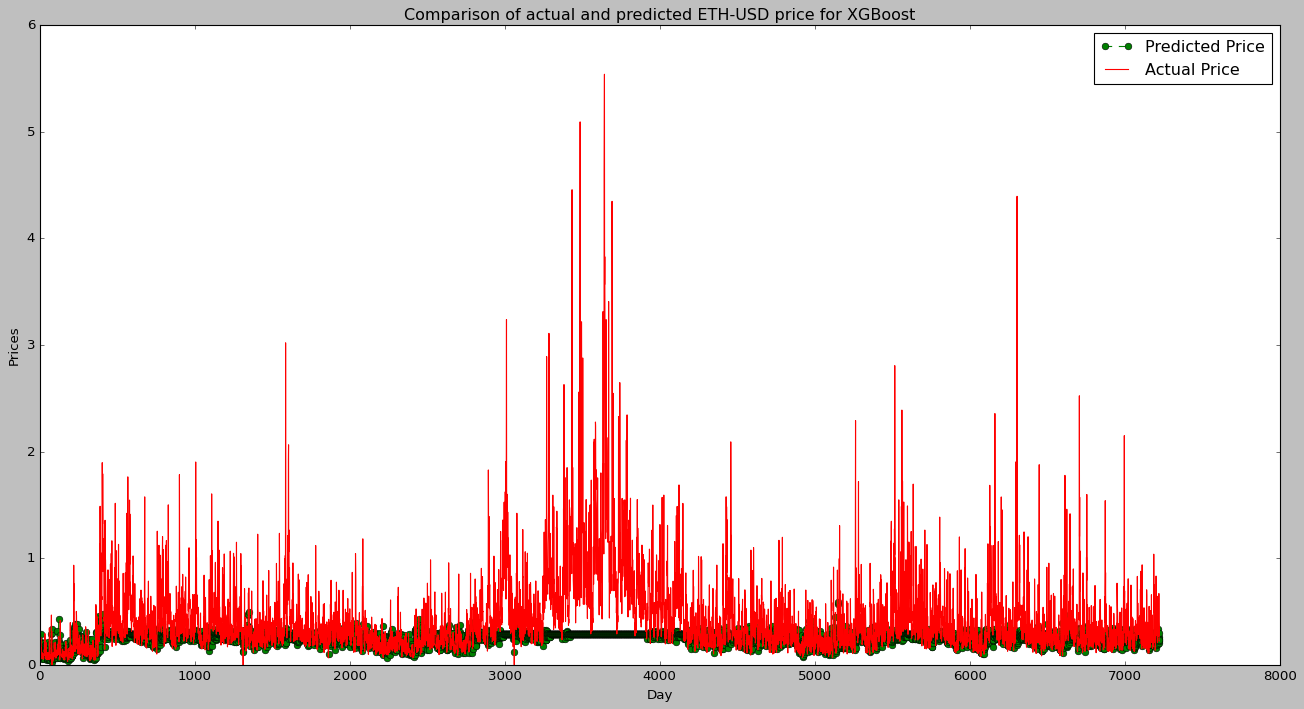

(-0.14356748979642964, 0.21187701921453916)

In [297]:
# Evaluate the results
evaluate_model(xgb_model, model_name="XGBoost", test_data=np.squeeze(X_test), target_data=np.squeeze(y_test))

## **8.2 LSTM**

In [277]:
# Instantiate sequential model
LSTM_Model = Sequential()

In [278]:
# Define lstm model
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1)))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96,
                    return_sequences=True))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(LSTM(units=96))
LSTM_Model.add(Dropout(0.2))
LSTM_Model.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [279]:
# Config the model
LSTM_Model.compile(loss=MSE, optimizer=Adam())

In [280]:
# Summary of model
LSTM_Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,065 (1015.88 KB)

 Trainable params: 260,065 (1015.88 KB)

 Non-trainable params: 0 (0.00 B)

In [306]:
# Fit the model
LSTM_Model.fit(X_train,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.05)

Epoch 1/10
 33/829 ━━━━━━━━━━━━━━━━━━━━ 51:15 4s/step - loss: 2.8716e-04

KeyboardInterrupt: 

226/226 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step
R Squared :  0.09972
Mean Absolute Error:  0.1834


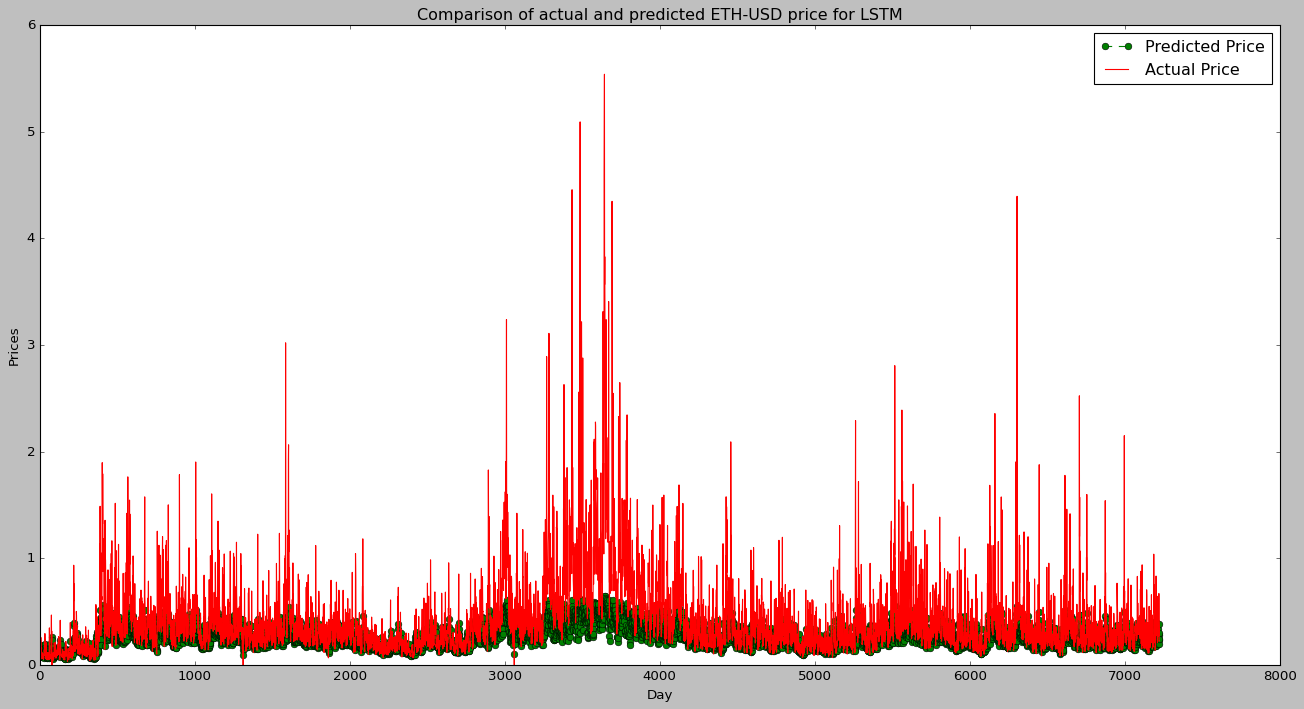

(0.09971593937658874, 0.18340222590554922)

In [282]:
# Evaluate the model and plot the results
evaluate_model(LSTM_Model, "LSTM")

## **8.3 CNN**

In [298]:
# Instantiate sequential model
CNN_model=Sequential()

In [299]:
# Define cnn model
CNN_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=X_train[0].shape))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Dropout(0.1))
CNN_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
CNN_model.add(MaxPooling1D(3))
CNN_model.add(Dropout(0.1))
CNN_model.add(Flatten())
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dense(1, activation='relu'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [300]:
# Config the model
CNN_model.compile(optimizer='adam', loss='mse')

In [301]:
# Summary of model
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 48, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 14, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,593 (57.00 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

In [302]:
# Fit the model
CNN_model.fit(X_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
438/817 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7834e-04

KeyboardInterrupt: 

In [ ]:
# Evaluate the model and plot the results
evaluate_model(CNN_model, "CNN")

In [ ]:
#Save models
LSTM_Model.save('LSTM.keras')
CNN_model.save('CNN.keras')

# **9. Deploy Model into Recent Data**

In [265]:
# Reminder on recent data which contains three months of eth price
eth_recent.head()

open  high  low  close  volume ETH  volume USDT  \
date                                                                   
2025-02-16 00:00:00     0     0    0      0           0            0   
2025-02-16 01:00:00     0     0    0      0           0            0   
2025-02-16 02:00:00     0     0    0      0           0            0   
2025-02-16 03:00:00     0     0    0      0           0            0   
2025-02-16 04:00:00     0     0    0      0           0            0   

                     close_log  
date                            
2025-02-16 00:00:00          0  
2025-02-16 01:00:00          0  
2025-02-16 02:00:00          0  
2025-02-16 03:00:00          0  
2025-02-16 04:00:00          0

In [267]:
# Scale before model
scaled_recent = scaler.fit_transform(eth_recent)

In [268]:
# Generate a new dataset out of recent data
X_test2, y_test2 = create_dataset(scaled_recent, 50, -1)

In [269]:
# Check the shape
X_test2.shape

# X_test2_df = pd.DataFrame(X_test2.reshape(X_test2.shape[0], X_test2.shape[1]))
# X_test2_df.head()

(8710, 50, 1)

In [275]:
# Evaluate the performance of model on recent data and plot the results

evaluate_model(model=LSTM_Model, model_name="LSTM Recent", test_data=X_test2, target_data=y_test2)



NameError: name 'LSTM_Model' is not defined

# **10. Conclusions**

In [ ]:
result = {'Model': ['XGBOOST', 'LSTM', 'CNN'],
          'R-squared': [-0.247, 0.942, 0.704], 'MAE':[0.169, 0.034, 0.096]}

In [ ]:
df_result = pd.DataFrame(result)
df_result.set_index('Model', inplace=True)
df_result

### **11. Prediction Set**

In [ ]:
# Create prediction set

# 4. Create future dates for prediction
last_date = eth.index[-1]
t = 24*7+1
future_dates = [last_date + timedelta(hours=i) for i in range(1, t)]  # 3 years *365*3

# 5. Prepare input data for future prediction

look_back = 48
future_input = eth.index[-look_back:] # Last 'look_back' data points
# Convert DatetimeIndex to numpy array before reshaping
future_input = eth['close'].tail(look_back).values.reshape(1, look_back, 1)

print(future_dates)

future_values = np.zeros(168)

print(future_values)

# print(future_input[:, -5:, :])

# evaluate_model(LSTM_Model, "LSTM Recent", X_test2, y_test2)

[Timestamp('2025-02-12 00:00:00'), Timestamp('2025-02-12 01:00:00'), Timestamp('2025-02-12 02:00:00'), Timestamp('2025-02-12 03:00:00'), Timestamp('2025-02-12 04:00:00'), Timestamp('2025-02-12 05:00:00'), Timestamp('2025-02-12 06:00:00'), Timestamp('2025-02-12 07:00:00'), Timestamp('2025-02-12 08:00:00'), Timestamp('2025-02-12 09:00:00'), Timestamp('2025-02-12 10:00:00'), Timestamp('2025-02-12 11:00:00'), Timestamp('2025-02-12 12:00:00'), Timestamp('2025-02-12 13:00:00'), Timestamp('2025-02-12 14:00:00'), Timestamp('2025-02-12 15:00:00'), Timestamp('2025-02-12 16:00:00'), Timestamp('2025-02-12 17:00:00'), Timestamp('2025-02-12 18:00:00'), Timestamp('2025-02-12 19:00:00'), Timestamp('2025-02-12 20:00:00'), Timestamp('2025-02-12 21:00:00'), Timestamp('2025-02-12 22:00:00'), Timestamp('2025-02-12 23:00:00'), Timestamp('2025-02-13 00:00:00'), Timestamp('2025-02-13 01:00:00'), Timestamp('2025-02-13 02:00:00'), Timestamp('2025-02-13 03:00:00'), Timestamp('2025-02-13 04:00:00'), Timestamp('20

In [ ]:

# print(last_date)

# Convert the list to a pandas Series before using tail
future_dates_series = pd.Series(future_dates)
#future_dates_series.tail(5)
#future_dates_series.head(5)

future_input_series = pd.Series(future_input.flatten())

#future_input_series.tail(5)
future_input_series.head(50)

0     2642.71
1     2574.69
2     2589.54
3     2625.97
4     2628.75
5     2638.40
6     2636.25
7     2637.03
8     2644.80
9     2650.40
10    2647.47
11    2653.16
12    2639.33
13    2677.76
14    2650.86
15    2658.22
16    2664.82
17    2679.01
18    2683.22
19    2672.28
20    2684.28
21    2664.34
22    2658.49
23    2661.19
24    2705.59
25    2695.00
26    2681.49
27    2678.89
28    2693.21
29    2717.01
30    2722.81
31    2712.15
32    2715.29
33    2704.52
34    2697.06
35    2708.80
36    2686.03
37    2634.47
38    2663.81
39    2662.36
40    2645.43
41    2640.79
42    2610.77
43    2589.70
44    2598.44
45    2622.12
46    2586.39
47    2602.59
dtype: float64

In [ ]:
future_dates_series.head(5)

0   2025-02-12 00:00:00
1   2025-02-12 01:00:00
2   2025-02-12 02:00:00
3   2025-02-12 03:00:00
4   2025-02-12 04:00:00
dtype: datetime64[ns]

In [ ]:
# Generate predictions for the entire future time set (future_dates)
num_predictions = len(future_dates)  # Number of predictions needed

print(num_predictions)

future_predictions = []  # Initialize an empty list to store predictions

print(future_predictions)


168
[]


In [ ]:
nan = eth[eth.isnull().any(axis=1)]

nan2 = future_dates

# nan[0, :] = nan2

eth_columns = eth.columns

nan2_reshaped = [[date] + [np.nan] * (len(eth_columns) - 1) for date in nan2]

new_row = pd.DataFrame(nan2_reshaped, columns=eth_columns)

# If 'nan' is empty, simply assign 'new_row' to 'nan'
if nan.empty:
    nan = new_row
else:
    # If 'nan' is not empty, append the new row
    nan = pd.concat([nan, new_row], ignore_index=True)

    nan = nan.rename(columns={nan.columns[1]: 'date'})

nan
#nan2

open  high  low  close  Volume ETH  Volume USDT  close_log
0   2025-02-12 00:00:00   NaN  NaN    NaN         NaN          NaN        NaN
1   2025-02-12 01:00:00   NaN  NaN    NaN         NaN          NaN        NaN
2   2025-02-12 02:00:00   NaN  NaN    NaN         NaN          NaN        NaN
3   2025-02-12 03:00:00   NaN  NaN    NaN         NaN          NaN        NaN
4   2025-02-12 04:00:00   NaN  NaN    NaN         NaN          NaN        NaN
..                  ...   ...  ...    ...         ...          ...        ...
163 2025-02-18 19:00:00   NaN  NaN    NaN         NaN          NaN        NaN
164 2025-02-18 20:00:00   NaN  NaN    NaN         NaN          NaN        NaN
165 2025-02-18 21:00:00   NaN  NaN    NaN         NaN          NaN        NaN
166 2025-02-18 22:00:00   NaN  NaN    NaN         NaN          NaN        NaN
167 2025-02-18 23:00:00   NaN  NaN    NaN         NaN          NaN        NaN

[168 rows x 7 columns]

In [ ]:


# Instead of modifying future_input directly, create a copy for predictions
future_input_for_pred = future_input.copy()

for _ in range(num_predictions):
    # Use the numerical copy for prediction
    prediction = model.predict(future_input_for_pred)
    future_predictions.append(prediction[0, 0])

    # Create a new row with the prediction and move the prediction window forward
    new_row = np.array([[prediction[0, 0]]])  # Create new row with prediction
    new_row = new_row.reshape(1, 1, 1)  # Reshape for concatenation

    # Shift the numerical input data and add the new prediction
    future_input_for_pred = np.concatenate([future_input_for_pred[:, 1:, :], new_row], axis=1)

# Create the DataFrame using future_dates as the index
future_predictions_df = pd.DataFrame({'Predictions': future_predictions}, index=future_dates)
future_predictions_df.index.name = 'Date'

print(future_predictions_df)

In [ ]:
print(future_predictions_df.loc[future_dates_series.tail(100).values])

                     Predictions
Date                            
2025-02-14 20:00:00     1.032986
2025-02-14 21:00:00     1.029109
2025-02-14 22:00:00     1.025315
2025-02-14 23:00:00     1.021603
2025-02-15 00:00:00     1.017970
...                          ...
2025-02-18 19:00:00     0.838993
2025-02-18 20:00:00     0.837805
2025-02-18 21:00:00     0.836625
2025-02-18 22:00:00     0.835454
2025-02-18 23:00:00     0.834289

[100 rows x 1 columns]


In [ ]:

# Import the LabelEncoder class from the sklearn.preprocessing module
from sklearn.preprocessing import LabelEncoder

# Assuming 'future_dates_series' is a Pandas Series of datetime objects
# Convert 'future_dates_series' to numerical representation using LabelEncoder
label_encoder = LabelEncoder()
X_train_encoded = label_encoder.fit_transform(future_dates_series)

# Create DataFrames with the encoded values
X_train = pd.DataFrame(X_train_encoded, columns=['Date'])
y_train = pd.DataFrame(X_train_encoded, columns=['Predictions'])  # Assuming you want to predict the date itself

# Now you can fit the model
LSTM_Model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_split=0.05)

LSTM_Model.fit(X_train,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.05)

evaluate_model(LSTM_Model, "LSTM",X_train,y_train)



Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2217.7817 - val_loss: 11104.4727
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2405.1128 - val_loss: 10973.7666
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 2078.3943 - val_loss: 10847.8711
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1982.8759 - val_loss: 10725.4258
Epoch 5/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 1609.6013

KeyboardInterrupt: 

In [ ]:
# 6. Make future predictions
future_predictions = []

model = LSTM_Model

# Convert future_input to float32 initially (for ordinal representation)
future_input = future_input.astype(np.float32)

for _ in range(168):  # Predicting for a week, hourly

#for _ in range(24*365*3):  # Predicting for 3 years, hourly

    # Predict using the current future_input
    prediction = model.predict(future_input)
    future_predictions.append(prediction[0, 0])

    # Create a new row with the prediction and the next hour
    last_datetime_ordinal = future_input[0, -1, 0]
    next_datetime_ordinal = last_datetime_ordinal + 1/24.0  # Assuming ordinal representation; adding 1/24 for hourly step
    new_row = np.array([[next_datetime_ordinal, prediction[0, 0]]])

    # Reshape new_row for concatenation
    new_row = new_row.reshape(1, 1, 2)

    # Concatenate to future_input, removing the oldest data point
    future_input = np.concatenate([future_input[:, 1:, :], new_row[:, :, 1:]], axis=1)

# Instead of converting back to datetimes using fromordinal,
# use the original future_dates list which contains the correct DatetimeIndex values.
future_predictions_df = pd.DataFrame({'Predictions': future_predictions}, index=future_dates[-len(future_predictions):])
future_predictions_df.index.name = 'Date'

print(future_predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
                     Predictions
Date                            
2028-02-11 

In [ ]:
evaluate_model(LSTM_Model, "LSTM Recent", future_input, future_predictions_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


ValueError: Found input variables with inconsistent numbers of samples: [24, 1]

In [ ]:
# 6. Make future predictions
future_predictions = []
for _ in range(365*3):
    prediction = model.predict(future_input)
    future_predictions.append(prediction[0, 0])
    future_input = np.append(future_input[:, 1:, :], prediction.reshape(1, 1, 1), axis=1) # Update input for next step

# Invert future predictions to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 7. Create a DataFrame for future predictions
future_df = pd.DataFrame({'date': future_dates, 'predicted_price': future_predictions.flatten()})
future_df.set_index('date', inplace=True)

# 8. Concatenate original data with predictions
eth_with_predictions = pd.concat([eth, future_df])

# 9. Plot the results
plt.plot(eth_with_predictions['price'], label='Actual Price')
plt.plot(future_df['predicted_price'], label='Predicted Price')
plt.legend()
plt.title('Ethereum Price Prediction for Next 3 Years (LSTM)')
plt.show()